# Statistics for Image Analysis

## 1.0 Load Dependencies and Data

In [1]:
import os
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, median_abs_deviation, f_oneway, ttest_ind, kruskal, wilcoxon, mannwhitneyu, ks_2samp
from itertools import combinations
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
from statannotations.stats.utils import return_results
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
df = pd.DataFrame(pd.read_csv('cZRS_WT_Results.csv'))

## 2.0 RGB Channel Analysis 🌈

## 2.1 Descriptive Statistics

### 2.1.1 Create a new Dataframe for RGB Channel Analysis

In [3]:
# Make df copy with only the columns necessary for RGB Channel Analysis
df_c1 = df.copy()
columns = ['e_name', 'e_mut', 'rfp_r_percent', 'rfp_g_percent', 'rfp_b_percent', 'gfp_r_percent', 'gfp_g_percent', 'gfp_b_percent']
rgb_df_raw = df_c1[columns]
# List of numerical columns for the following analysis
rgb_columns = ['rfp_r_percent', 'rfp_g_percent', 'rfp_b_percent', 'gfp_r_percent', 'gfp_g_percent', 'gfp_b_percent']

### 2.1.2 Check distribution of raw data with histograms and Shapiro-Wilk test 

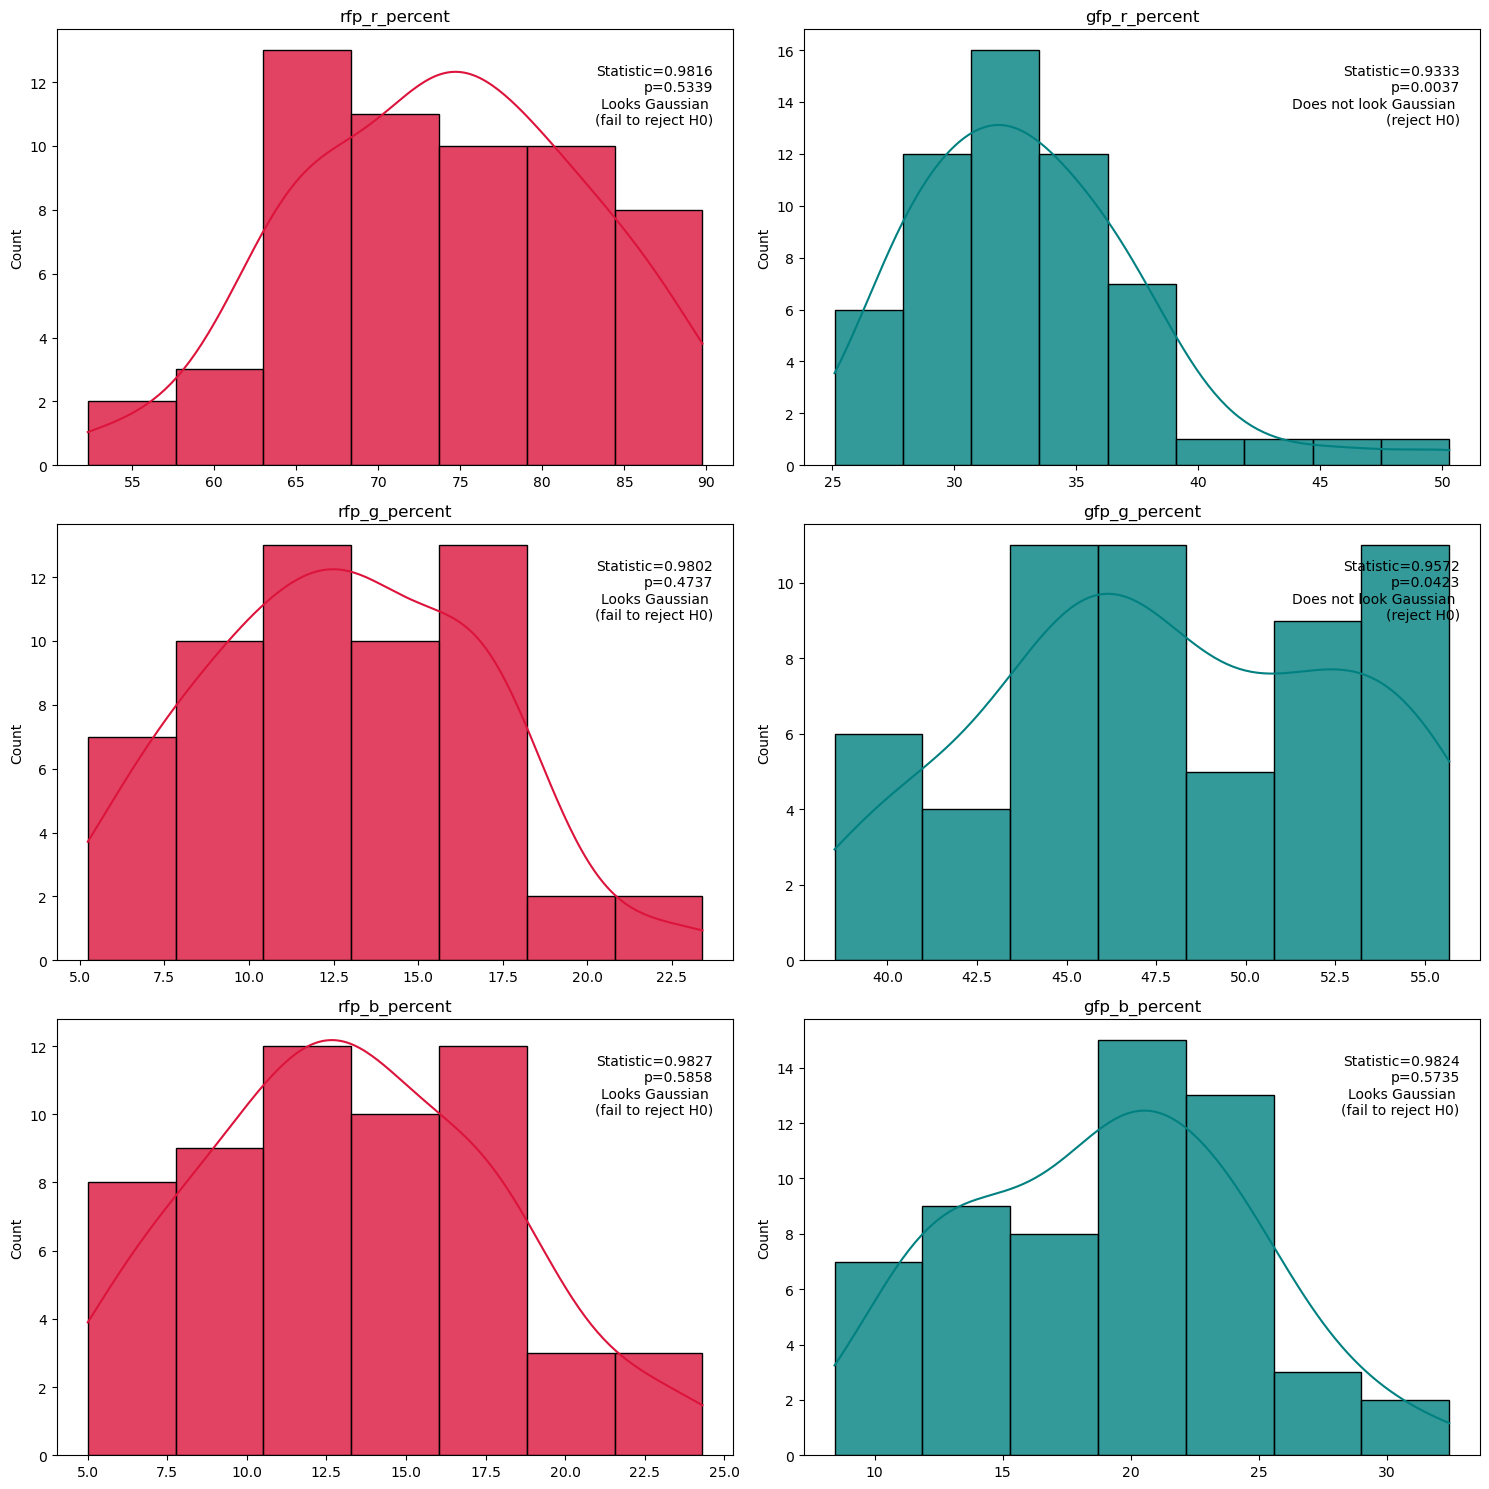

Method Name  Count       Mean       Std        Min        25%        50%  \
0  rfp_r_percent   57.0  73.894928  8.615114  52.282557  66.837781  73.470656   
1  gfp_r_percent   57.0  33.076456  4.768900  25.089470  30.154448  32.536916   
2  rfp_g_percent   57.0  12.842240  4.068200   5.235833   9.920078  12.810866   
3  gfp_g_percent   57.0  47.889810  4.914343  38.526070  44.201296  47.096407   
4  rfp_b_percent   57.0  13.262831  4.591173   5.002797  10.076060  13.104146   
5  gfp_b_percent   57.0  19.033734  5.495119   8.436394  14.769857  19.195950   

         75%        Max  Alpha  Shapiro W  Shapiro p  \
0  79.727745  89.761371   0.05   0.981577   0.533870   
1  35.914640  50.281288   0.05   0.933318   0.003688   
2  16.416908  23.405264   0.05   0.980235   0.473651   
3  51.905315  55.676233   0.05   0.957248   0.042344   
4  16.934298  24.312179   0.05   0.982672   0.585793   
5  23.386409  32.421885   0.05   0.982417   0.573515   

                                    Interpretation  
0  Distribution looks Gaussian (fail to reject H0)  
1  Distribution does not look Gaussian (reject H0)  
2  Distribution looks Gaussian (fail to reject H0)  
3  Distribution does not look Gaussian (reject H0)  
4  Distribution looks Gaussian (fail to reject H0)  
5  Distribution looks Gaussian (fail to reject H0)

In [4]:
def rgb_descriptive_stats(df, columns, alpha=0.05, num_cols=3, hist_colors=None):
    num_selected_cols = len(columns)
    num_rows = (num_selected_cols + num_cols - 1) // num_cols

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    result = []

    for i, col in enumerate(columns):
        if col not in df.columns:
            continue

        treatment_group = df[col]
        descriptive_stats = treatment_group.describe()
        shapiro_stat, shapiro_p = shapiro(treatment_group)

        interpretation = 'Distribution looks Gaussian (fail to reject H0)' if shapiro_p > alpha else 'Distribution does not look Gaussian (reject H0)'
        interp = 'Looks Gaussian \n(fail to reject H0)' if shapiro_p > alpha else 'Does not look Gaussian \n(reject H0)'

        row = {
            'Method Name': col,
            'Count': descriptive_stats['count'],
            'Mean': descriptive_stats['mean'],
            'Std': descriptive_stats['std'],
            'Min': descriptive_stats['min'],
            '25%': descriptive_stats['25%'],
            '50%': descriptive_stats['50%'],
            '75%': descriptive_stats['75%'],
            'Max': descriptive_stats['max'],
            'Alpha': alpha,
            'Shapiro W': shapiro_stat,
            'Shapiro p': shapiro_p,
            'Interpretation': interpretation
        }
        result.append(row)

        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        # Set histogram color if specified
        color_index = i % len(hist_colors) if hist_colors else 0
        color = hist_colors[color_index] if hist_colors else 'purple'
        
        sns.histplot(data=treatment_group, kde=True, color=color, alpha=0.8, ax=ax)
        ax.set_title(col, fontsize=12)
        ax.set_xlabel('')
        ax.text(0.97, 0.92, f'Statistic={shapiro_stat:.4f}\np={shapiro_p:.4f}\n{interp}',
                fontsize=10, ha='right', va='top', transform=ax.transAxes)

    # Remove empty subplots
    if num_selected_cols < num_rows * num_cols:
        for i in range(num_selected_cols, num_rows * num_cols):
            axs.flat[i].set_visible(False)

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(result)

# To make a figure title
#   fig.suptitle('Histograms with Shapiro-Wilk Test', fontsize=16)
#   plt.tight_layout()
#   plt.subplots_adjust(top=0.97)
#   plt.show()

hist_colors = ['crimson', 'teal']
hist_columns = [
        'rfp_r_percent', 'gfp_r_percent', 
        'rfp_g_percent', 'gfp_g_percent', 
        'rfp_b_percent', 'gfp_b_percent'
        ]
result_df = rgb_descriptive_stats(rgb_df_raw, hist_columns, alpha=0.05, num_cols=2, hist_colors=hist_colors)
result_df
# result_df.to_csv('rgb_raw_descriptive_stats.csv', index=False)


### 2.1.3 Visualize raw data with box and swarm plots

Melt data to reshape for stats and plotting 🫠

In [5]:
rgb_df_raw_melt = rgb_df_raw.melt(value_vars=[
    'rfp_r_percent', 'rfp_g_percent', 'rfp_b_percent', 'gfp_r_percent', 'gfp_g_percent', 'gfp_b_percent'], var_name='Channel', value_name='Percent')
rgb_df_raw_melt


Channel    Percent
0    rfp_r_percent  86.289066
1    rfp_r_percent  84.487425
2    rfp_r_percent  82.240539
3    rfp_r_percent  66.837781
4    rfp_r_percent  70.958671
..             ...        ...
337  gfp_b_percent  22.145723
338  gfp_b_percent  29.624645
339  gfp_b_percent  20.567809
340  gfp_b_percent  14.478309
341  gfp_b_percent  24.890608

[342 rows x 2 columns]

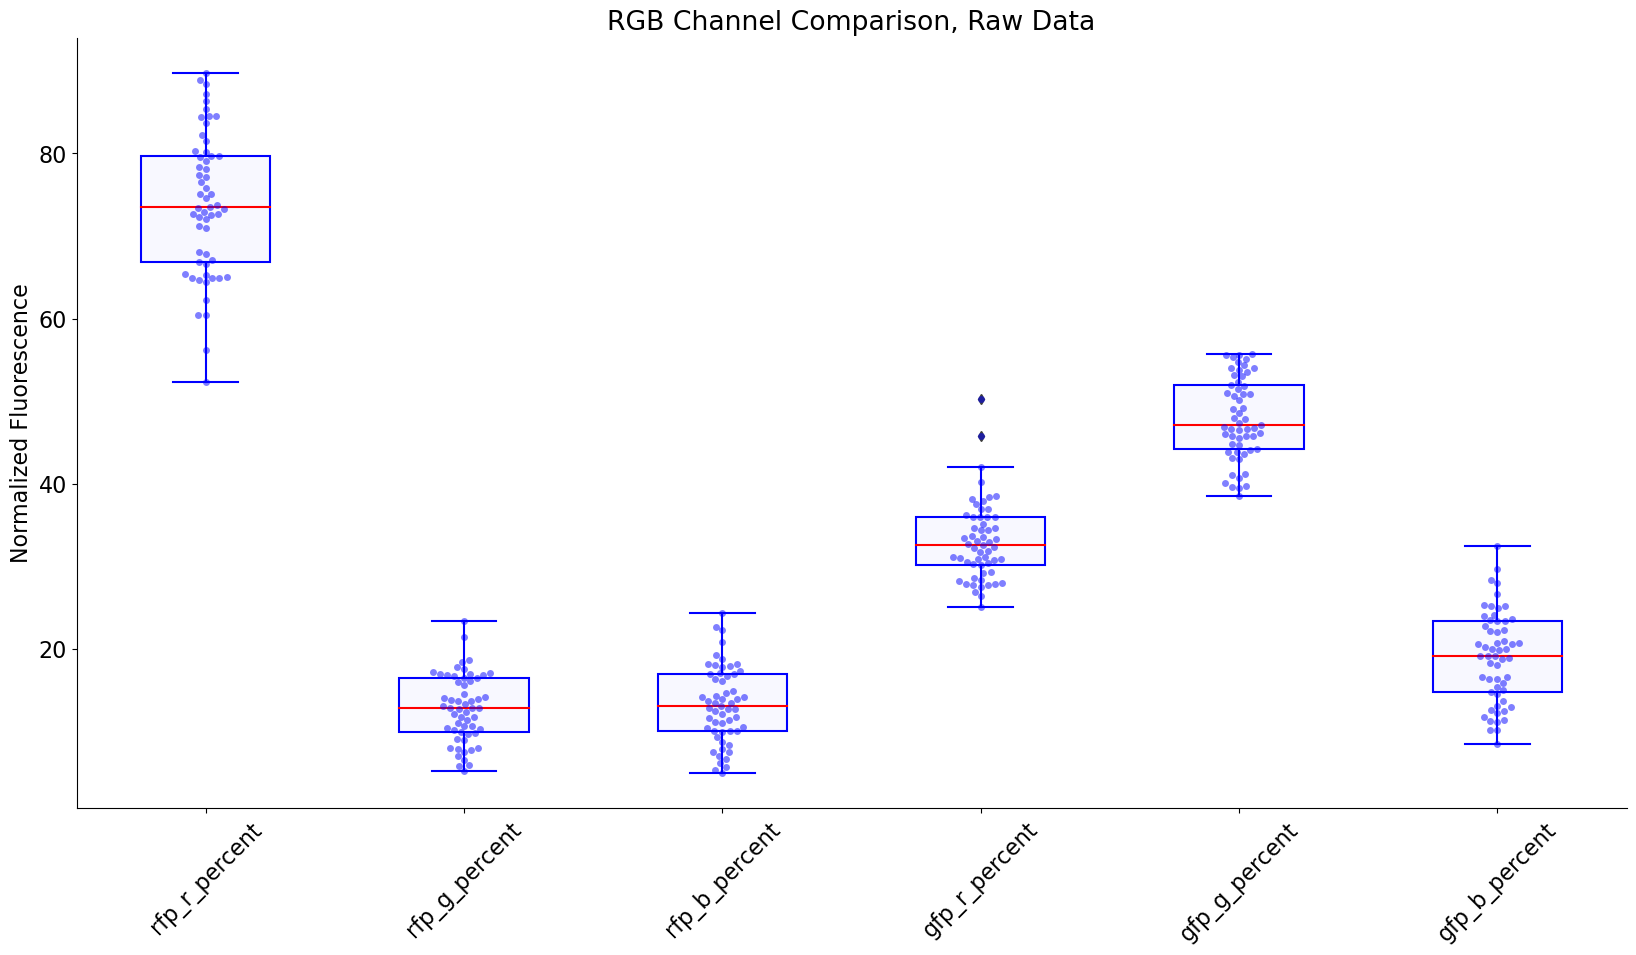

In [6]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='blue'):
        pairs = list(combinations(order, 2))
        plt.figure(figsize=(20, 10))
        plt.rcParams.update({'font.size': 16})
        
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': 'red'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        # Annotate with Kruskal-Wallis Test
        # annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.configure(test='Kruskal', text_format='star', loc='inside')
        # annotator.apply_and_annotate() 

        # Annotate with Kolmogorov-Smirnov Test
        # custom_long_name = 'Kolmogorov-Smirnov Test'
        # custom_short_name = 'KStest'
        # custom_func = kstest
        # custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

        # annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.reset_configuration()
        # annotator.new_plot(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.configure(test=custom_test, comparisons_correction=None,
        #             text_format='star').apply_and_annotate()

        # mut_dict = {'rgb_limb_i_sum_norm': 'RGB Limb', 'g_limb_i_sum_norm':'G Limb', 'rgb_post_i_sum_norm':'RGB Post',
        #             'g_post_i_sum_norm':'G Post', 'rgb_zpa_i_sum_norm':'RGB ZPA',  'g_zpa_i_sum_norm':'G ZPA'}
        # label_list = [mut_dict[i] for i in order]
        plt.title(ptitle)
        ax.set_xticklabels(order, rotation=45)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence')
        plt.show()
        #plt.savefig('Fig_Name.png')



box_swarm_plot(rgb_df_raw_melt, rgb_columns, 'Channel', 'Percent', 'RGB Channel Comparison, Raw Data')



Most of these groups have a fairly normal distribution, but we should probably drop a couple outliers.

### 2.1.4 Outlier Removal

In [7]:
"""
IQR Method
Assumptions: 
    Does NOT assume normal distribution
    The '1.5' is the range, it would be different for something like exponential data
    Is based on median, not mean
    Is robust against outlier influence

"""

def remove_outliers_iqr(df, columns, multiplier=1.5): #Most common multiplier values are 1.5 followed by 1.7
    df_cleaned = df.copy()
    indices_to_drop = []
    
    for col in columns:
        values = df[col].values
        q3, q1 = np.percentile(values, [75,25])
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-multiplier*iqr
        fence_high = q3+multiplier*iqr
        outliers= np.where((values < fence_low) | (fence_high < values))[0]
        indices_to_drop.extend(outliers)
        
    print(indices_to_drop)
    df_cleaned = df_cleaned.drop(indices_to_drop)

    return df_cleaned


rgb_df_cleaned_iqr = remove_outliers_iqr(rgb_df_raw, rgb_columns)
rgb_df_cleaned_iqr
# rgb_df_cleaned_iqr.to_csv('rgb_df_cleaned_iqr.csv', index=False)

# Returns rows:
# outliers_iqr = [0, 50]

[0, 50]


e_name    e_mut  rfp_r_percent  rfp_g_percent  rfp_b_percent  \
1   2020-02-11_E22  cZRS_WT      84.487425       7.974703       7.537871   
2   2020-07-22_E04  cZRS_WT      82.240539       9.018532       8.740928   
3   2020-08-10_E08  cZRS_WT      66.837781      16.416908      16.745311   
4   2020-09-30_E08  cZRS_WT      70.958671      14.129686      14.911643   
5   2020-10-20_E07  cZRS_WT      76.493615      11.789134      11.717252   
6   2020-10-28_E02  cZRS_WT      73.470656      13.824823      12.704521   
7   2020-10-28_E03  cZRS_WT      72.010982      14.590198      13.398821   
8   2020-10-28_E09  cZRS_WT      73.238930      13.939336      12.821733   
9   2020-11-02_E02  cZRS_WT      84.515628       8.030862       7.453510   
10  2020-11-02_E04  cZRS_WT      75.081161      12.765011      12.153827   
11  2020-11-11_E03  cZRS_WT      85.410075       7.529633       7.060291   
12  2020-11-11_E04  cZRS_WT      88.859867       5.863342       5.276792   
13  2020-11-23_E04  cZRS_WT      87.243296       6.528748       6.227956   
14  2020-11-30_E05  cZRS_WT      72.240158      13.632538      14.127304   
15  2020-11-30_E07  cZRS_WT      62.279925      18.412316      19.307759   
16  2020-11-30_E10  cZRS_WT      65.088258      17.046177      17.865566   
17  2020-12-16_E06  cZRS_WT      88.366390       5.890670       5.742940   
18  2020-12-16_E09  cZRS_WT      89.761371       5.235833       5.002797   
19  2021-02-01_E03  cZRS_WT      75.088849      12.136031      12.775120   
20  2021-02-01_E04  cZRS_WT      77.404513      10.971104      11.624383   
21  2021-02-01_E10  cZRS_WT      65.303533      16.808811      17.887656   
22  2021-02-10_E05  cZRS_WT      75.826144      11.739546      12.434309   
23  2021-02-01_E10  cZRS_WT      64.949556      16.986169      18.064275   
24  2021-03-02_E04  cZRS_WT      80.179775       9.744165      10.076060   
25  2021-03-02_E05  cZRS_WT      78.339253      10.637566      11.023181   
26  2021-03-02_E25  cZRS_WT      78.157542      10.674115      11.168344   
27  2021-03-16_E05  cZRS_WT      67.073552      15.985589      16.940859   
28  2021-03-16_E09  cZRS_WT      83.733969       7.934623       8.331408   
29  2021-03-22_E04  cZRS_WT      73.703255      12.810866      13.485879   
30  2021-03-22_E05  cZRS_WT      64.908062      16.946140      18.145798   
31  2021-03-22_E06  cZRS_WT      74.540612      12.355242      13.104146   
32  2021-03-29_E06  cZRS_WT      80.228022       9.762119      10.009859   
33  2021-04-21_E02  cZRS_WT      71.177653      14.109879      14.712468   
34  2021-04-28_E07  cZRS_WT      81.552270       9.132797       9.314933   
35  2021-04-28_E08  cZRS_WT      72.699795      13.329685      13.970520   
36  2021-06-28_E11  cZRS_WT      77.158218      11.407076      11.434706   
37  2021-07-14_E06  cZRS_WT      73.347239      12.780609      13.872152   
38  2021-07-19_E10  cZRS_WT      72.936346      12.896240      14.167414   
39  2021-07-19_E22  cZRS_WT      72.594450      13.066995      14.338555   
40  2021-07-26_E04  cZRS_WT      52.282557      23.405264      24.312179   
41  2021-09-20_E01  cZRS_WT      66.570999      16.494703      16.934298   
42  2021-09-20_E06  cZRS_WT      79.641073       9.920078      10.438850   
43  2021-10-04_E04  cZRS_WT      68.073032      15.609054      16.317913   
44  2021-10-04_E09  cZRS_WT      67.812147      16.098858      16.088995   
45  2021-10-04_E10  cZRS_WT      64.611831      17.205009      18.183161   
46  2021-11-01_E06  cZRS_WT      64.448428      16.740167      18.811405   
47  2021-11-01_E10  cZRS_WT      60.486175      18.622232      20.891593   
48  2021-11-15_E05  cZRS_WT      56.233219      21.437177      22.329604   
49  2021-11-15_E07  cZRS_WT      72.683654      13.642655      13.673691   
51  2021-12-06_E07  cZRS_WT      79.727745      10.167806      10.104449   
52  2021-12-06_E10  cZRS_WT      79.102308      10.354781      10.542910   
53  2022-01-31_E06  cZRS_WT      60.448131      16.888242   

### 2.1.5 Check distribution of cleaned data with histograms and Shapiro-Wilk test 

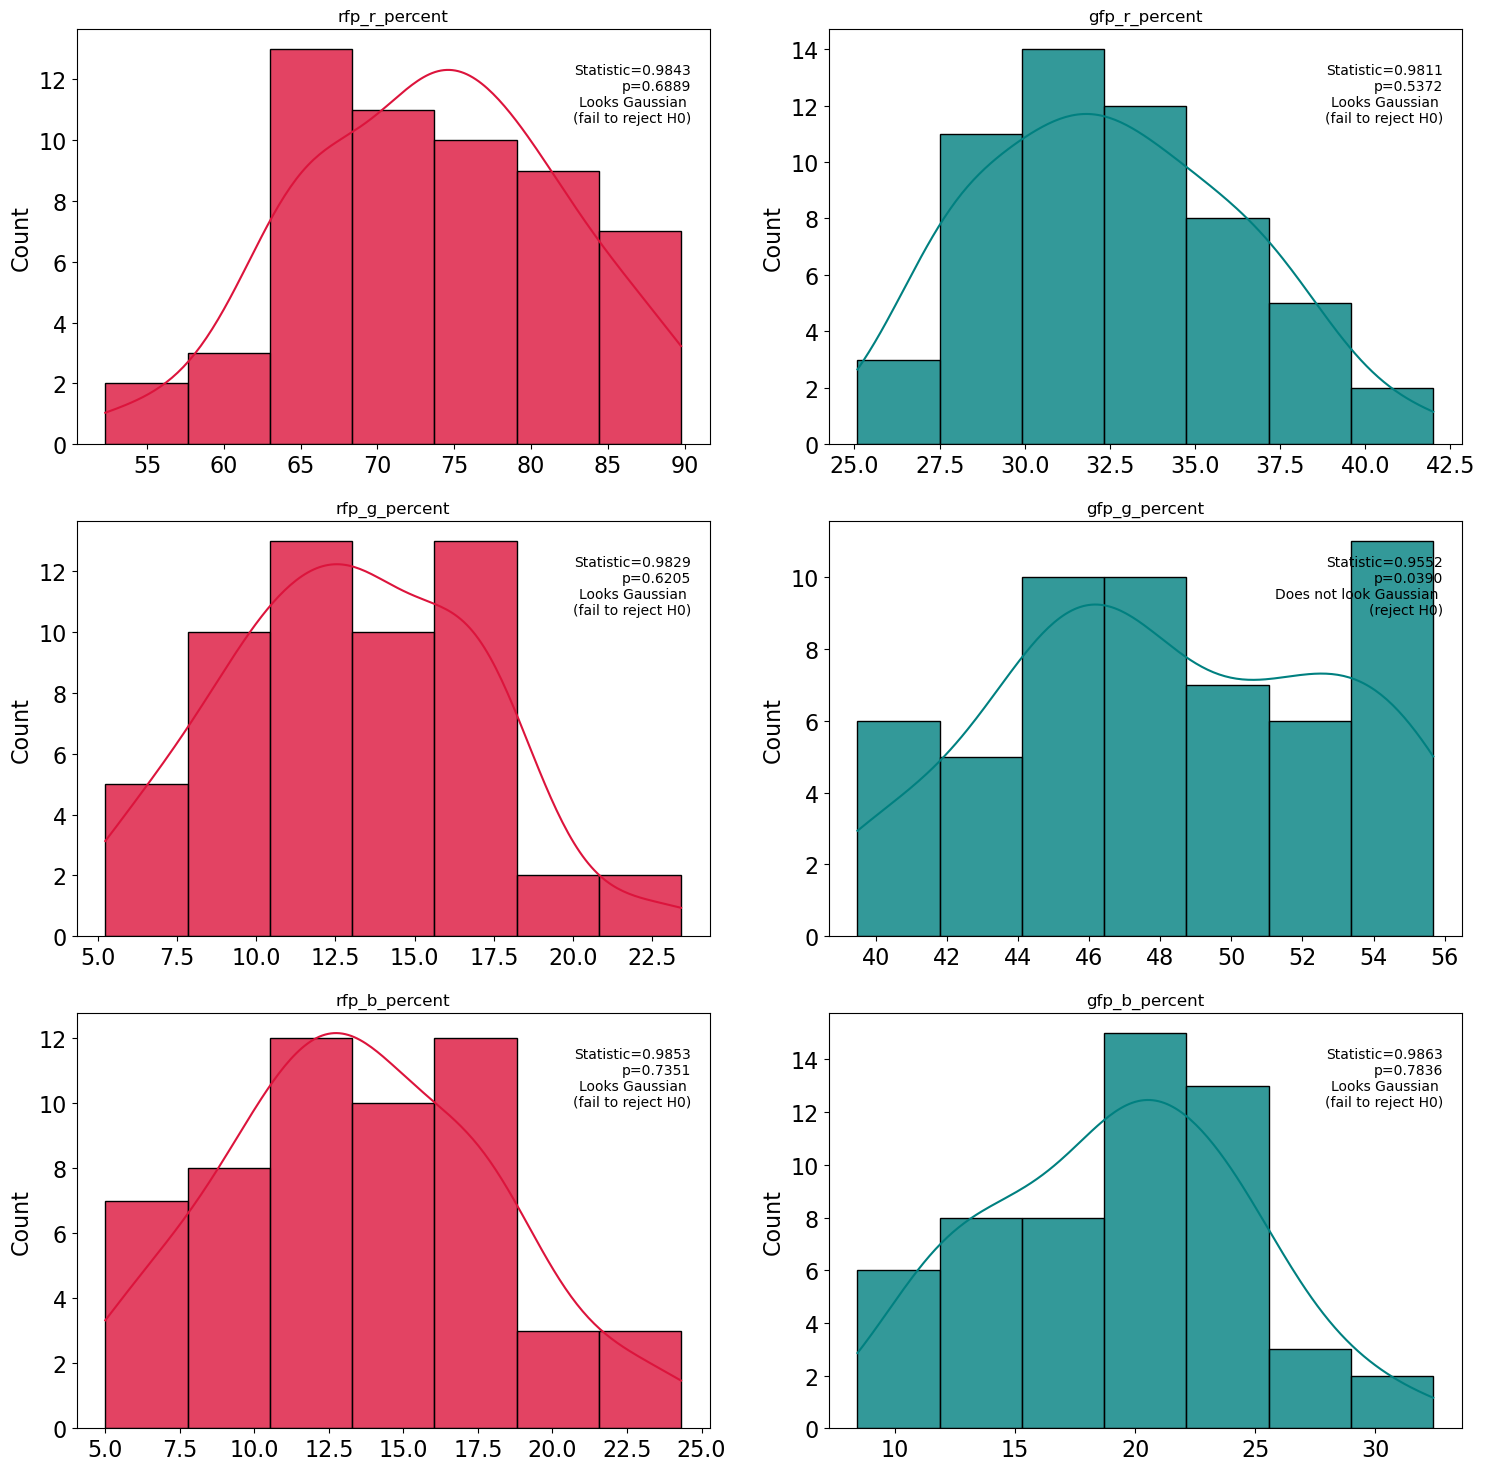

Method Name  Count       Mean       Std        Min        25%        50%  \
0  rfp_r_percent   55.0  73.479566  8.480925  52.282557  66.704390  73.347239   
1  gfp_r_percent   55.0  32.532150  3.847003  25.089470  29.701222  32.292766   
2  rfp_g_percent   55.0  13.041066  4.001272   5.235833  10.261294  12.896240   
3  gfp_g_percent   55.0  48.184411  4.739929  39.484405  44.776357  47.378445   
4  rfp_b_percent   55.0  13.479368  4.526127   5.002797  10.271649  13.398821   
5  gfp_b_percent   55.0  19.283439  5.428591   8.436394  15.162565  19.817563   

         75%        Max  Alpha  Shapiro W  Shapiro p  \
0  79.611159  89.761371   0.05   0.984328   0.688863   
1  35.528559  41.995224   0.05   0.981121   0.537215   
2  16.455805  23.405264   0.05   0.982910   0.620522   
3  52.094297  55.676233   0.05   0.955152   0.039018   
4  16.937578  24.312179   0.05   0.985290   0.735148   
5  23.406362  32.421885   0.05   0.986321   0.783558   

                                    Interpretation  
0  Distribution looks Gaussian (fail to reject H0)  
1  Distribution looks Gaussian (fail to reject H0)  
2  Distribution looks Gaussian (fail to reject H0)  
3  Distribution does not look Gaussian (reject H0)  
4  Distribution looks Gaussian (fail to reject H0)  
5  Distribution looks Gaussian (fail to reject H0)

In [8]:
hist_colors = ['crimson', 'teal']
hist_columns = [
        'rfp_r_percent', 'gfp_r_percent', 
        'rfp_g_percent', 'gfp_g_percent', 
        'rfp_b_percent', 'gfp_b_percent'
        ]
result_df = rgb_descriptive_stats(rgb_df_cleaned_iqr, hist_columns, alpha=0.05, num_cols=2, hist_colors=hist_colors)
result_df
# result_df.to_csv('rgb_cleaned_iqr_descriptive_stats.csv', index=False)


### 2.1.6 Visualize cleaned data with box and swarm plots

Melt data to reshape for stats and plotting 🫠

In [9]:
rgb_df_cleaned_iqr_melt = rgb_df_cleaned_iqr.melt(value_vars=rgb_columns, var_name='Channel', value_name='Percent')
rgb_df_cleaned_iqr_melt


Channel    Percent
0    rfp_r_percent  84.487425
1    rfp_r_percent  82.240539
2    rfp_r_percent  66.837781
3    rfp_r_percent  70.958671
4    rfp_r_percent  76.493615
..             ...        ...
325  gfp_b_percent  22.145723
326  gfp_b_percent  29.624645
327  gfp_b_percent  20.567809
328  gfp_b_percent  14.478309
329  gfp_b_percent  24.890608

[330 rows x 2 columns]

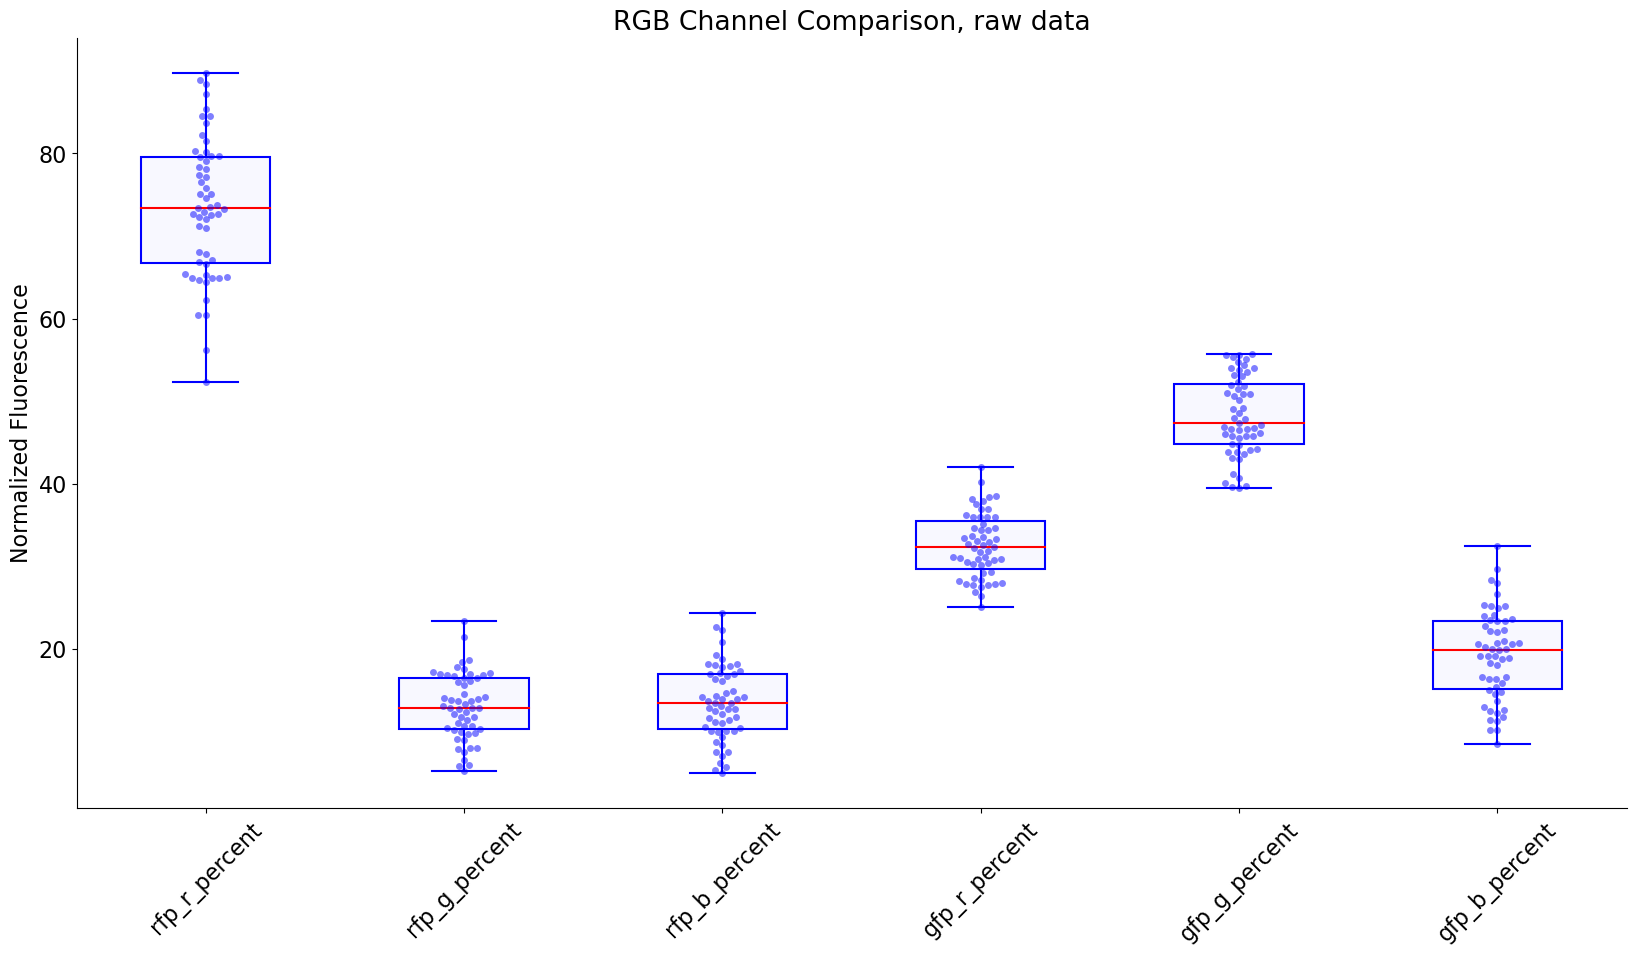

In [10]:
box_swarm_plot(rgb_df_cleaned_iqr_melt, rgb_columns, 'Channel', 'Percent', 'RGB Channel Comparison, raw data')

### Descriptive Stat Conclusions
The data for these groups is pretty tighly clusetered. The GFP G channel percent is still not normal, but by the look of it, I would have to drop a lot of points at either the top or bottom and I don't think they are true outliers.

## 2.2 Comparitive Statistics

Make separate coloumns for image type and color channel and use a dictionary to populate them.

In [11]:
header_list = ['Image Type', 'Channel', 'Percent']
rgb_df_cleaned_iqr_melt = rgb_df_cleaned_iqr_melt.reindex(columns=header_list)
rgb_df_cleaned_iqr_melt['Image Type'] = rgb_df_cleaned_iqr_melt['Channel']
rgb_df_cleaned_iqr_melt['Image Type'] = rgb_df_cleaned_iqr_melt['Image Type'].replace(
    {'rfp_r_percent': 'RFP', 'rfp_g_percent': 'RFP', 'rfp_b_percent': 'RFP', 'gfp_r_percent': 'GFP', 'gfp_g_percent': 'GFP', 'gfp_b_percent': 'GFP'})
rgb_df_cleaned_iqr_melt['Channel'] = rgb_df_cleaned_iqr_melt['Channel'].replace(
    {'rfp_r_percent': 'R', 'rfp_g_percent': 'G', 'rfp_b_percent': 'B', 'gfp_r_percent': 'R', 'gfp_g_percent': 'G', 'gfp_b_percent': 'B'})
rgb_df_cleaned_iqr_melt


Image Type Channel    Percent
0          RFP       R  84.487425
1          RFP       R  82.240539
2          RFP       R  66.837781
3          RFP       R  70.958671
4          RFP       R  76.493615
..         ...     ...        ...
325        GFP       B  22.145723
326        GFP       B  29.624645
327        GFP       B  20.567809
328        GFP       B  14.478309
329        GFP       B  24.890608

[330 rows x 3 columns]

In [12]:
rgb_df_cleaned_iqr_melt_group = rgb_df_cleaned_iqr_melt.groupby(['Image Type','Channel'])
rgb_df_cleaned_iqr_melt_group['Percent'].describe()


count       mean       std        min        25%  \
Image Type Channel                                                     
GFP        B         55.0  19.283439  5.428591   8.436394  15.162565   
           G         55.0  48.184411  4.739929  39.484405  44.776357   
           R         55.0  32.532150  3.847003  25.089470  29.701222   
RFP        B         55.0  13.479368  4.526127   5.002797  10.271649   
           G         55.0  13.041066  4.001272   5.235833  10.261294   
           R         55.0  73.479566  8.480925  52.282557  66.704390   

                          50%        75%        max  
Image Type Channel                                   
GFP        B        19.817563  23.406362  32.421885  
           G        47.378445  52.094297  55.676233  
           R        32.292766  35.528559  41.995224  
RFP        B        13.398821  16.937578  24.312179  
           G        12.896240  16.455805  23.405264  
           R        73.347239  79.611159  89.761371

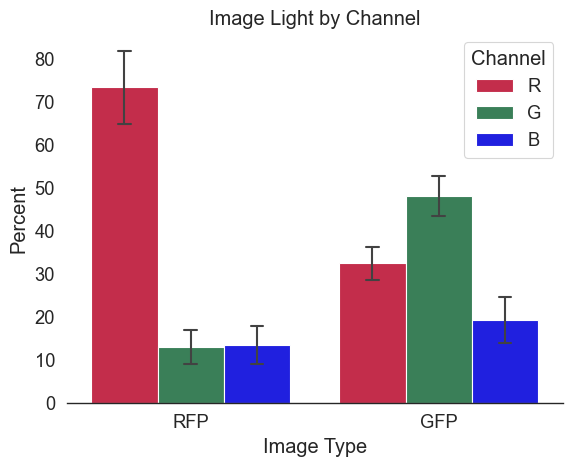

In [13]:
sns.set_theme(context='paper', style='white', font_scale=1.5)
colors = ['crimson', 'seagreen','blue']
sns.set_palette(sns.color_palette(colors))
sns.barplot(data=rgb_df_cleaned_iqr_melt, x='Image Type', y='Percent',  hue='Channel', errorbar='sd', errwidth=1.5, capsize=0.05)
sns.despine(left=True)
plt.title('Image Light by Channel')
plt.savefig('rgb_barplot.svg', dpi=300)



### Conclusions

We found that 32.5% ($\pm$ 3.8) of the light in GFP images was in the red channel compared to 48.2% ($\pm$ 4.7) in the green channel indicating substantial bleed-through. As a proof of concept, we also decomposed the RFP images to check for GFP bleed-through, we found that 73.5% ($\pm$ 8.8) of the light in RFP images came from the red channel, while only 13.0% ($\pm$ 4.0) was in the green channel, indicating relatively minimal bleed-through

## 3.0 Methods Comparison 🔬


## 3.1 Descriptive Statistics

### 3.1.1 Create a new Dataframe for Methods Comparison

In [14]:
# Make df copy with only the columns necessary for method comparison
df_c2 = df.copy()
columns = ['e_name','e_mut',        
        'rgb_rgb_limb_i_sum_norm', 'rgb_rgb_post_i_sum_norm', 'rgb_rgb_zpa_i_sum_norm',
        'g_rgb_limb_i_sum_norm', 'g_rgb_post_i_sum_norm', 'g_rgb_zpa_i_sum_norm',
        'g_r_limb_i_sum_norm', 'g_r_post_i_sum_norm', 'g_r_zpa_i_sum_norm',
        'rgb_rgb_limb_i_mean_norm', 'rgb_rgb_post_i_mean_norm', 'rgb_rgb_zpa_i_mean_norm',
        'g_rgb_limb_i_mean_norm', 'g_rgb_post_i_mean_norm', 'g_rgb_zpa_i_mean_norm',
        'g_r_limb_i_mean_norm', 'g_r_post_i_mean_norm', 'g_r_zpa_i_mean_norm',
        'rgb_rgb_limb_i_sum_norm_bg_sub', 'rgb_rgb_post_i_sum_norm_bg_sub', 'rgb_rgb_zpa_i_sum_norm_bg_sub',
        'g_rgb_limb_i_sum_norm_bg_sub', 'g_rgb_post_i_sum_norm_bg_sub', 'g_rgb_zpa_i_sum_norm_bg_sub',
        'g_r_limb_i_sum_norm_bg_sub', 'g_r_post_i_sum_norm_bg_sub', 'g_r_zpa_i_sum_norm_bg_sub',
        'rgb_rgb_limb_i_mean_norm_bg_sub', 'rgb_rgb_post_i_mean_norm_bg_sub', 'rgb_rgb_zpa_i_mean_norm_bg_sub',
        'g_rgb_limb_i_mean_norm_bg_sub', 'g_rgb_post_i_mean_norm_bg_sub', 'g_rgb_zpa_i_mean_norm_bg_sub',
        'g_r_limb_i_mean_norm_bg_sub', 'g_r_post_i_mean_norm_bg_sub', 'g_r_zpa_i_mean_norm_bg_sub'
        ]
method_df_raw = df_c2[columns]

# List of numerical columns for the following analysis
method_columns=[
        'rgb_rgb_limb_i_sum_norm', 'rgb_rgb_post_i_sum_norm', 'rgb_rgb_zpa_i_sum_norm',
        'g_rgb_limb_i_sum_norm', 'g_rgb_post_i_sum_norm', 'g_rgb_zpa_i_sum_norm',
        'g_r_limb_i_sum_norm', 'g_r_post_i_sum_norm', 'g_r_zpa_i_sum_norm',
        'rgb_rgb_limb_i_mean_norm', 'rgb_rgb_post_i_mean_norm', 'rgb_rgb_zpa_i_mean_norm',
        'g_rgb_limb_i_mean_norm', 'g_rgb_post_i_mean_norm', 'g_rgb_zpa_i_mean_norm',
        'g_r_limb_i_mean_norm', 'g_r_post_i_mean_norm', 'g_r_zpa_i_mean_norm',
        'rgb_rgb_limb_i_sum_norm_bg_sub', 'rgb_rgb_post_i_sum_norm_bg_sub', 'rgb_rgb_zpa_i_sum_norm_bg_sub',
        'g_rgb_limb_i_sum_norm_bg_sub', 'g_rgb_post_i_sum_norm_bg_sub', 'g_rgb_zpa_i_sum_norm_bg_sub',
        'g_r_limb_i_sum_norm_bg_sub', 'g_r_post_i_sum_norm_bg_sub', 'g_r_zpa_i_sum_norm_bg_sub',
        'rgb_rgb_limb_i_mean_norm_bg_sub', 'rgb_rgb_post_i_mean_norm_bg_sub', 'rgb_rgb_zpa_i_mean_norm_bg_sub',
        'g_rgb_limb_i_mean_norm_bg_sub', 'g_rgb_post_i_mean_norm_bg_sub', 'g_rgb_zpa_i_mean_norm_bg_sub',
        'g_r_limb_i_mean_norm_bg_sub', 'g_r_post_i_mean_norm_bg_sub', 'g_r_zpa_i_mean_norm_bg_sub',
        ]

### 3.1.2 Check distribution of raw data with histograms and Shapiro-Wilk test 

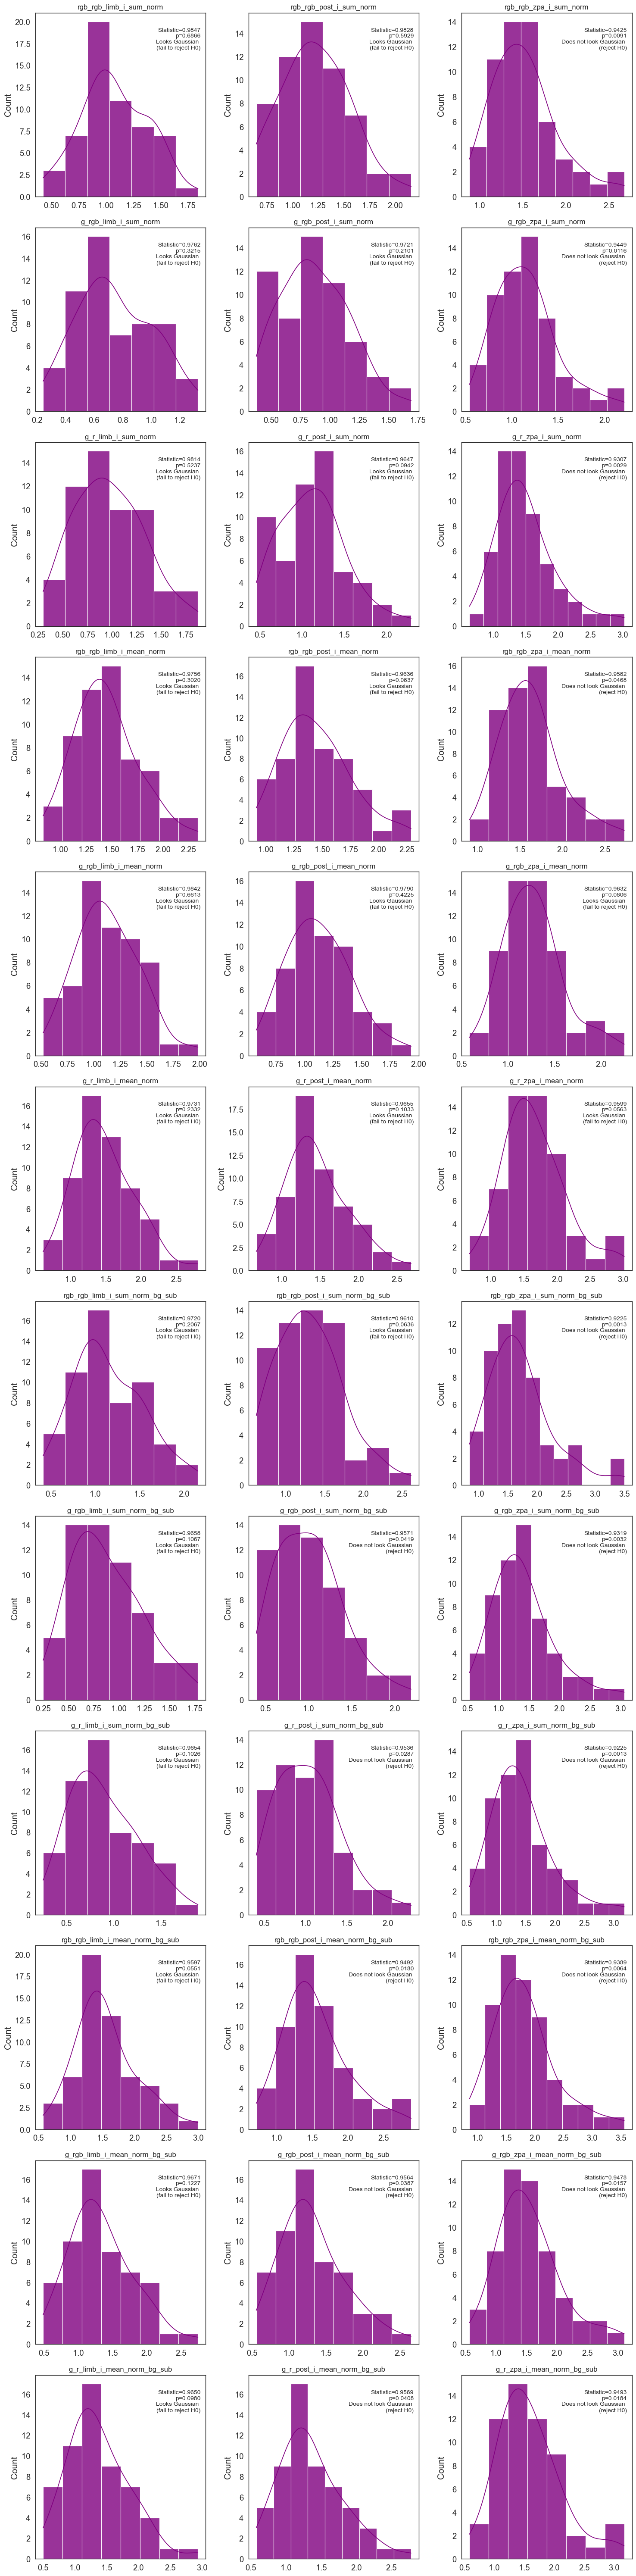

Method Name  Count      Mean       Std       Min  \
0           rgb_rgb_limb_i_sum_norm   57.0  1.077000  0.305304  0.422545   
1           rgb_rgb_post_i_sum_norm   57.0  1.229146  0.334117  0.647614   
2            rgb_rgb_zpa_i_sum_norm   57.0  1.523381  0.378992  0.880565   
3             g_rgb_limb_i_sum_norm   57.0  0.745244  0.265239  0.242059   
4             g_rgb_post_i_sum_norm   57.0  0.874837  0.294705  0.371686   
5              g_rgb_zpa_i_sum_norm   57.0  1.159974  0.341902  0.542390   
6               g_r_limb_i_sum_norm   57.0  0.967670  0.353668  0.300517   
7               g_r_post_i_sum_norm   57.0  1.124289  0.386630  0.455854   
8                g_r_zpa_i_sum_norm   57.0  1.503775  0.472721  0.628637   
9          rgb_rgb_limb_i_mean_norm   57.0  1.442083  0.311250  0.829750   
10         rgb_rgb_post_i_mean_norm   57.0  1.449171  0.309014  0.914833   
11          rgb_rgb_zpa_i_mean_norm   57.0  1.626442  0.367861  0.905859   
12           g_rgb_limb_i_mean_norm   57.0  1.128870  0.294712  0.520718   
13           g_rgb_post_i_mean_norm   57.0  1.128659  0.284546  0.576301   
14            g_rgb_zpa_i_mean_norm   57.0  1.271390  0.332184  0.583102   
15             g_r_limb_i_mean_norm   57.0  1.473150  0.424973  0.612262   
16             g_r_post_i_mean_norm   57.0  1.459092  0.406963  0.670166   
17              g_r_zpa_i_mean_norm   57.0  1.655116  0.470092  0.676181   
18   rgb_rgb_limb_i_sum_norm_bg_sub   57.0  1.148746  0.392931  0.413749   
19   rgb_rgb_post_i_sum_norm_bg_sub   57.0  1.311242  0.432878  0.618598   
20    rgb_rgb_zpa_i_sum_norm_bg_sub   57.0  1.699977  0.545149  0.837699   
21     g_rgb_limb_i_sum_norm_bg_sub   57.0  0.873138  0.353808  0.246998   
22     g_rgb_post_i_sum_norm_bg_sub   57.0  1.018690  0.391028  0.394299   
23      g_rgb_zpa_i_sum_norm_bg_sub   57.0  1.404570  0.503876  0.527877   
24       g_r_limb_i_sum_norm_bg_sub   57.0  0.895393  0.364422  0.254581   
25       g_r_post_i_sum_norm_bg_sub   57.0  1.044953  0.403496  0.404363   
26        g_r_zpa_i_sum_norm_bg_sub   57.0  1.438543  0.522415  0.543472   
27  rgb_rgb_limb_i_mean_norm_bg_sub   57.0  1.549573  0.478501  0.571041   
28  rgb_rgb_post_i_mean_norm_bg_sub   57.0  1.552825  0.462372  0.718776   
29   rgb_rgb_zpa_i_mean_norm_bg_sub   57.0  1.816584  0.552187  0.861761   
30    g_rgb_limb_i_mean_norm_bg_sub   57.0  1.335268  0.464781  0.486173   
31    g_rgb_post_i_mean_norm_bg_sub   57.0  1.324359  0.441804  0.558588   
32     g_rgb_zpa_i_mean_norm_bg_sub   57.0  1.541791  0.514699  0.567499   
33      g_r_limb_i_mean_norm_bg_sub   57.0  1.370864  0.480009  0.498568   
34      g_r_post_i_mean_norm_bg_sub   57.0  1.359552  0.454727  0.574838   
35       g_r_zpa_i_mean_norm_bg_sub   57.0  1.583802  0.530501  0.584576   

         25%       50%       75%       Max  Alpha  Shapiro W  Shapiro p  \
0   0.863755  1.011446  1.338402  1.841357   0.05   0.984714   0.686579   
1   1.017294  1.227194  1.435316  2.153630   0.05   0.982819   0.592908   
2   1.265802  1.441869  1.669237  2.678795   0.05   0.942535   0.009145   
3   0.546802  0.697340  0.968870  1.328037   0.05   0.976221   0.321544   
4   0.699025  0.832092  1.069803  1.691617   0.05   0.972109   0.210068   
5   0.914879  1.118803  1.316471  2.214254   0.05   0.944899   0.011621   
6   0.677573  0.920036  1.229240  1.872432   0.05   0.981357   0.523722   
7   0.855649  1.108064  1.346461  2.290086   0.05   0.964655   0.094217   
8   1.226358  1.466017  1.668726  3.027816   0.05   0.930736   0.002881   
9   1.219575  1.412766  1.614384  2.342519   0.05   0.975603   0.302027   
10  1.263090  1.382815  1.612387  2.288120   0.05   0.963560   0.083676   
11  1.371088  1.595321  1.810502  2.725865   0.05   0.958172   0.046757   
12  0.919923  1.097990  1.302545  1.982267   0.05   0.984206   0.661262   
13  0.930785  1.092610  1.298237  1.936197   0.05   0.979009   0.422545   
14  1.034166  1.246887  1.451346  2.249597   0.05   0.963220   0.080646   
15  1.20148

In [15]:
def method_descriptive_stats(df, columns, alpha=0.05, num_cols=3, hist_colors=None):
    num_selected_cols = len(columns)
    num_rows = (num_selected_cols + num_cols - 1) // num_cols

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    result = []

    for i, col in enumerate(columns):
        if col not in df.columns:
            continue

        treatment_group = df[col]
        descriptive_stats = treatment_group.describe()
        shapiro_stat, shapiro_p = shapiro(treatment_group)

        interpretation = 'Distribution looks Gaussian (fail to reject H0)' if shapiro_p > alpha else 'Distribution does not look Gaussian (reject H0)'
        interp = 'Looks Gaussian \n(fail to reject H0)' if shapiro_p > alpha else 'Does not look Gaussian \n(reject H0)'

        row = {
            'Method Name': col,
            'Count': descriptive_stats['count'],
            'Mean': descriptive_stats['mean'],
            'Std': descriptive_stats['std'],
            'Min': descriptive_stats['min'],
            '25%': descriptive_stats['25%'],
            '50%': descriptive_stats['50%'],
            '75%': descriptive_stats['75%'],
            'Max': descriptive_stats['max'],
            'Alpha': alpha,
            'Shapiro W': shapiro_stat,
            'Shapiro p': shapiro_p,
            'Interpretation': interpretation
        }
        result.append(row)

        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        # Set histogram color if specified
        color_index = i % len(hist_colors) if hist_colors else 0
        color = hist_colors[color_index] if hist_colors else 'purple'
        
        sns.histplot(data=treatment_group, kde=True, color=color, alpha=0.8, ax=ax)
        ax.set_title(col, fontsize=12)
        ax.set_xlabel('')
        ax.text(0.97, 0.92, f'Statistic={shapiro_stat:.4f}\np={shapiro_p:.4f}\n{interp}',
                fontsize=10, ha='right', va='top', transform=ax.transAxes)

    # Remove empty subplots
    if num_selected_cols < num_rows * num_cols:
        for i in range(num_selected_cols, num_rows * num_cols):
            axs.flat[i].set_visible(False)

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(result)


# To make a figure title
#   fig.suptitle('Histograms with Shapiro-Wilk Test', fontsize=16)
#   plt.tight_layout()
#   plt.subplots_adjust(top=0.97)
#   plt.show()


result_df = method_descriptive_stats(method_df_raw, method_columns)
result_df
# result_df.to_csv('method_raw_descriptive_stats.csv', index=False)


### 3.1.3 Visualize raw data with box and swarm plots

Melt data to reshape for stats and plotting 🫠

In [16]:
method_df_raw_melt= method_df_raw.melt(id_vars='e_mut', value_vars=method_columns, var_name='Method', value_name='Normalized Intensity')
method_df_raw_melt


e_mut                      Method  Normalized Intensity
0     cZRS_WT     rgb_rgb_limb_i_sum_norm              0.839370
1     cZRS_WT     rgb_rgb_limb_i_sum_norm              0.854321
2     cZRS_WT     rgb_rgb_limb_i_sum_norm              1.452106
3     cZRS_WT     rgb_rgb_limb_i_sum_norm              0.863755
4     cZRS_WT     rgb_rgb_limb_i_sum_norm              0.629546
...       ...                         ...                   ...
2047  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.044901
2048  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.044497
2049  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              2.551727
2050  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.533323
2051  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.977291

[2052 rows x 3 columns]

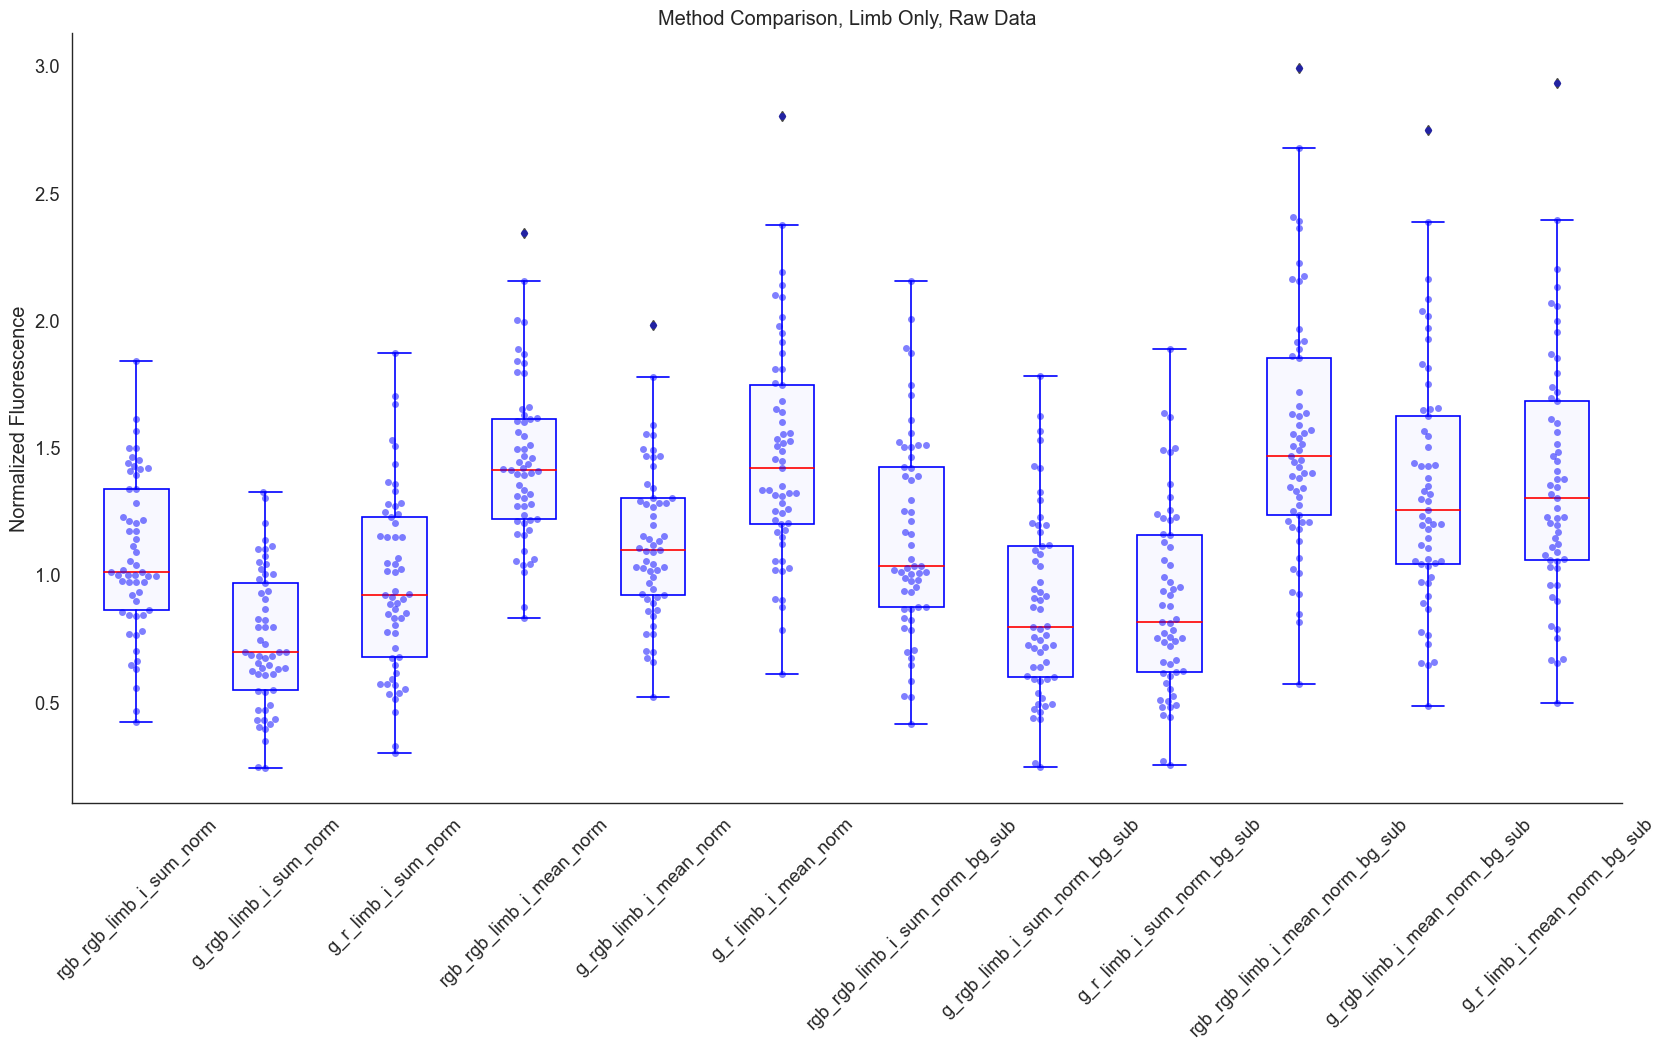

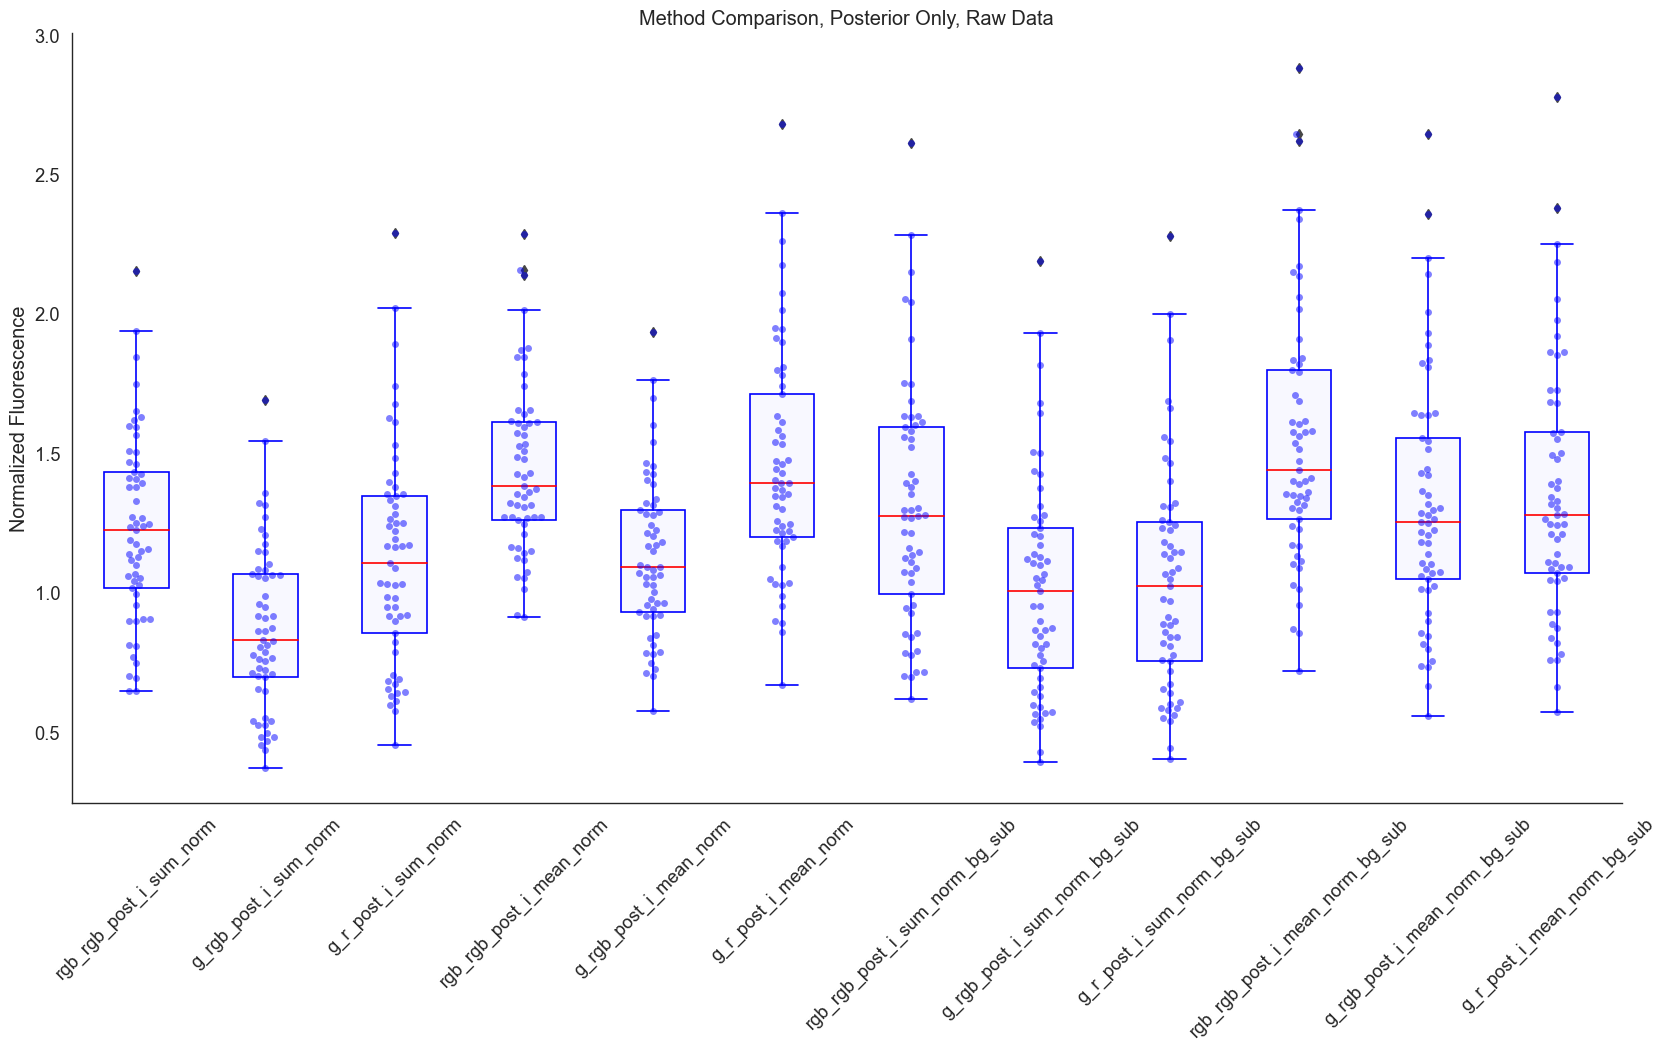

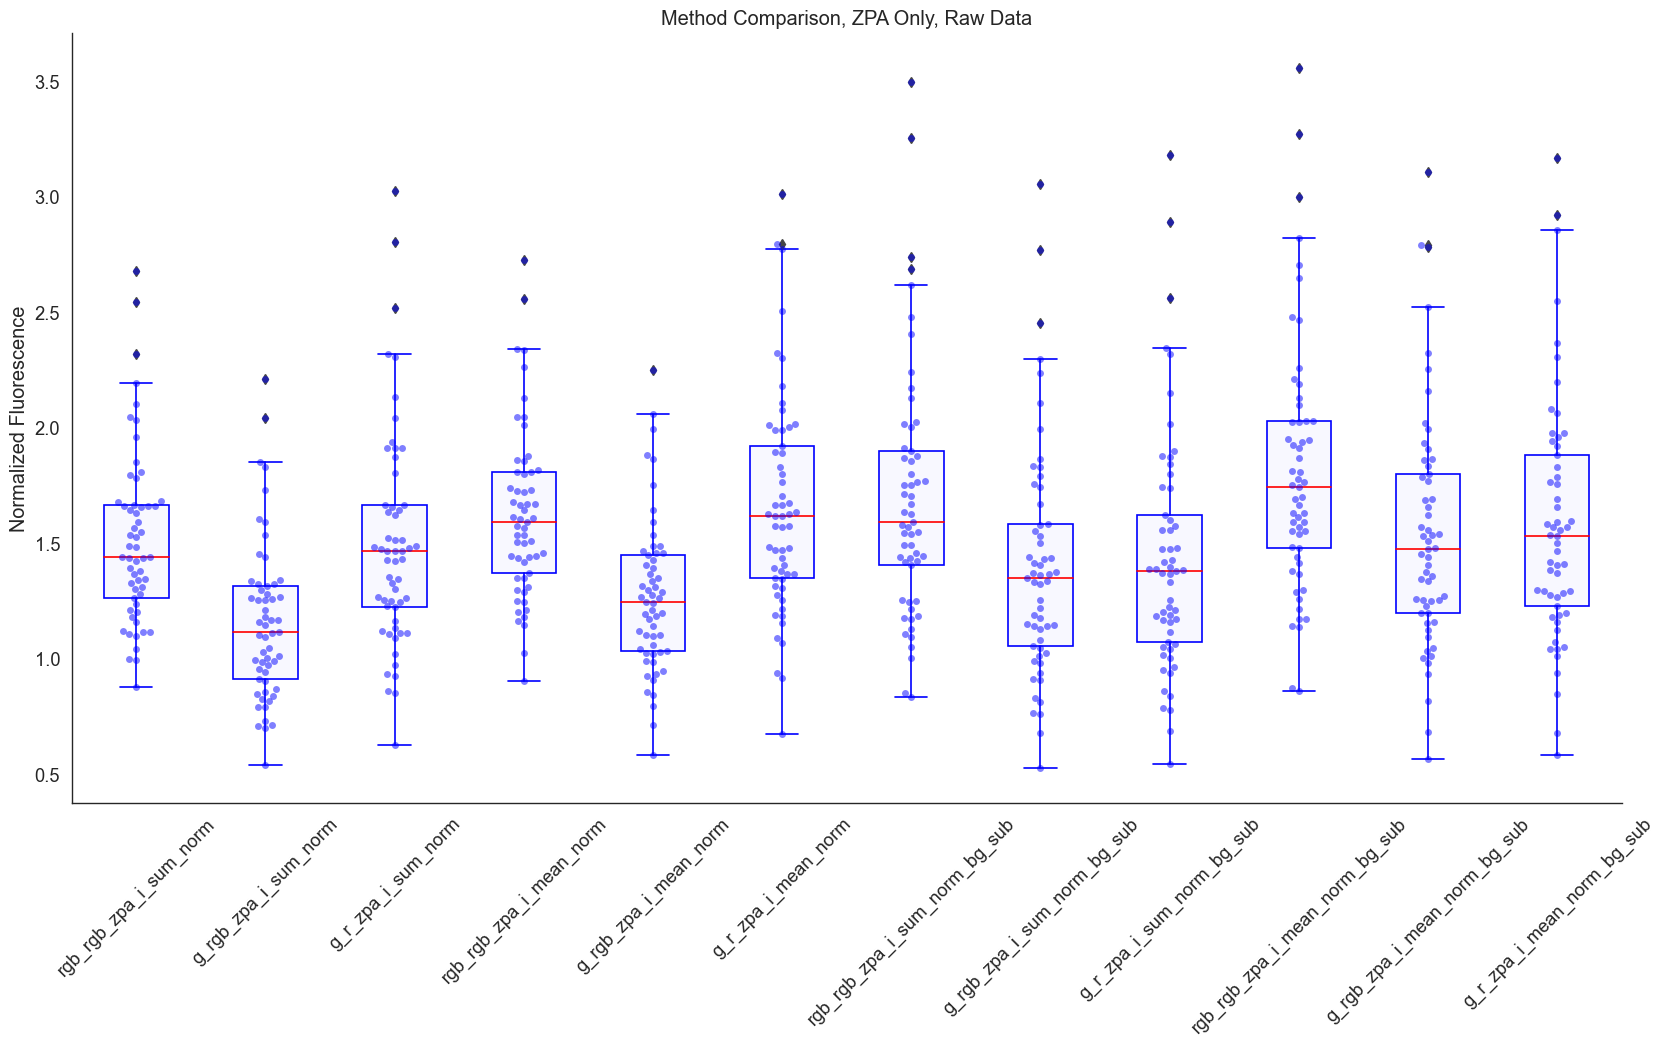

In [17]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='blue'):
        pairs = list(combinations(order, 2))
        plt.figure(figsize=(20, 10))
        plt.rcParams.update({'font.size': 16})
        
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': 'red'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        # Annotate with Kruskal-Wallis Test
        # annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.configure(test='Kruskal', text_format='star', loc='inside')
        # annotator.apply_and_annotate() 

        # Annotate with Kolmogorov-Smirnov Test
        # custom_long_name = 'Kolmogorov-Smirnov Test'
        # custom_short_name = 'KStest'
        # custom_func = kstest
        # custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

        # annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.reset_configuration()
        # annotator.new_plot(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.configure(test=custom_test, comparisons_correction=None,
        #             text_format='star').apply_and_annotate()

        # mut_dict = {'rgb_limb_i_sum_norm': 'RGB Limb', 'g_limb_i_sum_norm':'G Limb', 'rgb_post_i_sum_norm':'RGB Post',
        #             'g_post_i_sum_norm':'G Post', 'rgb_zpa_i_sum_norm':'RGB ZPA',  'g_zpa_i_sum_norm':'G ZPA'}
        # label_list = [mut_dict[i] for i in order]
        plt.title(ptitle)
        ax.set_xticklabels(order, rotation=45)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence')
        plt.show()
        #plt.savefig('Fig_Name.png')


limb = ['rgb_rgb_limb_i_sum_norm',
        'g_rgb_limb_i_sum_norm', 
        'g_r_limb_i_sum_norm', 
        'rgb_rgb_limb_i_mean_norm',
        'g_rgb_limb_i_mean_norm', 
        'g_r_limb_i_mean_norm',
        'rgb_rgb_limb_i_sum_norm_bg_sub',
        'g_rgb_limb_i_sum_norm_bg_sub',
        'g_r_limb_i_sum_norm_bg_sub', 
        'rgb_rgb_limb_i_mean_norm_bg_sub',
        'g_rgb_limb_i_mean_norm_bg_sub',
        'g_r_limb_i_mean_norm_bg_sub'
        ]

post = ['rgb_rgb_post_i_sum_norm',
        'g_rgb_post_i_sum_norm', 
        'g_r_post_i_sum_norm', 
        'rgb_rgb_post_i_mean_norm',
        'g_rgb_post_i_mean_norm', 
        'g_r_post_i_mean_norm',
        'rgb_rgb_post_i_sum_norm_bg_sub',
        'g_rgb_post_i_sum_norm_bg_sub',
        'g_r_post_i_sum_norm_bg_sub', 
        'rgb_rgb_post_i_mean_norm_bg_sub',
        'g_rgb_post_i_mean_norm_bg_sub',
        'g_r_post_i_mean_norm_bg_sub']

zpa = ['rgb_rgb_zpa_i_sum_norm',
        'g_rgb_zpa_i_sum_norm', 
        'g_r_zpa_i_sum_norm', 
        'rgb_rgb_zpa_i_mean_norm',
        'g_rgb_zpa_i_mean_norm', 
        'g_r_zpa_i_mean_norm',
        'rgb_rgb_zpa_i_sum_norm_bg_sub',
        'g_rgb_zpa_i_sum_norm_bg_sub',
        'g_r_zpa_i_sum_norm_bg_sub', 
        'rgb_rgb_zpa_i_mean_norm_bg_sub',
        'g_rgb_zpa_i_mean_norm_bg_sub',
        'g_r_zpa_i_mean_norm_bg_sub']


box_swarm_plot(method_df_raw_melt, limb, 'Method', 'Normalized Intensity', 'Method Comparison, Limb Only, Raw Data')
box_swarm_plot(method_df_raw_melt, post,'Method', 'Normalized Intensity', 'Method Comparison, Posterior Only, Raw Data')
box_swarm_plot(method_df_raw_melt, zpa, 'Method', 'Normalized Intensity', 'Method Comparison, ZPA Only, Raw Data')


In general, it appears that most data groups are normally distributed, though groups using the Posterior ROI have more outliers than those using the Limb ROI, and groups with the ZPA ROI have more outliers than either the Limb or Posterior methods.

### 3.1.4 Outlier Test Comparison

In [18]:
"""
Grubbs' test for Outliers

Assumptions:
    Normal Distribution
    Hypothesis-based test that tests for only one outlier at a time 
        (not good for data with more than one outlier)
"""

def remove_outliers_Grubbs(df, columns, alpha=0.05):
    df_cleaned = df.copy()
    indices_to_drop = []
    
    for col in columns:
        values = df[col].values
        n = len(values)
        mean = np.mean(values)
        std = np.std(values)
        
        if n < 3:
            continue
        
        # Calculate Grubb's test statistic (Two-tailed)
        test_statistic = np.abs(values - mean) / std

        # Calculate Grubb's critical value
        t_value = stats.t.ppf(1 - alpha / (2 * n), n - 2)
        g_critical = (n - 1) / np.sqrt(n) * np.sqrt(t_value ** 2 / (n - 2 + t_value ** 2))

        # Find outliers
        outliers = np.where(test_statistic > g_critical)[0]
        indices_to_drop.extend(outliers)
    print(indices_to_drop)
    df_cleaned = df_cleaned.drop(indices_to_drop)
    
    return df_cleaned

# method_df_cleaned_grubbs = remove_outliers_Grubbs(method_df_raw, method_columns)
# method_df_cleaned_grubbs
# method_df_cleaned_grubbs.to_csv('method_df_cleaned_grubbs.csv', index=False)

# Returns rows:
# outliers_grubbs = [35, 35, 35, 35, 35, 43]


In [19]:
"""
Z-Score Test for Outliers

Assumptions:
    Normal Distribution
    Mean-based
    Susceptible to extreme outliers
    Threshold is usually set at +/-3
"""

def remove_outliers_zscore(df, columns, threshold=3):
    df_cleaned = df.copy()
    indices_to_drop = []
    
    for col in columns:
        values = df[col].values
        z_score = stats.zscore(values)
        outliers= np.where(np.abs(z_score) > threshold)[0]
        indices_to_drop.extend(outliers)   
    print(indices_to_drop)
    df_cleaned = df_cleaned.drop(indices_to_drop)

    return df_cleaned


# method_df_cleaned_zscore = remove_outliers_zscore(method_df_raw, method_columns)
# method_df_cleaned_zscore
# method_df_cleaned_zscore.to_csv('method_df_cleaned_zscore.csv', index=False)

# Returns rows:
# outliers_z_score = [35, 35, 33, 35, 35, 43, 43, 33, 35, 33, 35, 33, 35, 43, 35, 43, 43, 35, 43, 43, 35]

In [20]:
"""
IQR Method
Assumptions: 
    Does NOT assume normal distribution
    The '1.5' is the range, it would be different for something like exponential data
    Is based on median, not mean
    Is robust against outlier influence

"""

def remove_outliers_iqr(df, columns, multiplier=1.5): #Most common multiplier values are 1.5 followed by 1.7
    df_cleaned = df.copy()
    indices_to_drop = []
    
    for col in columns:
        values = df[col].values
        q3, q1 = np.percentile(values, [75,25])
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-multiplier*iqr
        fence_high = q3+multiplier*iqr
        outliers= np.where((values < fence_low) | (fence_high < values))[0]
        indices_to_drop.extend(outliers)
        
    print(indices_to_drop)
    df_cleaned = df_cleaned.drop(indices_to_drop)

    return df_cleaned


method_df_cleaned_iqr = remove_outliers_iqr(method_df_raw, method_columns)
method_df_cleaned_iqr
method_df_cleaned_iqr.to_csv('method_df_cleaned_iqr.csv', index=False)

# Returns rows:
# outliers_iqr = [33, 33, 34, 35, 33, 33, 35, 33, 33, 35, 54, 43, 33, 43, 54, 33, 35, 43, 43, 35, 43, 43, 35, 43, 33, 33, 34, 35, 54, 33, 33, 35, 54, 33, 33, 35, 54, 43, 33, 43, 54, 33, 35, 43, 43, 43, 54, 33, 35, 43, 43, 43, 54, 35, 43]

[33, 33, 34, 35, 33, 33, 35, 33, 33, 35, 54, 43, 33, 43, 54, 33, 35, 43, 43, 35, 43, 43, 35, 43, 33, 33, 34, 35, 54, 33, 33, 35, 54, 33, 33, 35, 54, 43, 33, 43, 54, 33, 35, 43, 43, 43, 54, 33, 35, 43, 43, 43, 54, 35, 43]


In [21]:
"""
Median Absolute Deviation (MAD) Z-Score Method
Assumptions: 
    Data are independent and identically distributed (iid)
    Unimodal distribution
    Most data points are not outliers

"""


def remove_outliers_mad(df, columns, threshold=3.5): #Threshold can be 3.0 or 3.5
    df_cleaned = df.copy()
    indices_to_drop = []
    
    for col in columns:
        values = df[col].values
        median = np.median(values)
        mad = median_abs_deviation(values)

        #This way of using thresholds is more stringent
        # outlier_threshold = threshold * mad
        # outliers = np.where(np.abs(values - median) > outlier_threshold)[0]

        #This way of using thresholds is less stringent, but seems closer to what is in the literature
        z_scores = 0.6745 * (values - median) / mad
        outliers = np.where(np.abs(z_scores) > threshold)[0]
        indices_to_drop.extend(outliers)
    print(indices_to_drop)
    df_cleaned = df_cleaned.drop(indices_to_drop)

    return df_cleaned


# method_df_cleaned_mad = remove_outliers_mad(method_df_raw, method_columns)
# method_df_cleaned_mad
# method_df_cleaned_mad.to_csv('method_df_cleaned_mad.csv', index=False)

# Returns rows:
# mad_stringent_3_5 = [44, 33, 33, 34, 35, 33, 33, 34, 35, 33, 35, 0, 21, 33, 34, 35, 54, 43, 54, 33, 43, 33, 35, 43, 54, 43, 54, 33, 35, 43, 43, 54, 33, 43, 47, 54, 33, 35, 43, 44, 54, 33, 33, 34, 35, 54, 54, 33, 35, 33, 35, 54, 54, 33, 35, 33, 35, 54, 33, 35, 43, 54, 33, 43, 54, 33, 35, 43, 54, 43, 54, 33, 43, 47, 54, 33, 35, 43, 43, 54, 33, 43, 47, 54, 33, 35, 43]
# mad_not_stringent_3_5 = [35, 35, 33, 35, 35, 43, 43, 33, 35, 35, 35, 43, 43, 33, 35, 43, 43, 35, 43, 43]
# mad_stringent_3_0 = [44, 33, 35, 33, 34, 35, 54, 54, 33, 35, 21, 33, 34, 35, 54, 54, 33, 35, 54, 0, 21, 33, 34, 35, 54, 35, 43, 54, 33, 43, 54, 0, 33, 34, 35, 43, 54, 0, 43, 54, 33, 43, 54, 0, 33, 35, 43, 0, 43, 47, 54, 0, 33, 35, 43, 47, 54, 0, 33, 35, 43, 54, 33, 43, 44, 54, 33, 35, 21, 33, 34, 35, 54, 44, 54, 33, 35, 54, 21, 33, 34, 35, 54, 33, 44, 54, 33, 35, 54, 21, 33, 34, 35, 54, 5, 33, 35, 43, 47, 54, 33, 35, 43, 47, 54, 0, 10, 21, 33, 34, 35, 43, 54, 43, 47, 54, 33, 35, 43, 47, 54, 33, 35, 43, 54, 43, 47, 54, 33, 35, 43, 47, 54, 33, 35, 43, 54]
# mad_not_stringent_3_0 = [33, 35, 33, 35, 33, 33, 35, 43, 33, 35, 43, 43, 35, 43, 43, 35, 44, 33, 35, 33, 33, 35, 33, 33, 35, 43, 54, 43, 54, 33, 35, 43, 43, 54, 35, 43, 43, 54, 35]

In [22]:
outliers_grubbs = [35, 35, 35, 35, 35, 43]
outliers_z_score = [35, 35, 33, 35, 35, 43, 43, 33, 35, 33, 35, 33, 35, 43, 35, 43, 43, 35, 43, 43, 35]
outliers_iqr = [33, 33, 34, 35, 33, 33, 35, 33, 33, 35, 54, 43, 33, 43, 54, 33, 35, 43, 43, 35, 43, 43, 35, 43, 33, 33, 34, 35, 54, 33, 33, 35, 54, 33, 33, 35, 54, 43, 33, 43, 54, 33, 35, 43, 43, 43, 54, 33, 35, 43, 43, 43, 54, 35, 43]
outliers_mad_stringent_3_5 = [44, 33, 33, 34, 35, 33, 33, 34, 35, 33, 35, 0, 21, 33, 34, 35, 54, 43, 54, 33, 43, 33, 35, 43, 54, 43, 54, 33, 35, 43, 43, 54, 33, 43, 47, 54, 33, 35, 43, 44, 54, 33, 33, 34, 35, 54, 54, 33, 35, 33, 35, 54, 54, 33, 35, 33, 35, 54, 33, 35, 43, 54, 33, 43, 54, 33, 35, 43, 54, 43, 54, 33, 43, 47, 54, 33, 35, 43, 43, 54, 33, 43, 47, 54, 33, 35, 43]
outliers_mad_not_stringent_3_5 = [35, 35, 33, 35, 35, 43, 43, 33, 35, 35, 35, 43, 43, 33, 35, 43, 43, 35, 43, 43]
outliers_mad_stringent_3_0 = [44, 33, 35, 33, 34, 35, 54, 54, 33, 35, 21, 33, 34, 35, 54, 54, 33, 35, 54, 0, 21, 33, 34, 35, 54, 35, 43, 54, 33, 43, 54, 0, 33, 34, 35, 43, 54, 0, 43, 54, 33, 43, 54, 0, 33, 35, 43, 0, 43, 47, 54, 0, 33, 35, 43, 47, 54, 0, 33, 35, 43, 54, 33, 43, 44, 54, 33, 35, 21, 33, 34, 35, 54, 44, 54, 33, 35, 54, 21, 33, 34, 35, 54, 33, 44, 54, 33, 35, 54, 21, 33, 34, 35, 54, 5, 33, 35, 43, 47, 54, 33, 35, 43, 47, 54, 0, 10, 21, 33, 34, 35, 43, 54, 43, 47, 54, 33, 35, 43, 47, 54, 33, 35, 43, 54, 43, 47, 54, 33, 35, 43, 47, 54, 33, 35, 43, 54]
outliers_mad_not_stringent_3_0 = [33, 35, 33, 35, 33, 33, 35, 43, 33, 35, 43, 43, 35, 43, 43, 35, 44, 33, 35, 33, 33, 35, 33, 33, 35, 43, 54, 43, 54, 33, 35, 43, 43, 54, 35, 43, 43, 54, 35]

outlier_lists = [outliers_grubbs, outliers_z_score, outliers_iqr, outliers_mad_stringent_3_5, outliers_mad_not_stringent_3_5, outliers_mad_stringent_3_0, outliers_mad_not_stringent_3_0]

outliers_combined = []
for x in outlier_lists: outliers_combined.extend(x)

unique_outliers_arr = np.unique(outliers_combined)
print(f'Unique Outliers: {unique_outliers_arr}')
print()
for row in unique_outliers_arr:
    print(f'Index {row} is: {df.loc[row][0]}')

outliers_combined_ser = pd.Series(outliers_combined)
count = outliers_combined_ser.value_counts()
ser = pd.Series(count)
# ser
# for row in unique_outliers_arr:
#     print(f'Index {row} is: {df.loc[row][0]}')
print()
print('Element Count')
print(count)

# Returns:
# Unique Outliers: [ 0  5 10 21 33 34 35 43 44 47 54]

# Index 0 is: 2020-02-11_E21 
# Index 5 is: 2020-10-20_E07
# Index 10 is: 2020-11-02_E04
# Index 21 is: 2021-02-01_E10
# Index 33 is: 2021-04-21_E02
# Index 34 is: 2021-04-28_E07
# Index 35 is: 2021-04-28_E08
# Index 43 is: 2021-10-04_E04
# Index 44 is: 2021-10-04_E09
# Index 47 is: 2021-11-01_E10
# Index 54 is: 2023-01-17_E24

# Element Count
# 35    88
# 33    86
# 43    79
# 54    62
# 34    14
# 47    11
# 0      9
# 44     7
# 21     7
# 5      1
# 10     1
# dtype: int64


Unique Outliers: [ 0  5 10 21 33 34 35 43 44 47 54]

Index 0 is: 2020-02-11_E21
Index 5 is: 2020-10-20_E07
Index 10 is: 2020-11-02_E04
Index 21 is: 2021-02-01_E10
Index 33 is: 2021-04-21_E02
Index 34 is: 2021-04-28_E07
Index 35 is: 2021-04-28_E08
Index 43 is: 2021-10-04_E04
Index 44 is: 2021-10-04_E09
Index 47 is: 2021-11-01_E10
Index 54 is: 2023-01-17_E24

Element Count
35    88
33    86
43    79
54    62
34    14
47    11
0      9
44     7
21     7
5      1
10     1
dtype: int64


* Index 0 is: 2020-02-11_E21, it was identified as an outlier 9 times, it's a very small limb, so may be an outlier
* Index 5 is: 2020-10-20_E07, it was identified as an outlier 1 times, it's intensity level is weak, but I do not think it's a true outlier.
* Index 10 is: 2020-11-02_E04, it was identified as an outlier 1 times, it's a small limb, and it's fluorescence is low it may be an outlier
* Index 21 is: 2021-02-01_E10, it was identified as an outlier 7 times, it's a good looking limb, but it's at an odd angle, so the Posterior and ZPA ROI methods may have trouble with it.
* Index 33 is: 2021-04-21_E02, it was identified as an outlier 86 times, this limb looks good, the posterior and ZPA ROI may not be the best
* Index 34 is: 2021-04-28_E07, it was identified as an outlier 14 times, this limb is bright, which is rare, but not necessarily bad.
* Index 35 is: 2021-04-28_E08, it was identified as an outlier 88 times, this limb is beautiful, maybe a bit on the bright side.
* Index 43 is: 2021-10-04_E04, it was identified as an outlier 79 times, RFP looks weak, transfection area is small
* Index 44 is: 2021-10-04_E09, it was identified as an outlier 7 times, this one looks ok, I don't think it's an outlier.
* Index 47 is: 2021-11-01_E10, it was identified as an outlier 11 times, area is small, but looks ok.
* Index 54 is: 2023-01-17_E24, it was identified as an outlier 62 times, the transfection and ROIs looks good, just a bit bright. 

_I think I should either use the IQR method or the MAD 3.5 not stringent. I don't want to be so stringent with my control, that I will have to exclude all my mutants when I get to that analysis._

### 3.1.5 Check distribution of cleaned data with histograms and Shapiro-Wilk test 

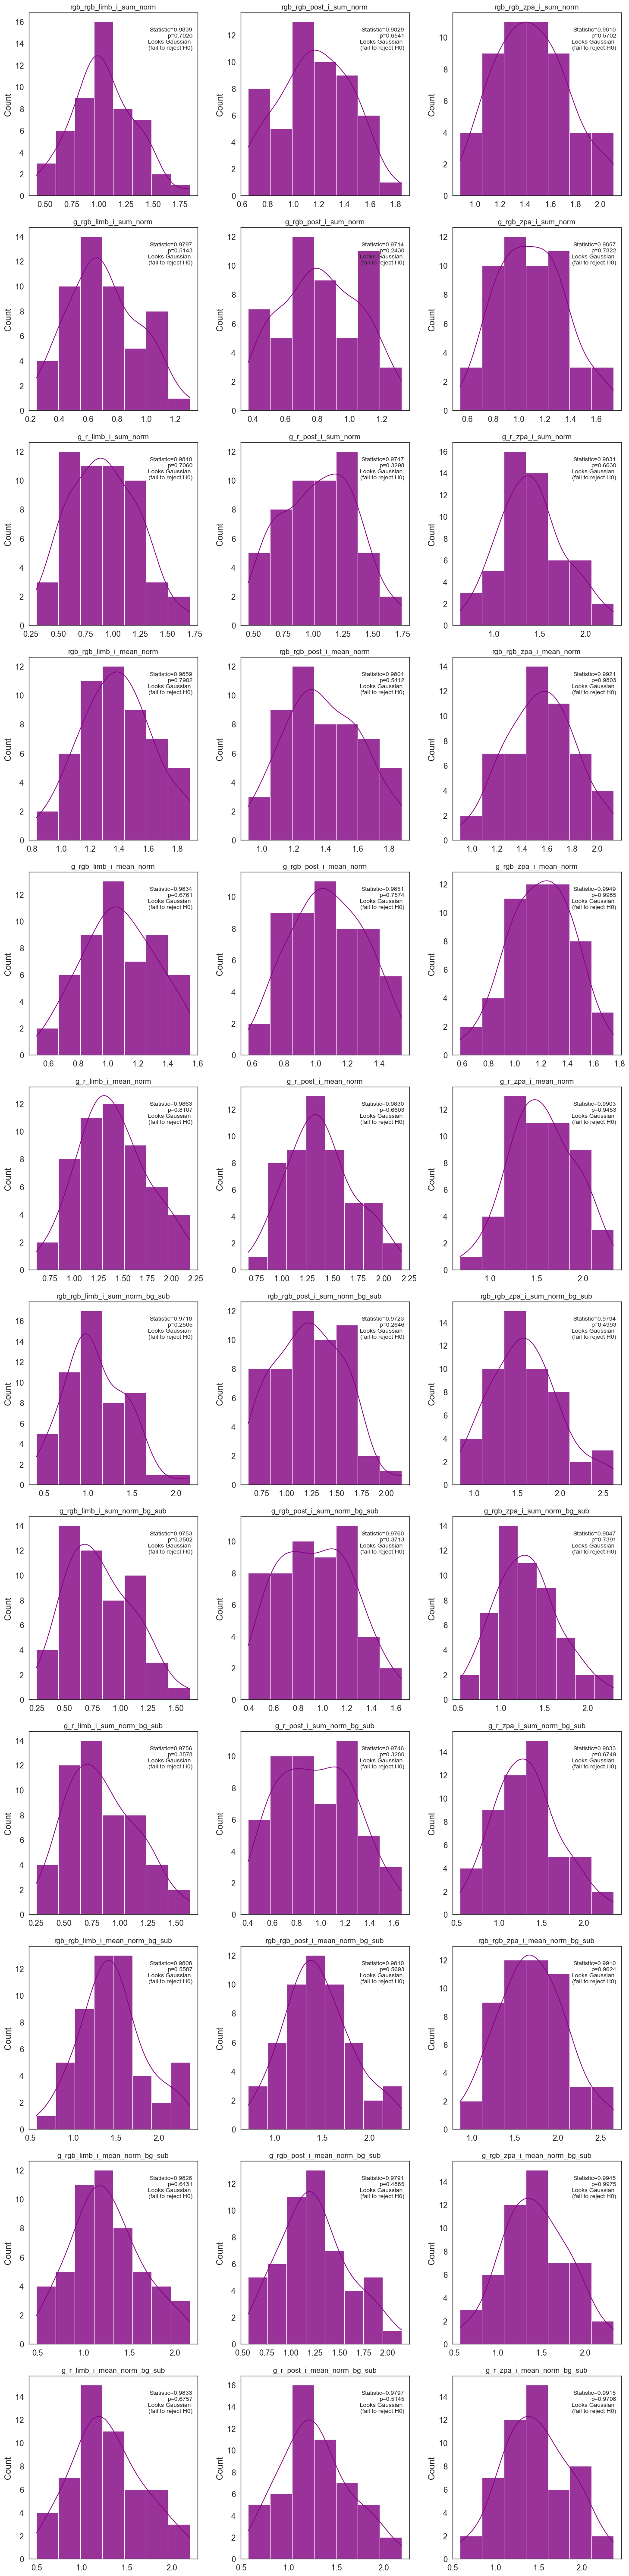

Method Name  Count      Mean       Std       Min  \
0           rgb_rgb_limb_i_sum_norm   52.0  1.036867  0.288005  0.422545   
1           rgb_rgb_post_i_sum_norm   52.0  1.171735  0.283671  0.647614   
2            rgb_rgb_zpa_i_sum_norm   52.0  1.450537  0.289661  0.880565   
3             g_rgb_limb_i_sum_norm   52.0  0.706896  0.242429  0.242059   
4             g_rgb_post_i_sum_norm   52.0  0.821623  0.244374  0.371686   
5              g_rgb_zpa_i_sum_norm   52.0  1.094661  0.261654  0.542390   
6               g_r_limb_i_sum_norm   52.0  0.912788  0.312089  0.300517   
7               g_r_post_i_sum_norm   52.0  1.050738  0.308130  0.455854   
8                g_r_zpa_i_sum_norm   52.0  1.411026  0.352144  0.628637   
9          rgb_rgb_limb_i_mean_norm   52.0  1.382771  0.249486  0.829750   
10         rgb_rgb_post_i_mean_norm   52.0  1.387514  0.241872  0.914833   
11          rgb_rgb_zpa_i_mean_norm   52.0  1.547667  0.271271  0.905859   
12           g_rgb_limb_i_mean_norm   52.0  1.077143  0.246169  0.520718   
13           g_rgb_post_i_mean_norm   52.0  1.074906  0.229357  0.576301   
14            g_rgb_zpa_i_mean_norm   52.0  1.200263  0.245887  0.583102   
15             g_r_limb_i_mean_norm   52.0  1.400958  0.354347  0.612262   
16             g_r_post_i_mean_norm   52.0  1.385459  0.330666  0.670166   
17              g_r_zpa_i_mean_norm   52.0  1.556613  0.351977  0.676181   
18   rgb_rgb_limb_i_sum_norm_bg_sub   52.0  1.086089  0.348078  0.413749   
19   rgb_rgb_post_i_sum_norm_bg_sub   52.0  1.227497  0.343860  0.618598   
20    rgb_rgb_zpa_i_sum_norm_bg_sub   52.0  1.588175  0.398322  0.837699   
21     g_rgb_limb_i_sum_norm_bg_sub   52.0  0.814304  0.304299  0.246998   
22     g_rgb_post_i_sum_norm_bg_sub   52.0  0.941114  0.304422  0.394299   
23      g_rgb_zpa_i_sum_norm_bg_sub   52.0  1.303607  0.374753  0.527877   
24       g_r_limb_i_sum_norm_bg_sub   52.0  0.833771  0.310204  0.254581   
25       g_r_post_i_sum_norm_bg_sub   52.0  0.964013  0.310565  0.404363   
26        g_r_zpa_i_sum_norm_bg_sub   52.0  1.332592  0.381219  0.543472   
27  rgb_rgb_limb_i_mean_norm_bg_sub   52.0  1.459399  0.381483  0.571041   
28  rgb_rgb_post_i_mean_norm_bg_sub   52.0  1.460966  0.358077  0.718776   
29   rgb_rgb_zpa_i_mean_norm_bg_sub   52.0  1.695764  0.394678  0.861761   
30    g_rgb_limb_i_mean_norm_bg_sub   52.0  1.255157  0.385931  0.486173   
31    g_rgb_post_i_mean_norm_bg_sub   52.0  1.242954  0.355069  0.558588   
32     g_rgb_zpa_i_mean_norm_bg_sub   52.0  1.431117  0.374853  0.567499   
33      g_r_limb_i_mean_norm_bg_sub   52.0  1.288414  0.395967  0.498568   
34      g_r_post_i_mean_norm_bg_sub   52.0  1.275874  0.364449  0.574838   
35       g_r_zpa_i_mean_norm_bg_sub   52.0  1.470570  0.388740  0.584576   

         25%       50%       75%       Max  Alpha  Shapiro W  Shapiro p  \
0   0.851814  1.000380  1.214720  1.841357   0.05   0.983913   0.702015   
1   0.986561  1.167636  1.397110  1.848160   0.05   0.982873   0.654061   
2   1.231771  1.435930  1.657756  2.104207   0.05   0.981022   0.570211   
3   0.543432  0.683163  0.875708  1.302515   0.05   0.979728   0.514305   
4   0.653556  0.808855  1.056996  1.324324   0.05   0.971443   0.243035   
5   0.896223  1.100450  1.271704  1.732966   0.05   0.985684   0.782160   
6   0.666762  0.899767  1.150517  1.705194   0.05   0.984000   0.706033   
7   0.816152  1.035282  1.270754  1.744302   0.05   0.974667   0.329793   
8   1.156185  1.426397  1.625833  2.306770   0.05   0.983066   0.662952   
9   1.215786  1.400437  1.551815  1.887626   0.05   0.985868   0.790220   
10  1.238016  1.360086  1.580043  1.877954   0.05   0.980358   0.541154   
11  1.351485  1.553145  1.729659  2.129960   0.05   0.992139   0.980342   
12  0.911364  1.072771  1.280755  1.549050   0.05   0.983351   0.676069   
13  0.921544  1.068411  1.252408  1.541113   0.05   0.985129   0.757448   
14  1.030950  1.206013  1.374408  1.753328   0.05   0.994873   0.998532   
15  1.17550

In [23]:
result_df = method_descriptive_stats(method_df_cleaned_iqr, method_columns)
result_df
# result_df.to_csv('method_cleaned_iqr_descriptive_stats.csv', index=False)

### 3.1.6 Visualize cleaned data with box and swarm plots

Melt data to reshape for stats and plotting 🫠

In [24]:
method_df_cleaned_iqr_melt= method_df_cleaned_iqr.melt(id_vars='e_mut', value_vars=method_columns, var_name='Method', value_name='Normalized Intensity')
method_df_cleaned_iqr_melt


e_mut                      Method  Normalized Intensity
0     cZRS_WT     rgb_rgb_limb_i_sum_norm              0.839370
1     cZRS_WT     rgb_rgb_limb_i_sum_norm              0.854321
2     cZRS_WT     rgb_rgb_limb_i_sum_norm              1.452106
3     cZRS_WT     rgb_rgb_limb_i_sum_norm              0.863755
4     cZRS_WT     rgb_rgb_limb_i_sum_norm              0.629546
...       ...                         ...                   ...
1867  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.292595
1868  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.044901
1869  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.044497
1870  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.533323
1871  cZRS_WT  g_r_zpa_i_mean_norm_bg_sub              1.977291

[1872 rows x 3 columns]

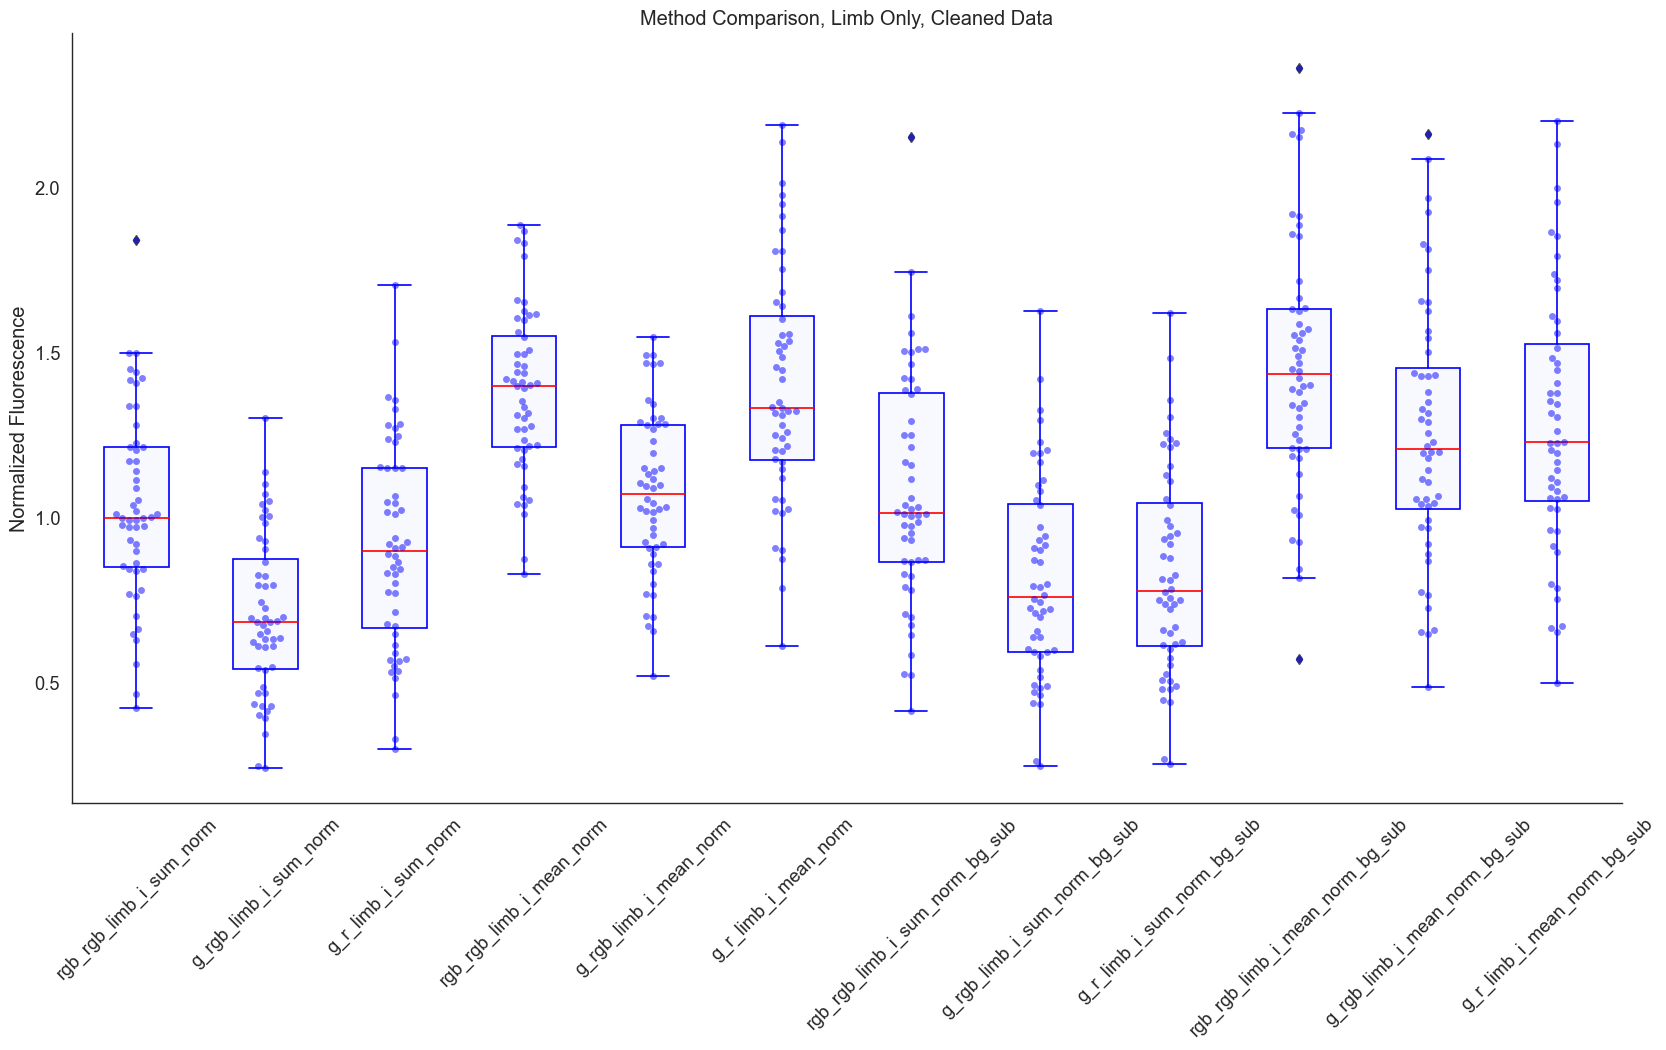

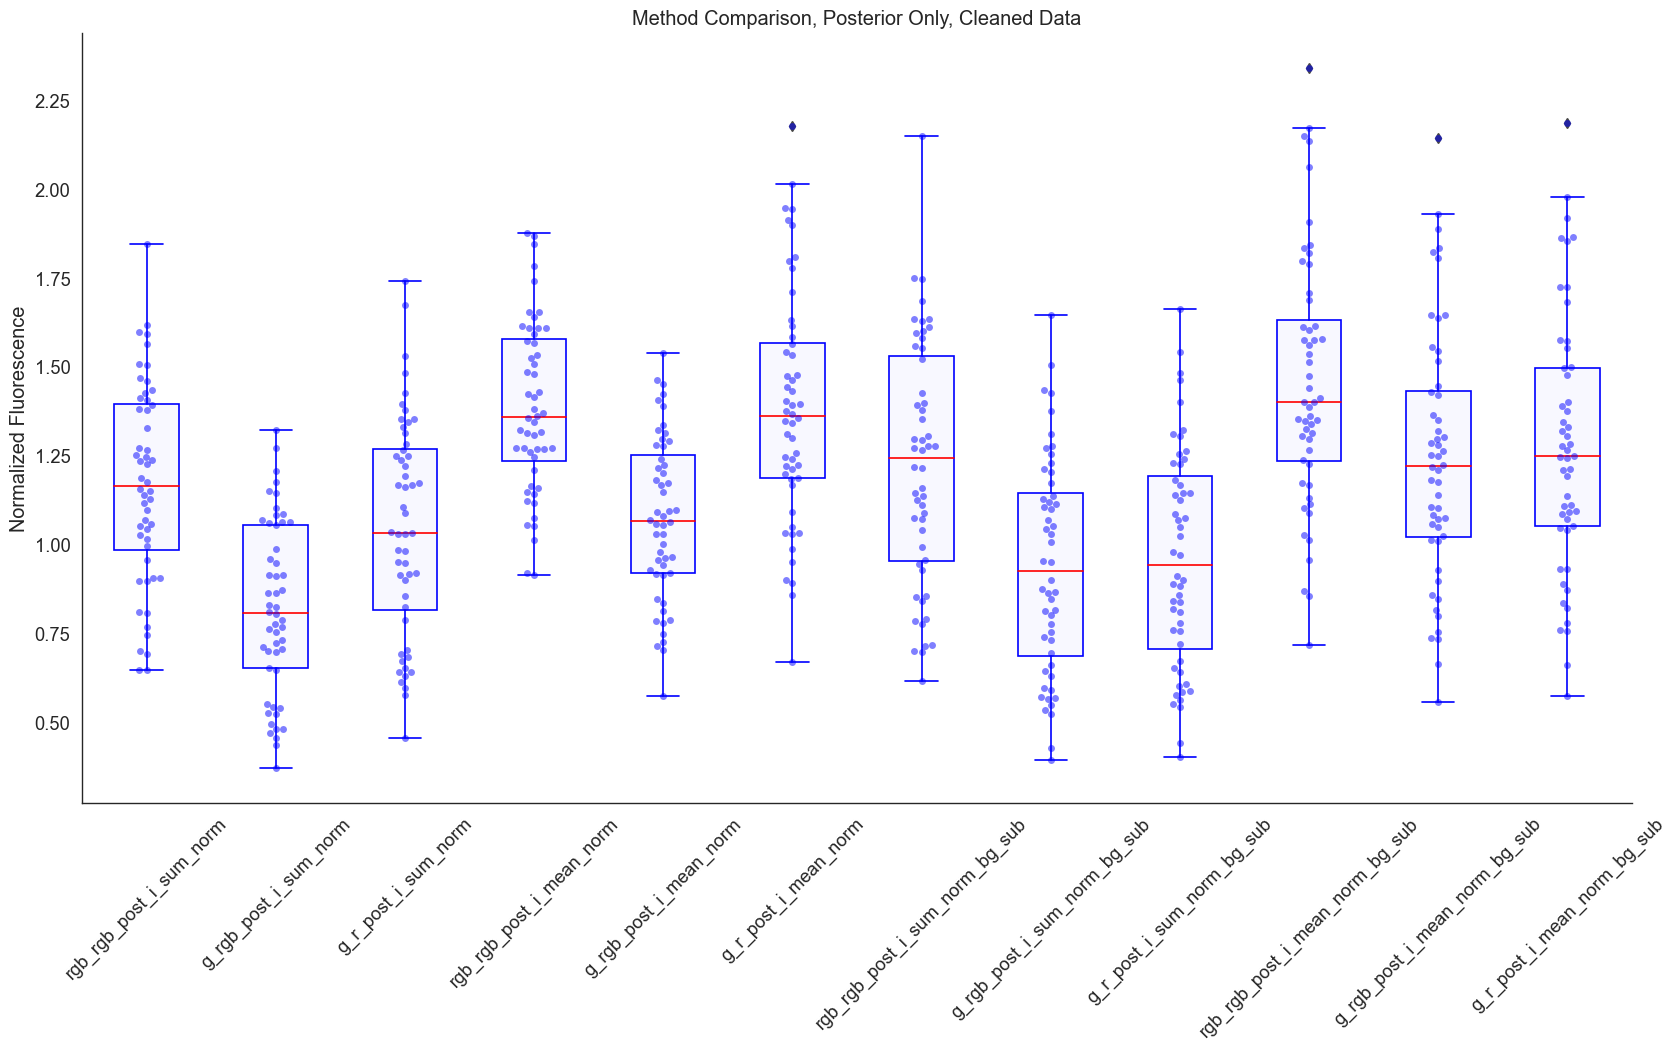

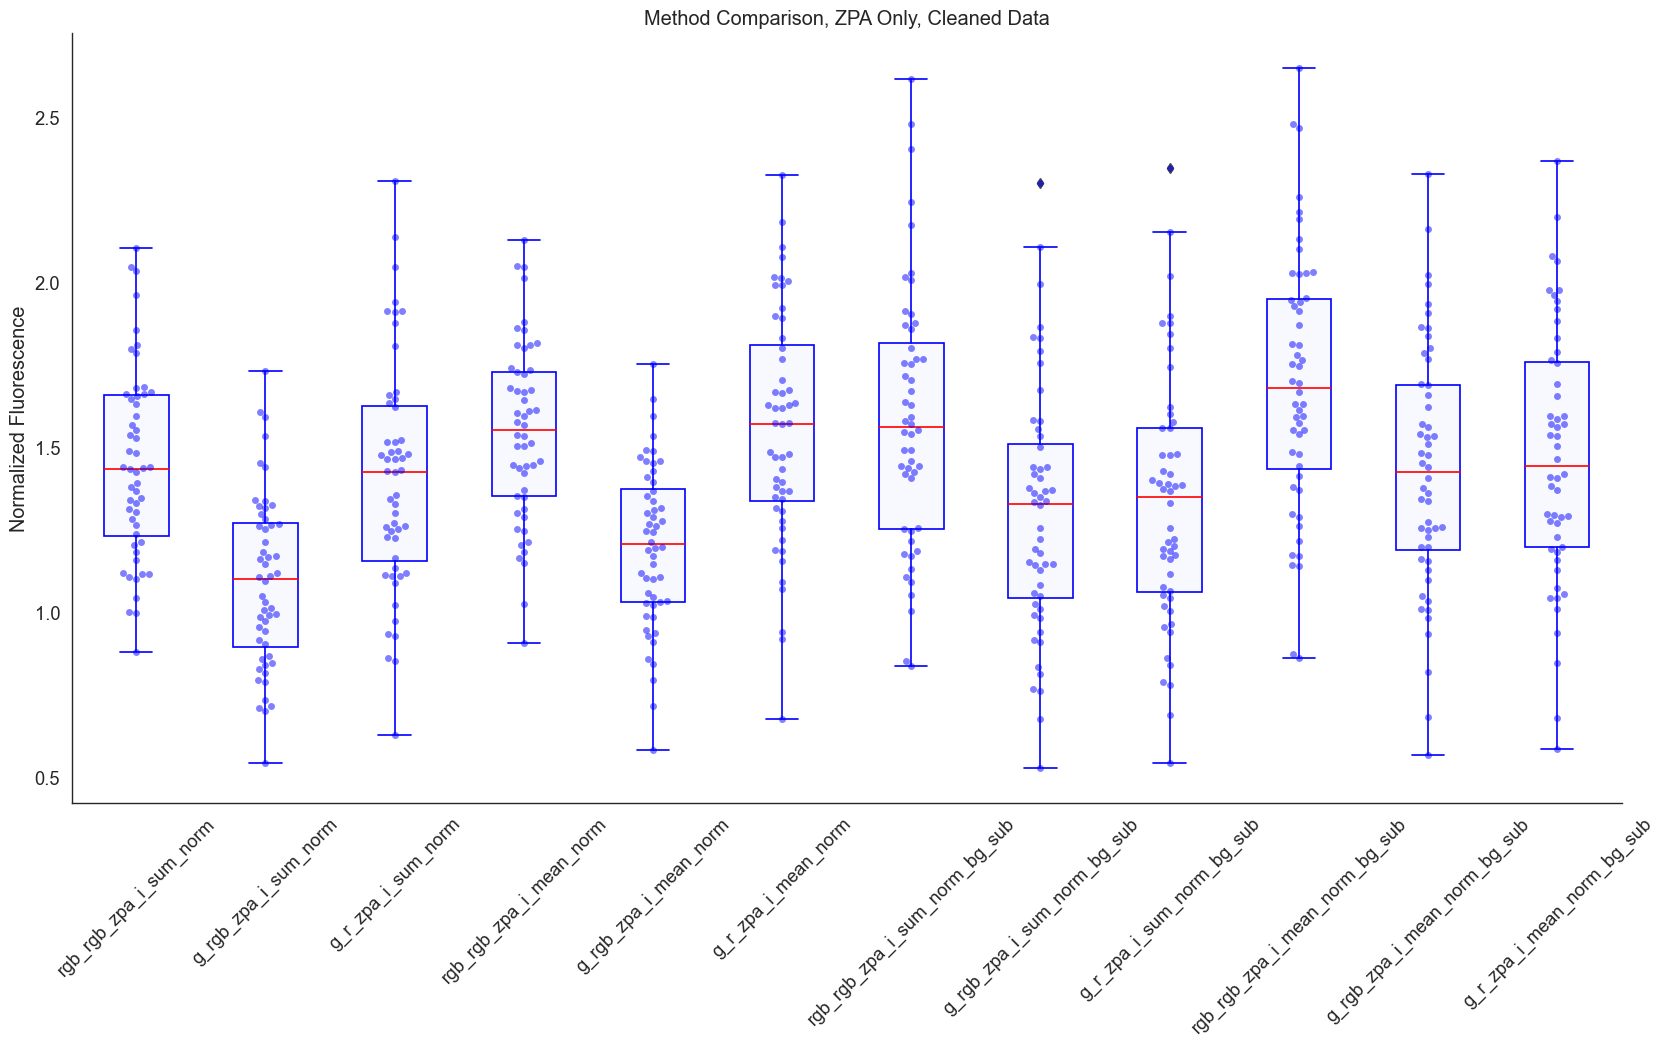

In [25]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='blue'):
        pairs = list(combinations(order, 2))
        plt.figure(figsize=(20, 10))
        plt.rcParams.update({'font.size': 16})
        
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': 'red'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        # Annotate with Kruskal-Wallis Test
        # annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.configure(test='Kruskal', text_format='star', loc='inside')
        # annotator.apply_and_annotate()

        # Annotate with Kolmogorov-Smirnov Test
        # custom_long_name = 'Kolmogorov-Smirnov Test'
        # custom_short_name = 'KStest'
        # custom_func = kstest
        # custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

        # annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.reset_configuration()
        # annotator.new_plot(ax, pairs, data=df, x=x, y=y, order=order)
        # annotator.configure(test=custom_test, comparisons_correction=None,
        #             text_format='star').apply_and_annotate()

        # mut_dict = {'rgb_limb_i_sum_norm': 'RGB Limb', 'g_limb_i_sum_norm':'G Limb', 'rgb_post_i_sum_norm':'RGB Post',
        #             'g_post_i_sum_norm':'G Post', 'rgb_zpa_i_sum_norm':'RGB ZPA',  'g_zpa_i_sum_norm':'G ZPA'}
        # label_list = [mut_dict[i] for i in order]
        plt.title(ptitle)
        ax.set_xticklabels(order, rotation=45)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence')
        plt.show()
        #plt.savefig('Fig_Name.png')


limb = ['rgb_rgb_limb_i_sum_norm',
        'g_rgb_limb_i_sum_norm', 
        'g_r_limb_i_sum_norm', 
        'rgb_rgb_limb_i_mean_norm',
        'g_rgb_limb_i_mean_norm', 
        'g_r_limb_i_mean_norm',
        'rgb_rgb_limb_i_sum_norm_bg_sub',
        'g_rgb_limb_i_sum_norm_bg_sub',
        'g_r_limb_i_sum_norm_bg_sub', 
        'rgb_rgb_limb_i_mean_norm_bg_sub',
        'g_rgb_limb_i_mean_norm_bg_sub',
        'g_r_limb_i_mean_norm_bg_sub']

post = ['rgb_rgb_post_i_sum_norm',
        'g_rgb_post_i_sum_norm', 
        'g_r_post_i_sum_norm', 
        'rgb_rgb_post_i_mean_norm',
        'g_rgb_post_i_mean_norm', 
        'g_r_post_i_mean_norm',
        'rgb_rgb_post_i_sum_norm_bg_sub',
        'g_rgb_post_i_sum_norm_bg_sub',
        'g_r_post_i_sum_norm_bg_sub', 
        'rgb_rgb_post_i_mean_norm_bg_sub',
        'g_rgb_post_i_mean_norm_bg_sub',
        'g_r_post_i_mean_norm_bg_sub']

zpa = ['rgb_rgb_zpa_i_sum_norm',
        'g_rgb_zpa_i_sum_norm', 
        'g_r_zpa_i_sum_norm', 
        'rgb_rgb_zpa_i_mean_norm',
        'g_rgb_zpa_i_mean_norm', 
        'g_r_zpa_i_mean_norm',
        'rgb_rgb_zpa_i_sum_norm_bg_sub',
        'g_rgb_zpa_i_sum_norm_bg_sub',
        'g_r_zpa_i_sum_norm_bg_sub', 
        'rgb_rgb_zpa_i_mean_norm_bg_sub',
        'g_rgb_zpa_i_mean_norm_bg_sub',
        'g_r_zpa_i_mean_norm_bg_sub']


box_swarm_plot(method_df_cleaned_iqr_melt, limb, 'Method', 'Normalized Intensity', 'Method Comparison, Limb Only, Cleaned Data')
box_swarm_plot(method_df_cleaned_iqr_melt, post,'Method', 'Normalized Intensity', 'Method Comparison, Posterior Only, Cleaned Data')
box_swarm_plot(method_df_cleaned_iqr_melt, zpa, 'Method', 'Normalized Intensity', 'Method Comparison, ZPA Only, Cleaned Data')


#### Descriptive Stat Conclusions
The data for most of the groups was fairly normal to begin with, though method combinations using the ZPA ROI tended to result in more outlier data points than those using the Limb or Posterior ROIs. We compared several outlier detection methods with fairly similar outcomes. Regardless of the outlier detection method used, the cleaned data are all normally distributed. WE decided to proceed with the IQR method for outlier detection since it is median-based and robust to outliers. An argument could also be made for using the MAD Z-Score method.

## 3.2 Comparitive Statistics

### 3.2.1 Run all the stats

In [27]:

def compare_groups(df, columns):
    groups = []
    for col in columns:
        groups.append(df[col])

    # One-Way ANOVA
    f_value, p_value_anova = f_oneway(*groups) #Pass groups as args to run ANOVA on all groups
    print(f'ANOVA F statistic: {f_value}')
    print(f'ANOVA p value: {p_value_anova}')

    # Tukey's HSD (post hoc test)
    if p_value_anova < 0.05:
        result = pairwise_tukeyhsd(endog=method_df_cleaned_iqr_melt['Normalized Intensity'], groups=method_df_cleaned_iqr_melt['Method'], alpha=0.05)
        # Extract the data from the Statsmodels SimpleTable
        data = result._results_table.data[1:]  # Exclude the header line
        headers = result._results_table.data[0]  # Get the header line
        result_df = pd.DataFrame(data, columns=headers)
        # result_df = result_df.reset_index(drop=True) #Do I need this?
        return result_df

tukey_result_df = compare_groups(method_df_cleaned_iqr, method_columns)
tukey_result_df
# tukey_result_df.to_csv('method_cleaned_iqr_tukey_results.csv', index=False)

ANOVA F statistic: 30.027996397064616
ANOVA p value: 2.201324126149012e-153


group1                         group2  meandiff  \
0              g_r_limb_i_mean_norm    g_r_limb_i_mean_norm_bg_sub   -0.1125   
1              g_r_limb_i_mean_norm            g_r_limb_i_sum_norm   -0.4882   
2              g_r_limb_i_mean_norm     g_r_limb_i_sum_norm_bg_sub   -0.5672   
3              g_r_limb_i_mean_norm           g_r_post_i_mean_norm   -0.0155   
4              g_r_limb_i_mean_norm    g_r_post_i_mean_norm_bg_sub   -0.1251   
..                              ...                            ...       ...   
625         rgb_rgb_zpa_i_mean_norm         rgb_rgb_zpa_i_sum_norm   -0.0971   
626         rgb_rgb_zpa_i_mean_norm  rgb_rgb_zpa_i_sum_norm_bg_sub    0.0405   
627  rgb_rgb_zpa_i_mean_norm_bg_sub         rgb_rgb_zpa_i_sum_norm   -0.2452   
628  rgb_rgb_zpa_i_mean_norm_bg_sub  rgb_rgb_zpa_i_sum_norm_bg_sub   -0.1076   
629          rgb_rgb_zpa_i_sum_norm  rgb_rgb_zpa_i_sum_norm_bg_sub    0.1376   

      p-adj   lower   upper  reject  
0    0.9991 -0.3583  0.1332   False  
1    0.0000 -0.7339 -0.2425    True  
2    0.0000 -0.8129 -0.3215    True  
3    1.0000 -0.2612  0.2302   False  
4    0.9941 -0.3708  0.1206   False  
..      ...     ...     ...     ...  
625  1.0000 -0.3428  0.1486   False  
626  1.0000 -0.2052  0.2862   False  
627  0.0513 -0.4909  0.0005   False  
628  0.9996 -0.3533  0.1381   False  
629  0.9747 -0.1081  0.3834   False  

[630 rows x 7 columns]

### 3.2.2 Create new df for grouping

In [28]:
header_list = ['Method', 'Fluor Normalization', 'ROI', 'Sum/Mean', 'Bg Removal', 'Normalized Intensity']
method_df_cleaned_iqr_melt2 = method_df_cleaned_iqr_melt.copy()
method_df_cleaned_iqr_melt2 = method_df_cleaned_iqr_melt2.reindex(columns=header_list)
method_df_cleaned_iqr_melt2['Fluor Normalization'] = method_df_cleaned_iqr_melt2['Method']
method_df_cleaned_iqr_melt2['ROI'] = method_df_cleaned_iqr_melt2['Method']
method_df_cleaned_iqr_melt2['Sum/Mean'] = method_df_cleaned_iqr_melt2['Method']
method_df_cleaned_iqr_melt2['Bg Removal'] = method_df_cleaned_iqr_melt2['Method']

# for name in method_df_cleaned_iqr_melt2['Fluor Normalization']:
#     if 'rgb_rgb' in name:
#         name = name.replace(name, 'RGB/RGB')
#         # print(name)

for index, row in method_df_cleaned_iqr_melt2.iterrows():
    if 'rgb_rgb' in row['Fluor Normalization']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'Fluor Normalization'] = 'RGB/RGB'
    elif 'g_rgb' in row['Fluor Normalization']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'Fluor Normalization'] = 'G/RGB'
    elif 'g_r_' in row['Fluor Normalization']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'Fluor Normalization'] = 'G/R'

for index, row in method_df_cleaned_iqr_melt2.iterrows():
    if 'limb' in row['ROI']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'ROI'] = 'Limb'
    elif 'post' in row['ROI']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'ROI'] = 'Posterior'
    elif 'zpa' in row['ROI']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'ROI'] = 'ZPA'

for index, row in method_df_cleaned_iqr_melt2.iterrows():
    if 'sum' in row['Sum/Mean']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'Sum/Mean'] = 'Sum'
    elif 'mean' in row['Sum/Mean']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'Sum/Mean'] = 'Mean'

for index, row in method_df_cleaned_iqr_melt2.iterrows():
    if 'bg_sub' in row['Bg Removal']:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'Bg Removal'] = 'Bg Removed'
    else:
        # Replace the string with the replacement string
        method_df_cleaned_iqr_melt2.loc[index, 'Bg Removal'] = 'Bg'

method_df_cleaned_iqr_melt2




Method Fluor Normalization   ROI Sum/Mean  \
0        rgb_rgb_limb_i_sum_norm             RGB/RGB  Limb      Sum   
1        rgb_rgb_limb_i_sum_norm             RGB/RGB  Limb      Sum   
2        rgb_rgb_limb_i_sum_norm             RGB/RGB  Limb      Sum   
3        rgb_rgb_limb_i_sum_norm             RGB/RGB  Limb      Sum   
4        rgb_rgb_limb_i_sum_norm             RGB/RGB  Limb      Sum   
...                          ...                 ...   ...      ...   
1867  g_r_zpa_i_mean_norm_bg_sub                 G/R   ZPA     Mean   
1868  g_r_zpa_i_mean_norm_bg_sub                 G/R   ZPA     Mean   
1869  g_r_zpa_i_mean_norm_bg_sub                 G/R   ZPA     Mean   
1870  g_r_zpa_i_mean_norm_bg_sub                 G/R   ZPA     Mean   
1871  g_r_zpa_i_mean_norm_bg_sub                 G/R   ZPA     Mean   

      Bg Removal  Normalized Intensity  
0             Bg              0.839370  
1             Bg              0.854321  
2             Bg              1.452106  
3             Bg              0.863755  
4             Bg              0.629546  
...          ...                   ...  
1867  Bg Removed              1.292595  
1868  Bg Removed              1.044901  
1869  Bg Removed              1.044497  
1870  Bg Removed              1.533323  
1871  Bg Removed              1.977291  

[1872 rows x 6 columns]

In [29]:
method_df_cleaned_grp = method_df_cleaned_iqr_melt2.groupby(['ROI','Fluor Normalization', 'Sum/Mean', 'Bg Removal'])
method_df_cleaned_grp['Normalized Intensity'].describe()


count      mean       std  \
ROI       Fluor Normalization Sum/Mean Bg Removal                              
Limb      G/R                 Mean     Bg           52.0  1.400958  0.354347   
                                       Bg Removed   52.0  1.288414  0.395967   
                              Sum      Bg           52.0  0.912788  0.312089   
                                       Bg Removed   52.0  0.833771  0.310204   
          G/RGB               Mean     Bg           52.0  1.077143  0.246169   
                                       Bg Removed   52.0  1.255157  0.385931   
                              Sum      Bg           52.0  0.706896  0.242429   
                                       Bg Removed   52.0  0.814304  0.304299   
          RGB/RGB             Mean     Bg           52.0  1.382771  0.249486   
                                       Bg Removed   52.0  1.459399  0.381483   
                              Sum      Bg           52.0  1.036867  0.288005   
                                       Bg Removed   52.0  1.086089  0.348078   
Posterior G/R                 Mean     Bg           52.0  1.385459  0.330666   
                                       Bg Removed   52.0  1.275874  0.364449   
                              Sum      Bg           52.0  1.050738  0.308130   
                                       Bg Removed   52.0  0.964013  0.310565   
          G/RGB               Mean     Bg           52.0  1.074906  0.229357   
                                       Bg Removed   52.0  1.242954  0.355069   
                              Sum      Bg           52.0  0.821623  0.244374   
                                       Bg Removed   52.0  0.941114  0.304422   
          RGB/RGB             Mean     Bg           52.0  1.387514  0.241872   
                                       Bg Removed   52.0  1.460966  0.358077   
                              Sum      Bg           52.0  1.171735  0.283671   
                                       Bg Removed   52.0  1.227497  0.343860   
ZPA       G/R                 Mean     Bg           52.0  1.556613  0.351977   
                                       Bg Removed   52.0  1.470570  0.388740   
                              Sum      Bg           52.0  1.411026  0.352144   
                                       Bg Removed   52.0  1.332592  0.381219   
          G/RGB               Mean     Bg           52.0  1.200263  0.245887   
                                       Bg Removed   52.0  1.431117  0.374853   
                              Sum      Bg           52.0  1.094661  0.261654   
                                       Bg Removed   52.0  1.303607  0.374753   
          RGB/RGB             Mean     Bg           52.0  1.547667  0.271271   
                                       Bg Removed   52.0  1.695764  0.394678   
                              Sum      Bg           52.0  1.450537  0.289661   
                                       Bg Removed   52.0  1.588175  0.398322   

                                                        min       25%  \
ROI       Fluor Normalization Sum/Mean Bg Removal                       
Limb      G/R                 Mean     Bg          0.612262  1.175501   
                                       Bg Removed  0.498568  1.050409   
                              Sum      Bg          0.300517  0.666762   
                                       Bg Removed  0.254581  0.611228   
          G/RGB               Mean     Bg          0.520718  0.911364   
                                       Bg Removed  0.486173  1.025667   
                              Sum      Bg          0.242059  0.543432   
                                       Bg Removed  0.246998  0.592792   
          RGB/RGB             Mean     Bg          0.829750  1.215786   
                                       Bg Removed  0.571041  1.210417   
                              Sum      Bg          0.422545  0.851814   
                                       Bg Removed  0.413749  

### 3.2.3 Method Comparison: RGB Normalization
Since we split the RGB channels to account for bleed-through, we compared normalizing the following ways:

* RGB/RGB = Intesity of GFP RGB image / Intensity of RFP RGB image
* G/RGB = Intensity of GFP G channel only / Intensity of RFP RGB image
* G/R = Intensity of GFP G channel only / Intensity of RFP R channel only

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_rgb_limb_i_mean_norm vs. g_r_limb_i_mean_norm: Custom statistical test, P_val:3.000e-04
g_rgb_limb_i_mean_norm_bg_sub vs. g_r_limb_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_rgb_limb_i_sum_norm vs. g_r_limb_i_sum_norm: Custom statistical test, P_val:3.002e-01
g_rgb_limb_i_sum_norm_bg_sub vs. g_r_limb_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00
rgb_rgb_limb_i_mean_norm vs. g_rgb_limb_i_mean_norm: Custom statistical test, P_val:1.100e-03
rgb_rgb_limb_i_mean_norm_bg_sub vs. g_rgb_limb_i_mean_norm_bg_sub: Custom statistical test, P_val:3.180e-01
rgb_rgb_limb_i_sum_norm vs. g_rgb_limb_i_sum_norm: Custom statistical test, P_val:2.000e-04
rgb_rgb_limb_i_sum_norm_bg_sub vs. g_rgb_limb_i_sum_norm_bg_sub: Custom statistical test, P_val:1.080e-02
rgb_rgb_limb_i_mean_norm vs. g_r_li

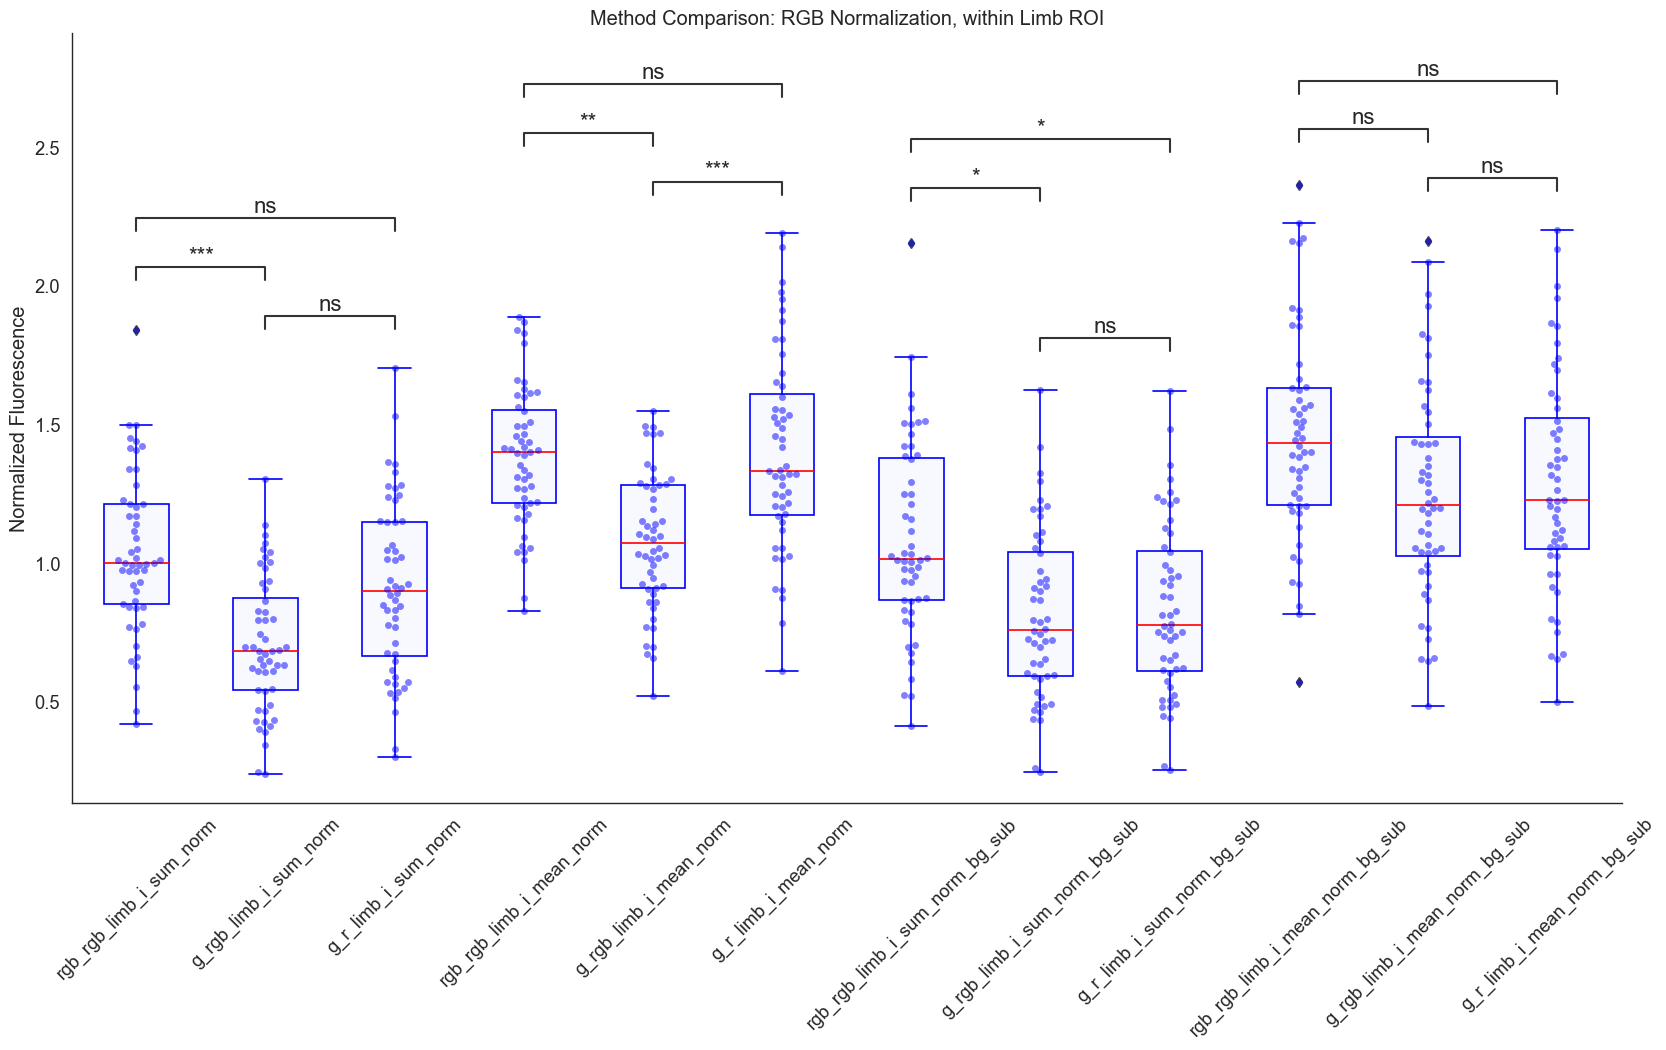

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_rgb_post_i_mean_norm vs. g_r_post_i_mean_norm: Custom statistical test, P_val:7.000e-04
g_rgb_post_i_mean_norm_bg_sub vs. g_r_post_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_rgb_post_i_sum_norm vs. g_r_post_i_sum_norm: Custom statistical test, P_val:1.153e-01
g_rgb_post_i_sum_norm_bg_sub vs. g_r_post_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00
rgb_rgb_post_i_mean_norm vs. g_rgb_post_i_mean_norm: Custom statistical test, P_val:6.000e-04
rgb_rgb_post_i_mean_norm_bg_sub vs. g_rgb_post_i_mean_norm_bg_sub: Custom statistical test, P_val:1.883e-01
rgb_rgb_post_i_sum_norm vs. g_rgb_post_i_sum_norm: Custom statistical test, P_val:0.000e+00
rgb_rgb_post_i_sum_norm_bg_sub vs. g_rgb_post_i_sum_norm_bg_sub: Custom statistical test, P_val:4.100e-03
rgb_rgb_post_i_mean_norm vs. g_r_po

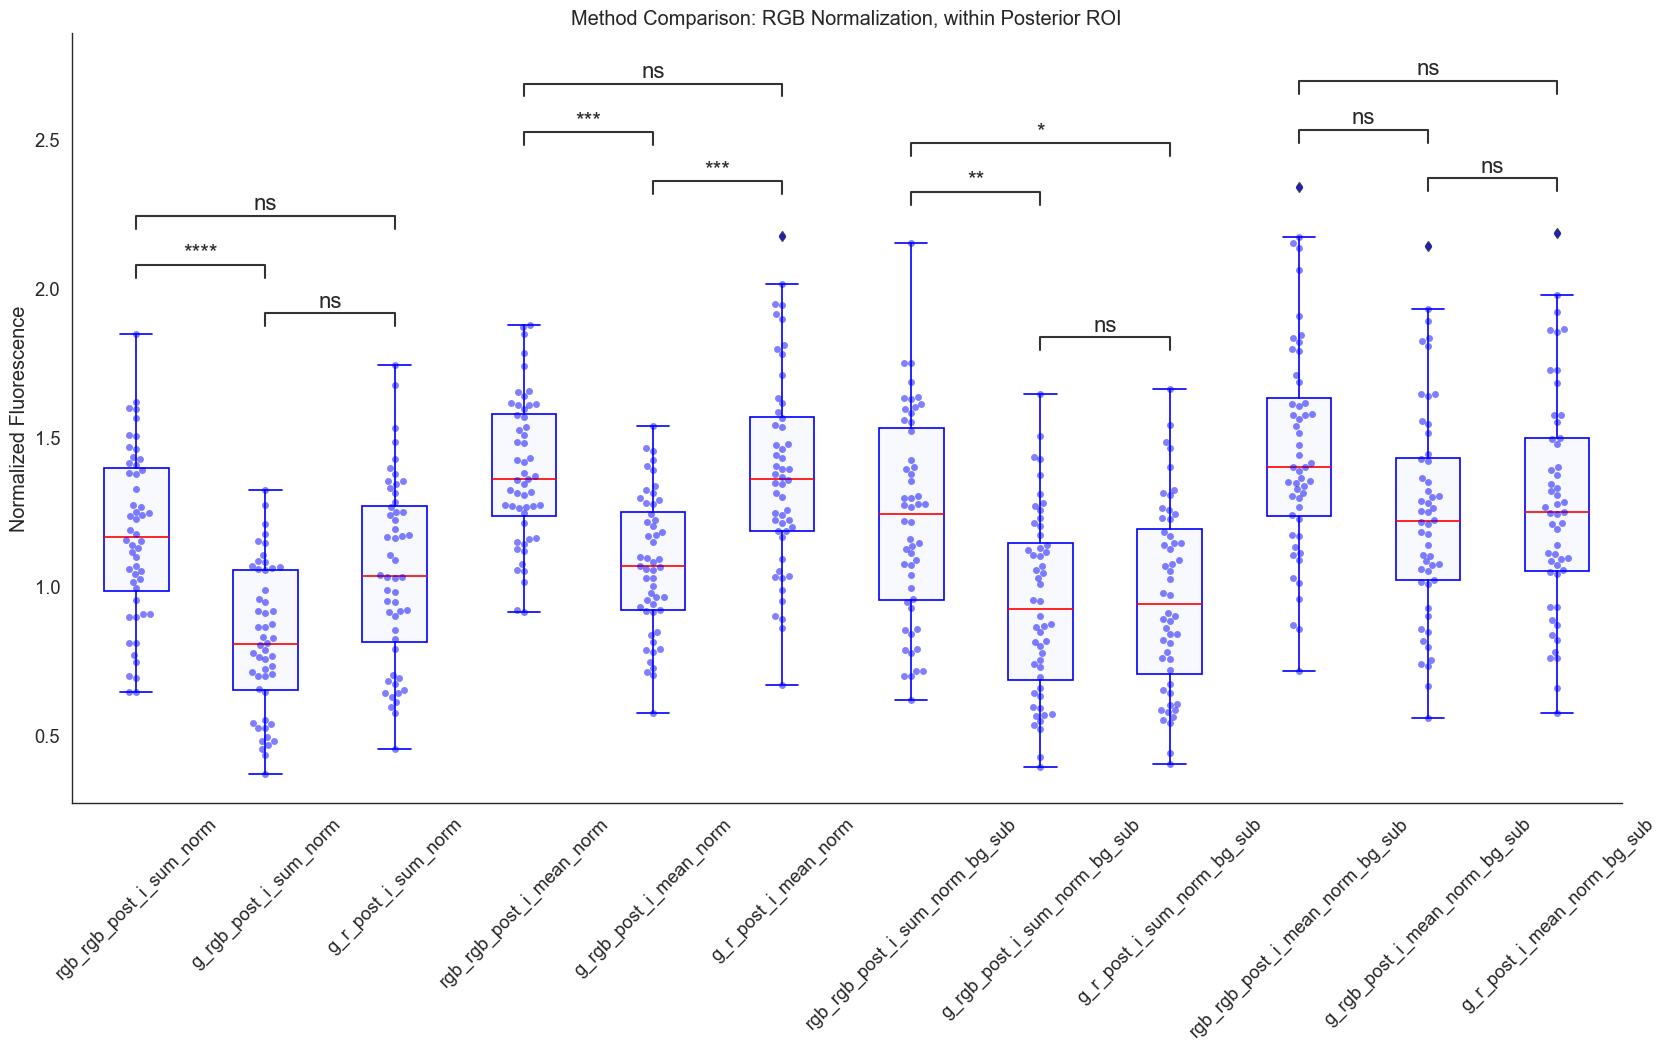

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_rgb_zpa_i_mean_norm vs. g_r_zpa_i_mean_norm: Custom statistical test, P_val:0.000e+00
g_rgb_zpa_i_mean_norm_bg_sub vs. g_r_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_rgb_zpa_i_sum_norm vs. g_r_zpa_i_sum_norm: Custom statistical test, P_val:5.000e-04
g_rgb_zpa_i_sum_norm_bg_sub vs. g_r_zpa_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00
rgb_rgb_zpa_i_mean_norm vs. g_rgb_zpa_i_mean_norm: Custom statistical test, P_val:0.000e+00
rgb_rgb_zpa_i_mean_norm_bg_sub vs. g_rgb_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:1.690e-02
rgb_rgb_zpa_i_sum_norm vs. g_rgb_zpa_i_sum_norm: Custom statistical test, P_val:0.000e+00
rgb_rgb_zpa_i_sum_norm_bg_sub vs. g_rgb_zpa_i_sum_norm_bg_sub: Custom statistical test, P_val:4.700e-03
rgb_rgb_zpa_i_mean_norm vs. g_r_zpa_i_mean_norm: Cu

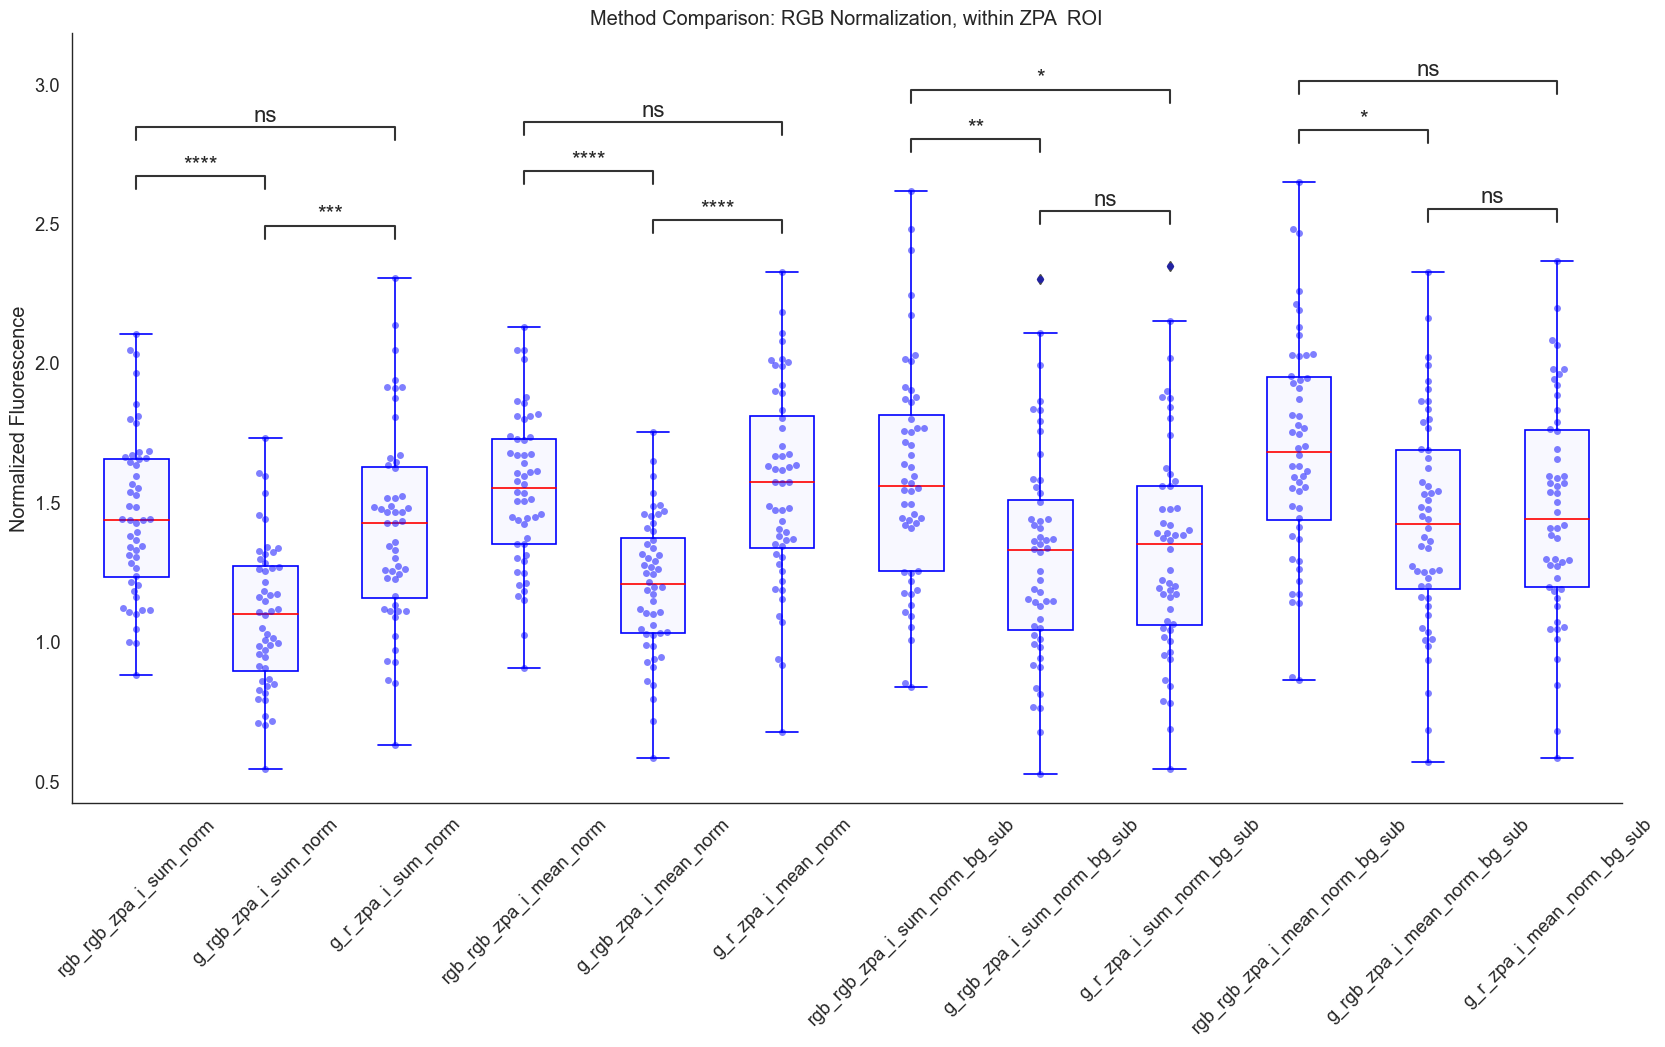

In [30]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='blue'):
        #pairs = list(combinations(order, 2))
        plt.figure(figsize=(20, 10))
        plt.rcParams.update({'font.size': 16})
        
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': 'red'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        pairs = [(i[1]['group1'], i[1]['group2']) for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
        p_values = [i[1]['p-adj'] for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]

        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        annotator.configure(text_format="star", loc="inside")
        annotator.set_pvalues_and_annotate(p_values)
        # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.

        # mut_dict = {}
        # label_list = [mut_dict[i] for i in order]
        plt.title(ptitle)
        ax.set_xticklabels(order, rotation=45)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence')
        plt.show()
        #plt.savefig('Fig_Name.png')



limb = ['rgb_rgb_limb_i_sum_norm',
        'g_rgb_limb_i_sum_norm', 
        'g_r_limb_i_sum_norm', 
        'rgb_rgb_limb_i_mean_norm',
        'g_rgb_limb_i_mean_norm', 
        'g_r_limb_i_mean_norm',
        'rgb_rgb_limb_i_sum_norm_bg_sub',
        'g_rgb_limb_i_sum_norm_bg_sub',
        'g_r_limb_i_sum_norm_bg_sub', 
        'rgb_rgb_limb_i_mean_norm_bg_sub',
        'g_rgb_limb_i_mean_norm_bg_sub',
        'g_r_limb_i_mean_norm_bg_sub']


desired_pairs = [('rgb_rgb_limb_i_sum_norm', 'g_rgb_limb_i_sum_norm'),
        ('g_rgb_limb_i_sum_norm', 'g_r_limb_i_sum_norm'),
        ('g_r_limb_i_sum_norm', 'rgb_rgb_limb_i_sum_norm'),
        ('rgb_rgb_limb_i_mean_norm', 'g_rgb_limb_i_mean_norm'),
        ('g_rgb_limb_i_mean_norm', 'g_r_limb_i_mean_norm'),
        ('g_r_limb_i_mean_norm', 'rgb_rgb_limb_i_mean_norm'),
        ('rgb_rgb_limb_i_sum_norm_bg_sub', 'g_rgb_limb_i_sum_norm_bg_sub'),
        ('g_rgb_limb_i_sum_norm_bg_sub','g_r_limb_i_sum_norm_bg_sub'), 
        ('g_r_limb_i_sum_norm_bg_sub', 'rgb_rgb_limb_i_sum_norm_bg_sub'),
        ('rgb_rgb_limb_i_mean_norm_bg_sub', 'g_rgb_limb_i_mean_norm_bg_sub'),
        ('g_rgb_limb_i_mean_norm_bg_sub', 'g_r_limb_i_mean_norm_bg_sub'),
        ('g_r_limb_i_mean_norm_bg_sub','rgb_rgb_limb_i_mean_norm_bg_sub'),
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, limb, 'Method', 'Normalized Intensity', 'Method Comparison: RGB Normalization, within Limb ROI')

post = ['rgb_rgb_post_i_sum_norm',
        'g_rgb_post_i_sum_norm', 
        'g_r_post_i_sum_norm', 
        'rgb_rgb_post_i_mean_norm',
        'g_rgb_post_i_mean_norm', 
        'g_r_post_i_mean_norm',
        'rgb_rgb_post_i_sum_norm_bg_sub',
        'g_rgb_post_i_sum_norm_bg_sub',
        'g_r_post_i_sum_norm_bg_sub', 
        'rgb_rgb_post_i_mean_norm_bg_sub',
        'g_rgb_post_i_mean_norm_bg_sub',
        'g_r_post_i_mean_norm_bg_sub']

desired_pairs = [('rgb_rgb_post_i_sum_norm', 'g_rgb_post_i_sum_norm'),
        ('g_rgb_post_i_sum_norm', 'g_r_post_i_sum_norm'),
        ('g_r_post_i_sum_norm', 'rgb_rgb_post_i_sum_norm'),
        ('rgb_rgb_post_i_mean_norm', 'g_rgb_post_i_mean_norm'),
        ('g_rgb_post_i_mean_norm', 'g_r_post_i_mean_norm'),
        ('g_r_post_i_mean_norm', 'rgb_rgb_post_i_mean_norm'),
        ('rgb_rgb_post_i_sum_norm_bg_sub', 'g_rgb_post_i_sum_norm_bg_sub'),
        ('g_rgb_post_i_sum_norm_bg_sub','g_r_post_i_sum_norm_bg_sub'), 
        ('g_r_post_i_sum_norm_bg_sub', 'rgb_rgb_post_i_sum_norm_bg_sub'),
        ('rgb_rgb_post_i_mean_norm_bg_sub', 'g_rgb_post_i_mean_norm_bg_sub'),
        ('g_rgb_post_i_mean_norm_bg_sub', 'g_r_post_i_mean_norm_bg_sub'),
        ('g_r_post_i_mean_norm_bg_sub','rgb_rgb_post_i_mean_norm_bg_sub'),
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, post,'Method', 'Normalized Intensity', 'Method Comparison: RGB Normalization, within Posterior ROI')

zpa = ['rgb_rgb_zpa_i_sum_norm',
        'g_rgb_zpa_i_sum_norm', 
        'g_r_zpa_i_sum_norm', 
        'rgb_rgb_zpa_i_mean_norm',
        'g_rgb_zpa_i_mean_norm', 
        'g_r_zpa_i_mean_norm',
        'rgb_rgb_zpa_i_sum_norm_bg_sub',
        'g_rgb_zpa_i_sum_norm_bg_sub',
        'g_r_zpa_i_sum_norm_bg_sub', 
        'rgb_rgb_zpa_i_mean_norm_bg_sub',
        'g_rgb_zpa_i_mean_norm_bg_sub',
        'g_r_zpa_i_mean_norm_bg_sub']

desired_pairs = [('rgb_rgb_zpa_i_sum_norm', 'g_rgb_zpa_i_sum_norm'),
        ('g_rgb_zpa_i_sum_norm', 'g_r_zpa_i_sum_norm'),
        ('g_r_zpa_i_sum_norm', 'rgb_rgb_zpa_i_sum_norm'),
        ('rgb_rgb_zpa_i_mean_norm', 'g_rgb_zpa_i_mean_norm'),
        ('g_rgb_zpa_i_mean_norm', 'g_r_zpa_i_mean_norm'),
        ('g_r_zpa_i_mean_norm', 'rgb_rgb_zpa_i_mean_norm'),
        ('rgb_rgb_zpa_i_sum_norm_bg_sub', 'g_rgb_zpa_i_sum_norm_bg_sub'),
        ('g_rgb_zpa_i_sum_norm_bg_sub','g_r_zpa_i_sum_norm_bg_sub'), 
        ('g_r_zpa_i_sum_norm_bg_sub', 'rgb_rgb_zpa_i_sum_norm_bg_sub'),
        ('rgb_rgb_zpa_i_mean_norm_bg_sub', 'g_rgb_zpa_i_mean_norm_bg_sub'),
        ('g_rgb_zpa_i_mean_norm_bg_sub', 'g_r_zpa_i_mean_norm_bg_sub'),
        ('g_r_zpa_i_mean_norm_bg_sub','rgb_rgb_zpa_i_mean_norm_bg_sub'),
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, zpa, 'Method', 'Normalized Intensity', 'Method Comparison: RGB Normalization, within ZPA  ROI')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_rgb_limb_i_sum_norm vs. g_r_limb_i_sum_norm: Custom statistical test, P_val:3.002e-01
rgb_rgb_limb_i_sum_norm vs. g_rgb_limb_i_sum_norm: Custom statistical test, P_val:2.000e-04
rgb_rgb_limb_i_sum_norm vs. g_r_limb_i_sum_norm: Custom statistical test, P_val:9.949e-01


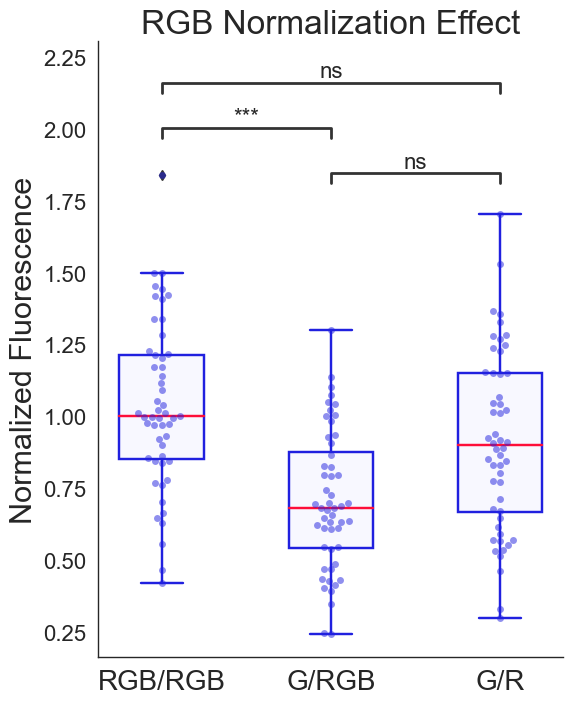

In [ ]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='#2020dfff'):
        
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(6, 8), facecolor='white') 
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': '#fe0e39ff'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, linewidth=1.75, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        pairs = [(i[1]['group1'], i[1]['group2']) for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
        p_values = [i[1]['p-adj'] for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]

        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        annotator.configure(text_format="star", loc="inside", line_width=2)
        annotator.set_pvalues_and_annotate(p_values)
        # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.

        mut_dict = {'rgb_rgb_limb_i_sum_norm': 'RGB/RGB', 'g_rgb_limb_i_sum_norm':'G/RGB', 'g_r_limb_i_sum_norm':'G/R'}
        label_list = [mut_dict[i] for i in order]
        plt.title(ptitle, fontsize=24) #, fontweight='bold'
        ax.set_xticklabels(label_list)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence', fontsize=22)
        ax.tick_params(axis='y', labelsize=16)
        ax.tick_params(axis='x', labelsize=20)
        plt.show()
        #plt.savefig('rgb_boxplot.svg', dpi=500)


order = ['rgb_rgb_limb_i_sum_norm',
        'g_rgb_limb_i_sum_norm', 
        'g_r_limb_i_sum_norm'
        ]
desired_pairs = list(combinations(order, 2))
box_swarm_plot(method_df_cleaned_iqr_melt, order, 'Method', 'Normalized Intensity', 'RGB Normalization Effect')


#### RGB Normalization Conclusions

To accurately represent the value of the exerimental reporter (GFP) signal and normalize it to the transfection control (RFP) signal, we compared three methods of data collection and normalization. We compared the intensity values of the RGB images with that of the decomposed green (G) and red (R) -channel only images. We normalized the GFP RGB intensity to the RFP RGB intensity (RGB/RGB), the GFP green channel intensity to RFP RGB intensity (G/RGB), and the GFP G channel intensity to RFP R channel intensity (G/R). In general there tended to be no significant difference between the RGB/RGB and the G/R method of data normalization (Tukey's HSD, $p\leq0.05$), but the median value of the G/RGB method was significantly lower than one or the other methods. This seems reasonable since normalizing the GFP G channel intensity to the RFP RGB intensity usually means dividing a small numerator by a larger denominator leading to a lower overall ratio.  Based on our RGB channel analysis, since there is a fair amount of red bleed-through into the GFP image, we will use the G/R normalization method in future analyses.

### 3.2.4 Method Comparison: Regions of Interest (ROIs)
To account for transfection variability we collected data within three (nested) ROIs:
* Limb: Includes the whole limb bud, but excludes the body wall and background
* Posterior: The posterior (lower) half of the limb bud, where wild-type ZRS activity is usually detected.
* ZPA: The location of active Sonic Hedgehog transcription, approximately $500\mu m$ from the distal (right) tip of the limb bud, and within the posterior (lower) third of the limb.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

rgb_rgb_limb_i_mean_norm vs. rgb_rgb_post_i_mean_norm: Custom statistical test, P_val:1.000e+00
rgb_rgb_limb_i_mean_norm_bg_sub vs. rgb_rgb_post_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
rgb_rgb_limb_i_sum_norm vs. rgb_rgb_post_i_sum_norm: Custom statistical test, P_val:9.810e-01
rgb_rgb_limb_i_sum_norm_bg_sub vs. rgb_rgb_post_i_sum_norm_bg_sub: Custom statistical test, P_val:9.635e-01
rgb_rgb_post_i_mean_norm vs. rgb_rgb_zpa_i_mean_norm: Custom statistical test, P_val:8.502e-01
rgb_rgb_post_i_mean_norm_bg_sub vs. rgb_rgb_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:8.780e-02
rgb_rgb_post_i_sum_norm vs. rgb_rgb_zpa_i_sum_norm: Custom statistical test, P_val:6.900e-03
rgb_rgb_post_i_sum_norm_bg_sub vs. rgb_rgb_zpa_i_sum_norm_bg_sub: Custom statistical test, P_val:0.000e+00
rgb_rgb

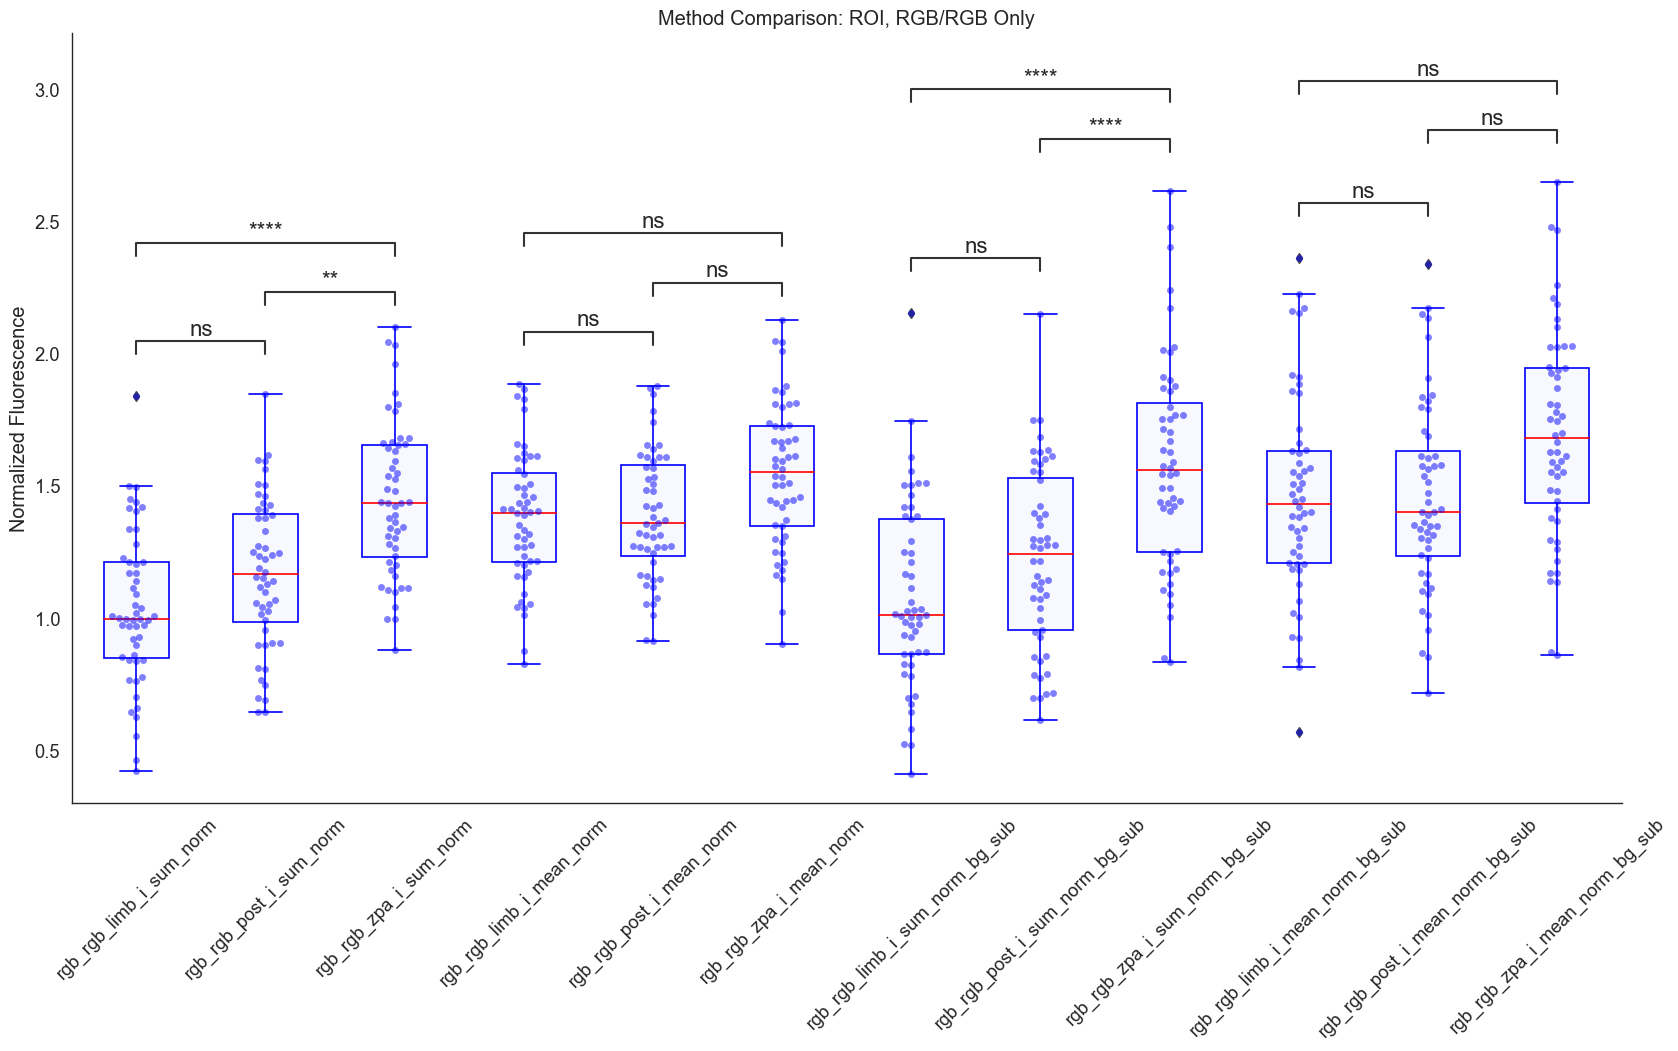

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_rgb_limb_i_mean_norm vs. g_rgb_post_i_mean_norm: Custom statistical test, P_val:1.000e+00
g_rgb_limb_i_mean_norm_bg_sub vs. g_rgb_post_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_rgb_limb_i_sum_norm vs. g_rgb_post_i_sum_norm: Custom statistical test, P_val:9.987e-01
g_rgb_limb_i_sum_norm_bg_sub vs. g_rgb_post_i_sum_norm_bg_sub: Custom statistical test, P_val:9.926e-01
g_rgb_post_i_mean_norm vs. g_rgb_zpa_i_mean_norm: Custom statistical test, P_val:9.939e-01
g_rgb_post_i_mean_norm_bg_sub vs. g_rgb_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:5.159e-01
g_rgb_post_i_sum_norm vs. g_rgb_zpa_i_sum_norm: Custom statistical test, P_val:1.000e-02
g_rgb_post_i_sum_norm_bg_sub vs. g_rgb_zpa_i_sum_norm_bg_sub: Custom statistical test, P_val:0.000e+00
g_rgb_limb_i_mean_norm vs. g_rgb_zpa_i_

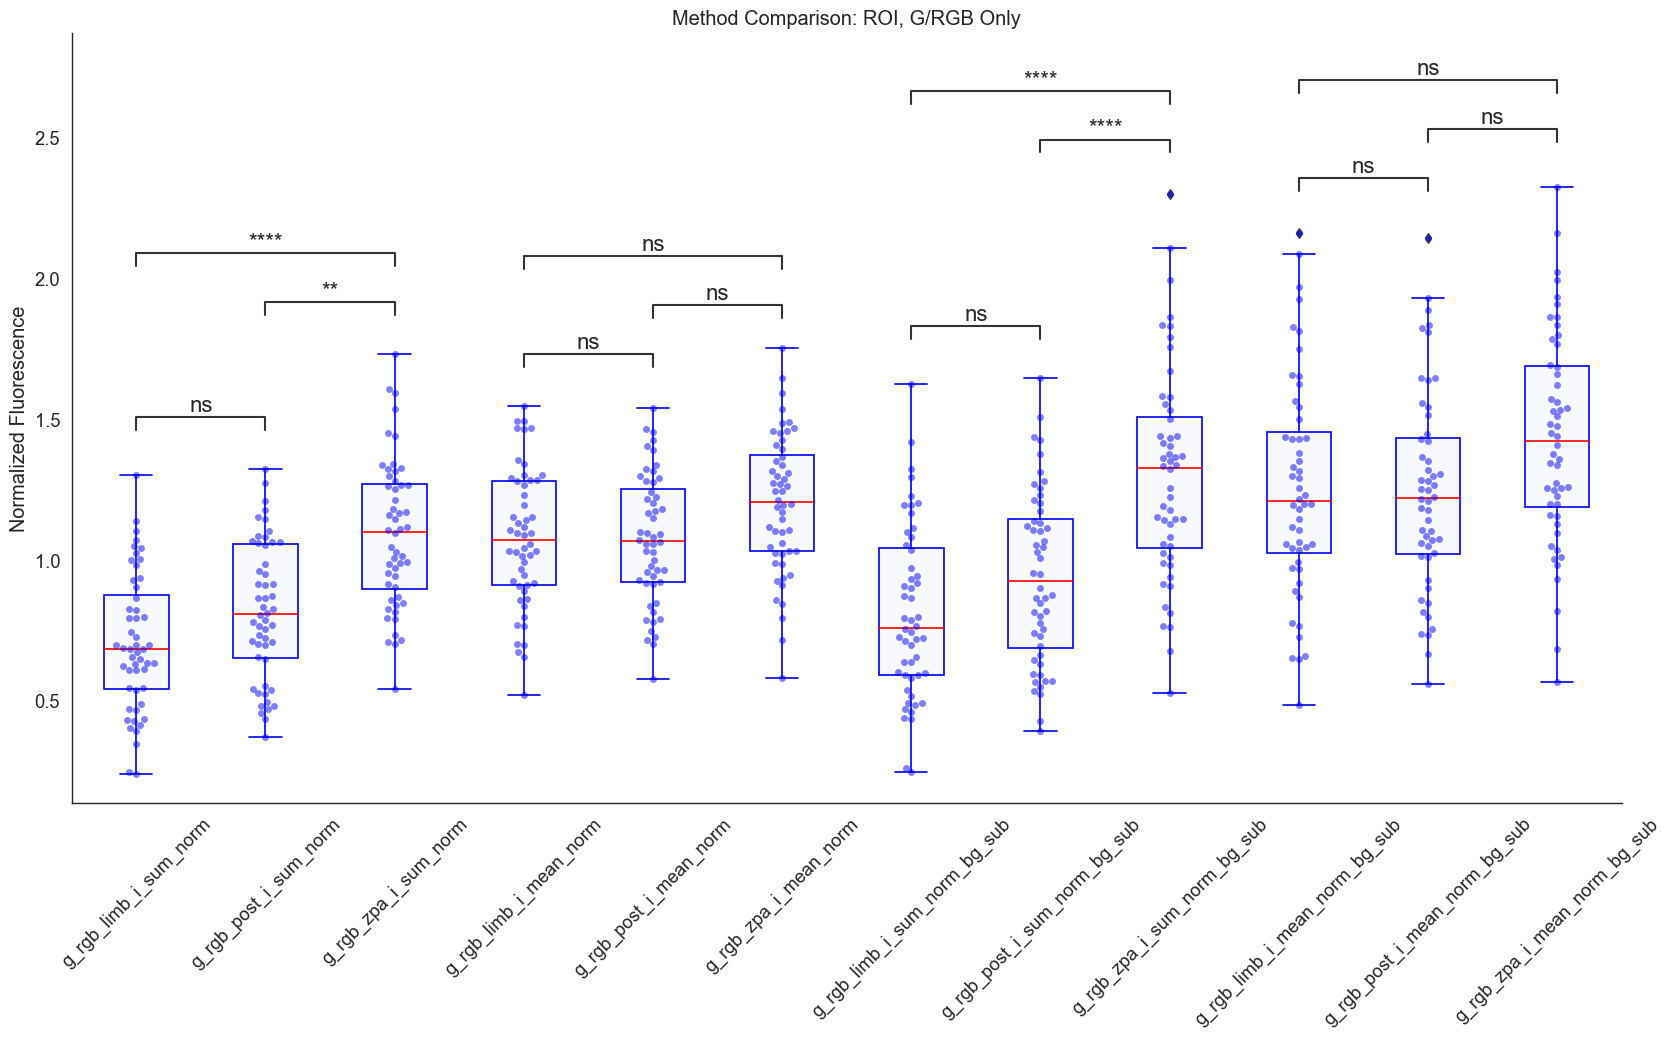

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_limb_i_mean_norm vs. g_r_post_i_mean_norm: Custom statistical test, P_val:1.000e+00
g_r_limb_i_mean_norm_bg_sub vs. g_r_post_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_r_limb_i_sum_norm vs. g_r_post_i_sum_norm: Custom statistical test, P_val:9.739e-01
g_r_limb_i_sum_norm_bg_sub vs. g_r_post_i_sum_norm_bg_sub: Custom statistical test, P_val:9.888e-01
g_r_post_i_mean_norm vs. g_r_zpa_i_mean_norm: Custom statistical test, P_val:7.351e-01
g_r_post_i_mean_norm_bg_sub vs. g_r_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:4.312e-01
g_r_post_i_sum_norm vs. g_r_zpa_i_sum_norm: Custom statistical test, P_val:0.000e+00
g_r_post_i_sum_norm_bg_sub vs. g_r_zpa_i_sum_norm_bg_sub: Custom statistical test, P_val:0.000e+00
g_r_limb_i_mean_norm vs. g_r_zpa_i_mean_norm: Custom statistical test, 

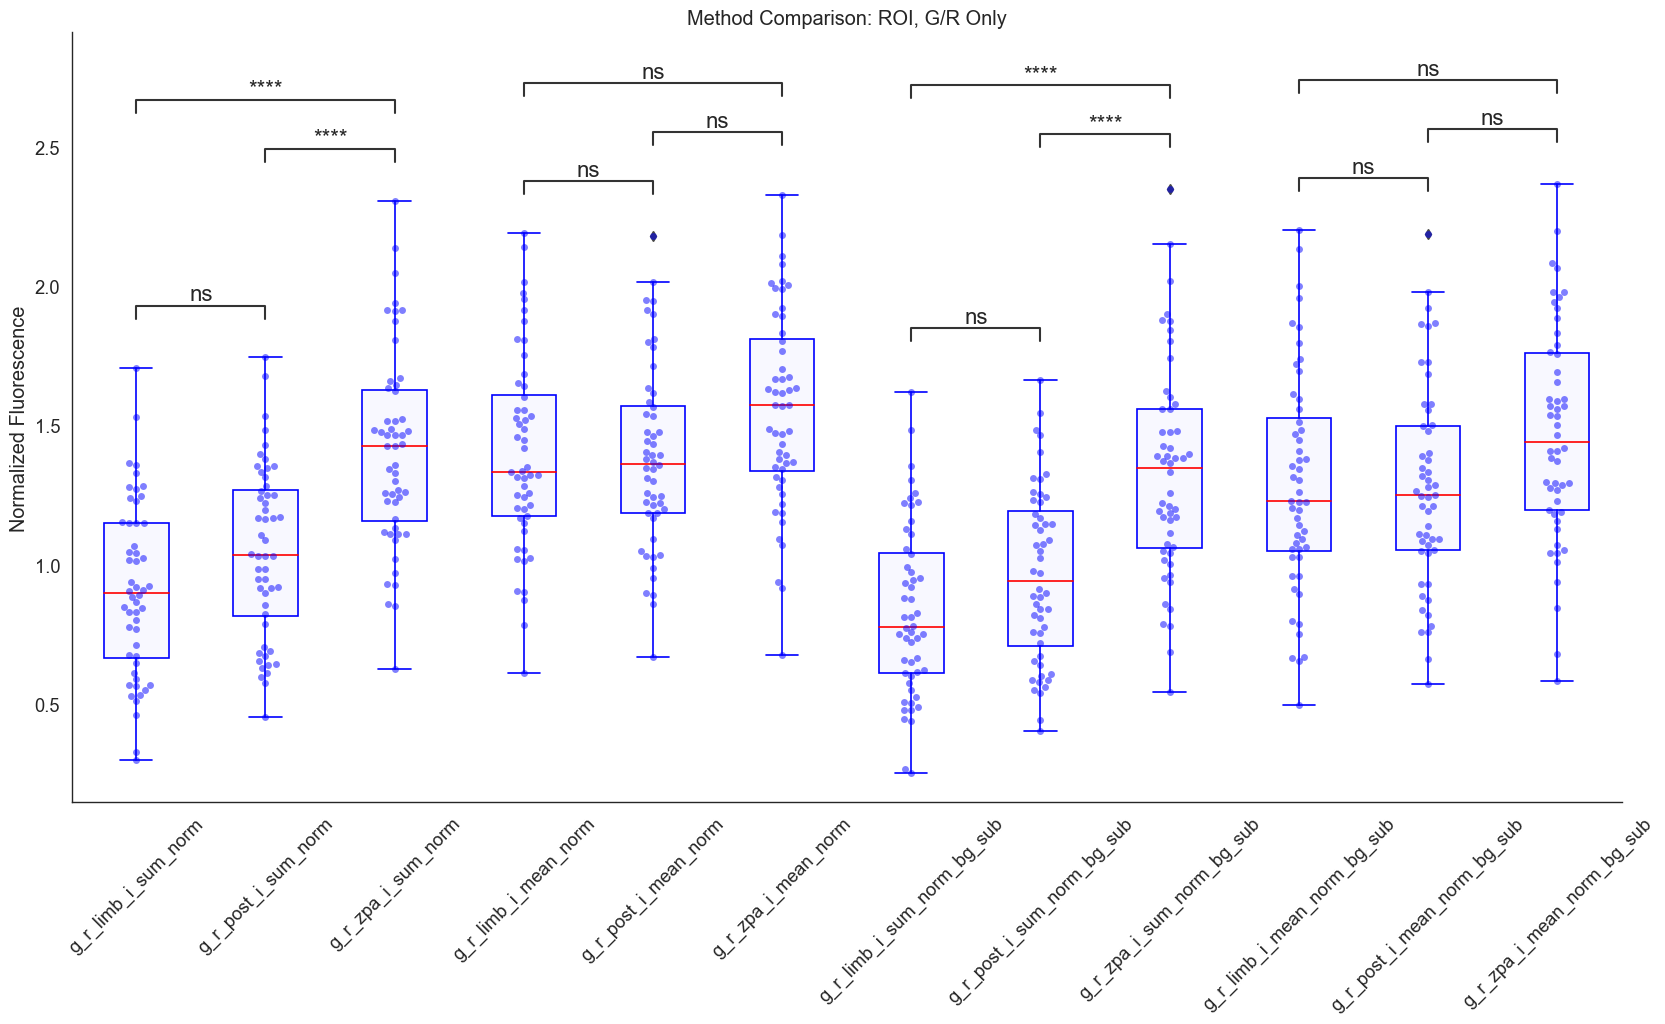

In [33]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='blue'):
        plt.figure(figsize=(20, 10))
        plt.rcParams.update({'font.size': 16})
        
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': 'red'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        pairs = [(i[1]['group1'], i[1]['group2']) for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
        p_values = [i[1]['p-adj'] for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]

        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        annotator.configure(text_format="star", loc="inside")
        annotator.set_pvalues_and_annotate(p_values)
        # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.

        # mut_dict = {}
        # label_list = [mut_dict[i] for i in order]
        plt.title(ptitle)
        ax.set_xticklabels(order, rotation=45)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence')
        plt.show()
        #plt.savefig('Fig_Name.png')


rgb_rgb = [                                        
        'rgb_rgb_limb_i_sum_norm', 'rgb_rgb_post_i_sum_norm', 'rgb_rgb_zpa_i_sum_norm',
        'rgb_rgb_limb_i_mean_norm', 'rgb_rgb_post_i_mean_norm', 'rgb_rgb_zpa_i_mean_norm',
        'rgb_rgb_limb_i_sum_norm_bg_sub', 'rgb_rgb_post_i_sum_norm_bg_sub', 'rgb_rgb_zpa_i_sum_norm_bg_sub',
        'rgb_rgb_limb_i_mean_norm_bg_sub', 'rgb_rgb_post_i_mean_norm_bg_sub', 'rgb_rgb_zpa_i_mean_norm_bg_sub',
        ]

desired_pairs = [                                        
        ('rgb_rgb_limb_i_sum_norm', 'rgb_rgb_post_i_sum_norm'),
        ('rgb_rgb_post_i_sum_norm', 'rgb_rgb_zpa_i_sum_norm'),
        ('rgb_rgb_zpa_i_sum_norm', 'rgb_rgb_limb_i_sum_norm'),
        ('rgb_rgb_limb_i_mean_norm', 'rgb_rgb_post_i_mean_norm'),
        ('rgb_rgb_post_i_mean_norm', 'rgb_rgb_zpa_i_mean_norm'),
        ('rgb_rgb_zpa_i_mean_norm', 'rgb_rgb_limb_i_mean_norm'),
        ('rgb_rgb_limb_i_sum_norm_bg_sub', 'rgb_rgb_post_i_sum_norm_bg_sub'),  
        ('rgb_rgb_post_i_sum_norm_bg_sub', 'rgb_rgb_zpa_i_sum_norm_bg_sub'),
        ('rgb_rgb_zpa_i_sum_norm_bg_sub', 'rgb_rgb_limb_i_sum_norm_bg_sub'),
        ('rgb_rgb_limb_i_mean_norm_bg_sub', 'rgb_rgb_post_i_mean_norm_bg_sub'),
        ('rgb_rgb_post_i_mean_norm_bg_sub', 'rgb_rgb_zpa_i_mean_norm_bg_sub'),
        ('rgb_rgb_zpa_i_mean_norm_bg_sub', 'rgb_rgb_limb_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, rgb_rgb, 'Method', 'Normalized Intensity', 'Method Comparison: ROI, RGB/RGB Only')

g_rgb = [ 
        'g_rgb_limb_i_sum_norm', 'g_rgb_post_i_sum_norm', 'g_rgb_zpa_i_sum_norm',
        'g_rgb_limb_i_mean_norm', 'g_rgb_post_i_mean_norm', 'g_rgb_zpa_i_mean_norm',
        'g_rgb_limb_i_sum_norm_bg_sub', 'g_rgb_post_i_sum_norm_bg_sub', 'g_rgb_zpa_i_sum_norm_bg_sub',
        'g_rgb_limb_i_mean_norm_bg_sub', 'g_rgb_post_i_mean_norm_bg_sub', 'g_rgb_zpa_i_mean_norm_bg_sub',
        ]

desired_pairs = [  
        ('g_rgb_limb_i_sum_norm', 'g_rgb_post_i_sum_norm'),
        ('g_rgb_post_i_sum_norm', 'g_rgb_zpa_i_sum_norm'),
        ('g_rgb_zpa_i_sum_norm', 'g_rgb_limb_i_sum_norm'),
        ('g_rgb_limb_i_mean_norm', 'g_rgb_post_i_mean_norm'),
        ('g_rgb_post_i_mean_norm', 'g_rgb_zpa_i_mean_norm'),
        ('g_rgb_zpa_i_mean_norm', 'g_rgb_limb_i_mean_norm'),
        ('g_rgb_limb_i_sum_norm_bg_sub', 'g_rgb_post_i_sum_norm_bg_sub'),  
        ('g_rgb_post_i_sum_norm_bg_sub', 'g_rgb_zpa_i_sum_norm_bg_sub'),
        ('g_rgb_zpa_i_sum_norm_bg_sub', 'g_rgb_limb_i_sum_norm_bg_sub'),
        ('g_rgb_limb_i_mean_norm_bg_sub', 'g_rgb_post_i_mean_norm_bg_sub'),
        ('g_rgb_post_i_mean_norm_bg_sub', 'g_rgb_zpa_i_mean_norm_bg_sub'),
        ('g_rgb_zpa_i_mean_norm_bg_sub', 'g_rgb_limb_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, g_rgb,'Method', 'Normalized Intensity', 'Method Comparison: ROI, G/RGB Only')

g_r = [
        'g_r_limb_i_sum_norm', 'g_r_post_i_sum_norm', 'g_r_zpa_i_sum_norm',
        'g_r_limb_i_mean_norm', 'g_r_post_i_mean_norm', 'g_r_zpa_i_mean_norm',
        'g_r_limb_i_sum_norm_bg_sub', 'g_r_post_i_sum_norm_bg_sub', 'g_r_zpa_i_sum_norm_bg_sub',
        'g_r_limb_i_mean_norm_bg_sub', 'g_r_post_i_mean_norm_bg_sub', 'g_r_zpa_i_mean_norm_bg_sub'
        ]

desired_pairs = [  
        ('g_r_limb_i_sum_norm', 'g_r_post_i_sum_norm'),
        ('g_r_post_i_sum_norm', 'g_r_zpa_i_sum_norm'),
        ('g_r_zpa_i_sum_norm', 'g_r_limb_i_sum_norm'),
        ('g_r_limb_i_mean_norm', 'g_r_post_i_mean_norm'),
        ('g_r_post_i_mean_norm', 'g_r_zpa_i_mean_norm'),
        ('g_r_zpa_i_mean_norm', 'g_r_limb_i_mean_norm'),
        ('g_r_limb_i_sum_norm_bg_sub', 'g_r_post_i_sum_norm_bg_sub'),  
        ('g_r_post_i_sum_norm_bg_sub', 'g_r_zpa_i_sum_norm_bg_sub'),
        ('g_r_zpa_i_sum_norm_bg_sub', 'g_r_limb_i_sum_norm_bg_sub'),
        ('g_r_limb_i_mean_norm_bg_sub', 'g_r_post_i_mean_norm_bg_sub'),
        ('g_r_post_i_mean_norm_bg_sub', 'g_r_zpa_i_mean_norm_bg_sub'),
        ('g_r_zpa_i_mean_norm_bg_sub', 'g_r_limb_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, g_r, 'Method', 'Normalized Intensity', 'Method Comparison: ROI, G/R Only')

Example plot for paper:

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_limb_i_sum_norm vs. g_r_post_i_sum_norm: Custom statistical test, P_val:9.739e-01
g_r_post_i_sum_norm vs. g_r_zpa_i_sum_norm: Custom statistical test, P_val:0.000e+00
g_r_limb_i_sum_norm vs. g_r_zpa_i_sum_norm: Custom statistical test, P_val:0.000e+00


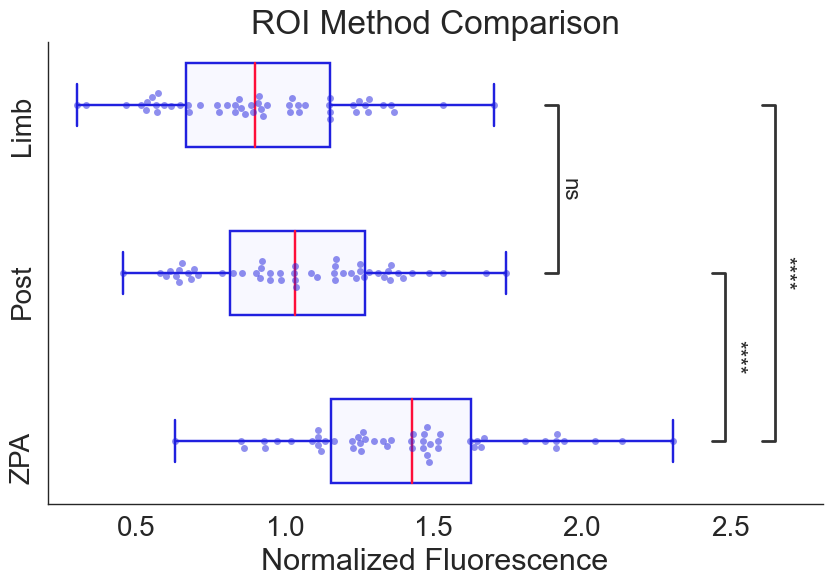

In [ ]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='#2020dfff'):
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.rcParams.update({'font.size': 16})
    
    PROPS = {
    'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
    'medianprops': {'color': '#fe0e39ff'},
    'whiskerprops': {'color': box_color},
    'capprops': {'color': box_color}}

    ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, linewidth=1.75, orient='h', **PROPS)
    ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, orient='h', alpha=0.5)
    sns.despine(ax=ax,top=True,right=True)
    
    pairs = [(i[1]['group1'], i[1]['group2']) for i in tukey_result_df.iterrows() if
            (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
    p_values = [i[1]['p-adj'] for i in tukey_result_df.iterrows() if
            (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
    
    annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order, orient='h')
    annotator.configure(text_format="star", loc="inside", line_width=2)
    annotator.set_pvalues_and_annotate(p_values)
    # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.

    mut_dict = {'g_r_limb_i_sum_norm': 'Limb', 'g_r_post_i_sum_norm':'Post', 'g_r_zpa_i_sum_norm':'ZPA'}
    label_list = [mut_dict[i] for i in order]
    plt.title(ptitle, fontsize=24)
    ax.set_yticklabels(label_list, rotation=90)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.set_xlabel('Normalized Fluorescence', fontsize=22 )
    ax.set_ylabel('')
    #plt.show()
    plt.savefig('roi_boxplot.svg', dpi=500)

order = ['g_r_limb_i_sum_norm', 'g_r_post_i_sum_norm', 'g_r_zpa_i_sum_norm']
desired_pairs = list(combinations(order, 2))
box_swarm_plot(method_df_cleaned_iqr_melt, order, 'Normalized Intensity', 'Method', 'ROI Method Comparison')


#### ROI Conclusion

In general, there are significant differences between groups when used in combination with the Sum method, but not the Mean method (see below) (Tukey's HSD, $p\leq0.05$). The group median increases as the selected ROI decreases. However, there is not always a difference between the limb and posterior ROIs. An argument could be made for using any of these ROIs, though the ZPA is more prone to produce outliers initially. The best ROI method to use could depend upon the scientific question being asked. 

### 3.2.5 Method Comparison: Background Subtraction

To account for variation in background light levels between images/experiments:
* Bg: unaltered.
* Bg removed: each image's background fluorescence has been subtracted.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_limb_i_mean_norm vs. g_r_limb_i_mean_norm_bg_sub: Custom statistical test, P_val:9.991e-01
g_r_limb_i_sum_norm vs. g_r_limb_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_rgb_limb_i_mean_norm vs. g_rgb_limb_i_mean_norm_bg_sub: Custom statistical test, P_val:6.498e-01
g_rgb_limb_i_sum_norm vs. g_rgb_limb_i_sum_norm_bg_sub: Custom statistical test, P_val:9.997e-01
rgb_rgb_limb_i_mean_norm vs. rgb_rgb_limb_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
rgb_rgb_limb_i_sum_norm vs. rgb_rgb_limb_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00


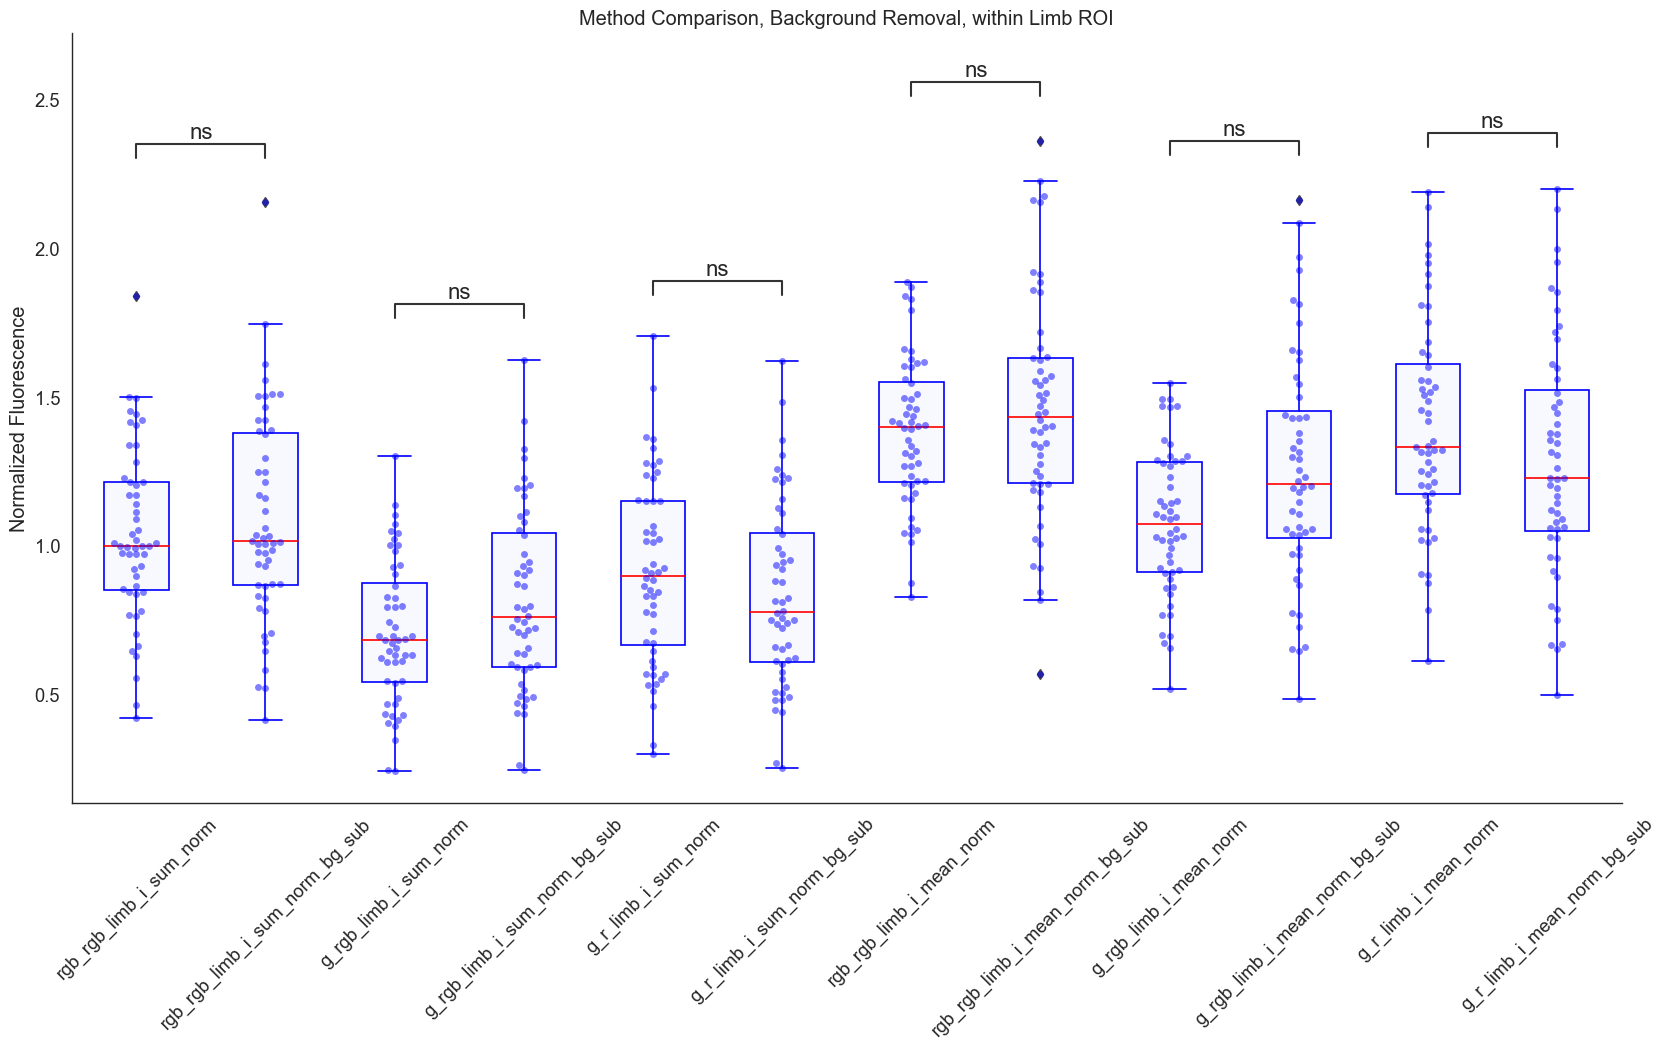

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_post_i_mean_norm vs. g_r_post_i_mean_norm_bg_sub: Custom statistical test, P_val:9.995e-01
g_r_post_i_sum_norm vs. g_r_post_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_rgb_post_i_mean_norm vs. g_rgb_post_i_mean_norm_bg_sub: Custom statistical test, P_val:7.707e-01
g_rgb_post_i_sum_norm vs. g_rgb_post_i_sum_norm_bg_sub: Custom statistical test, P_val:9.973e-01
rgb_rgb_post_i_mean_norm vs. rgb_rgb_post_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
rgb_rgb_post_i_sum_norm vs. rgb_rgb_post_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00


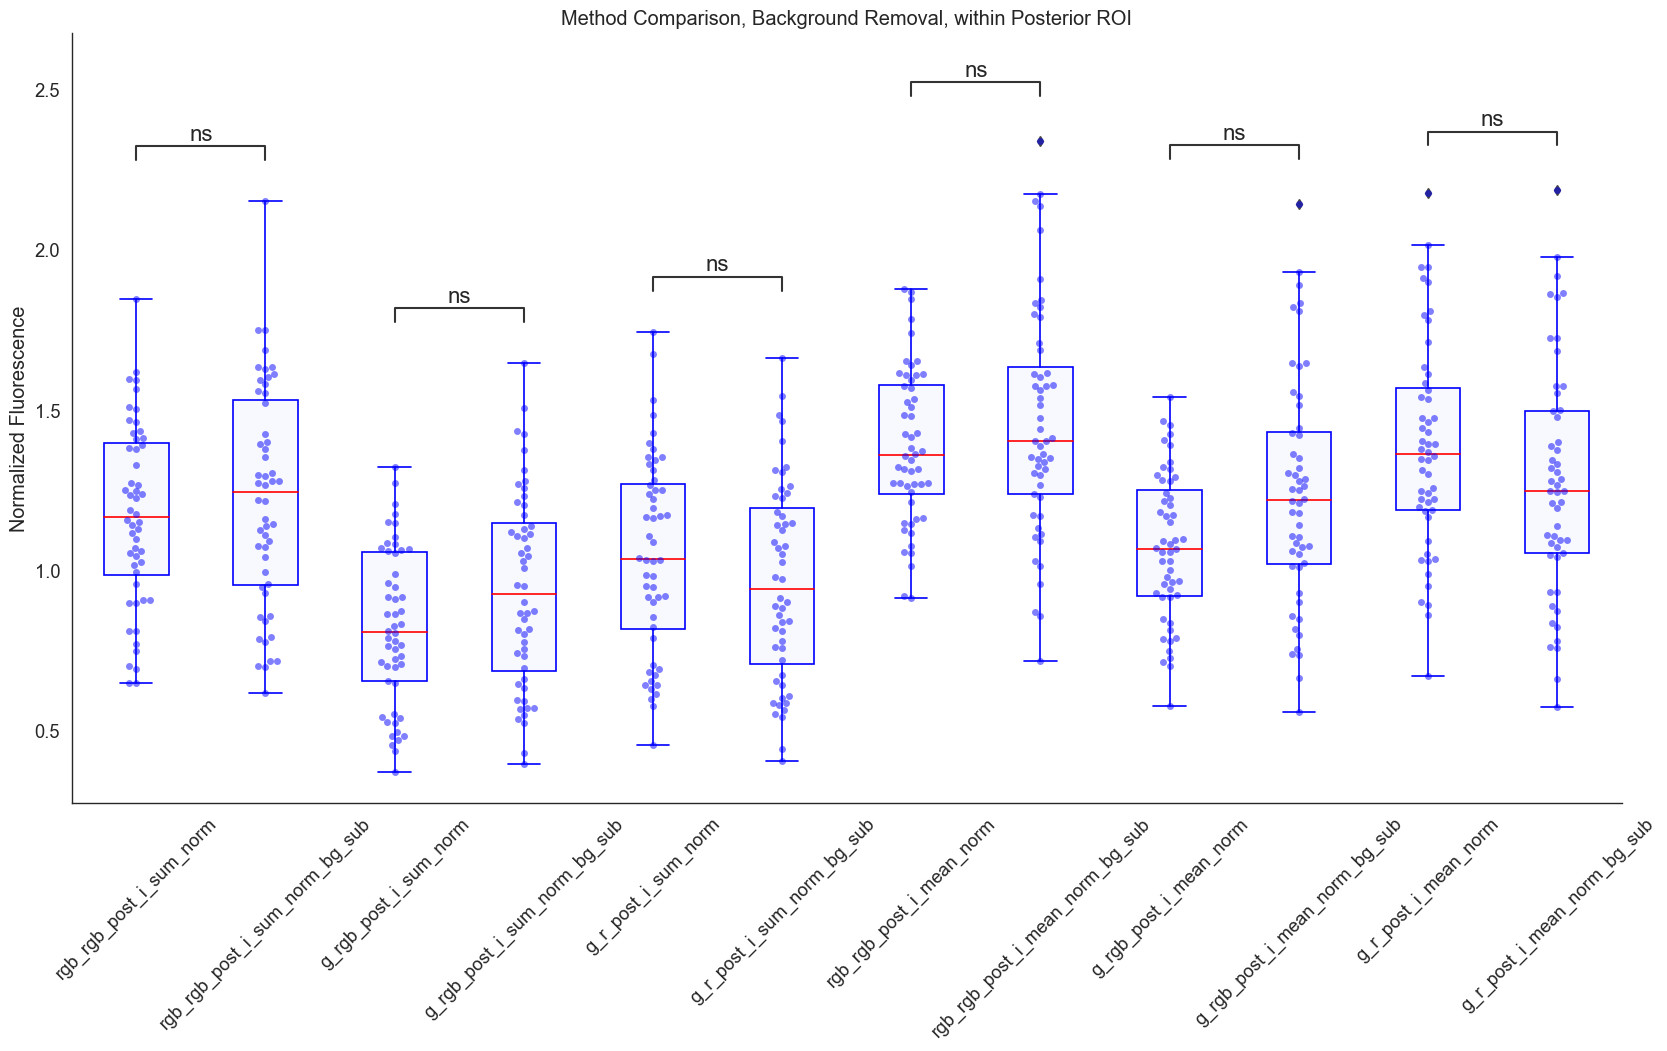

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_zpa_i_mean_norm vs. g_r_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_r_zpa_i_sum_norm vs. g_r_zpa_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00
g_rgb_zpa_i_mean_norm vs. g_rgb_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:1.062e-01
g_rgb_zpa_i_sum_norm vs. g_rgb_zpa_i_sum_norm_bg_sub: Custom statistical test, P_val:2.688e-01
rgb_rgb_zpa_i_mean_norm vs. rgb_rgb_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:9.350e-01
rgb_rgb_zpa_i_sum_norm vs. rgb_rgb_zpa_i_sum_norm_bg_sub: Custom statistical test, P_val:9.747e-01


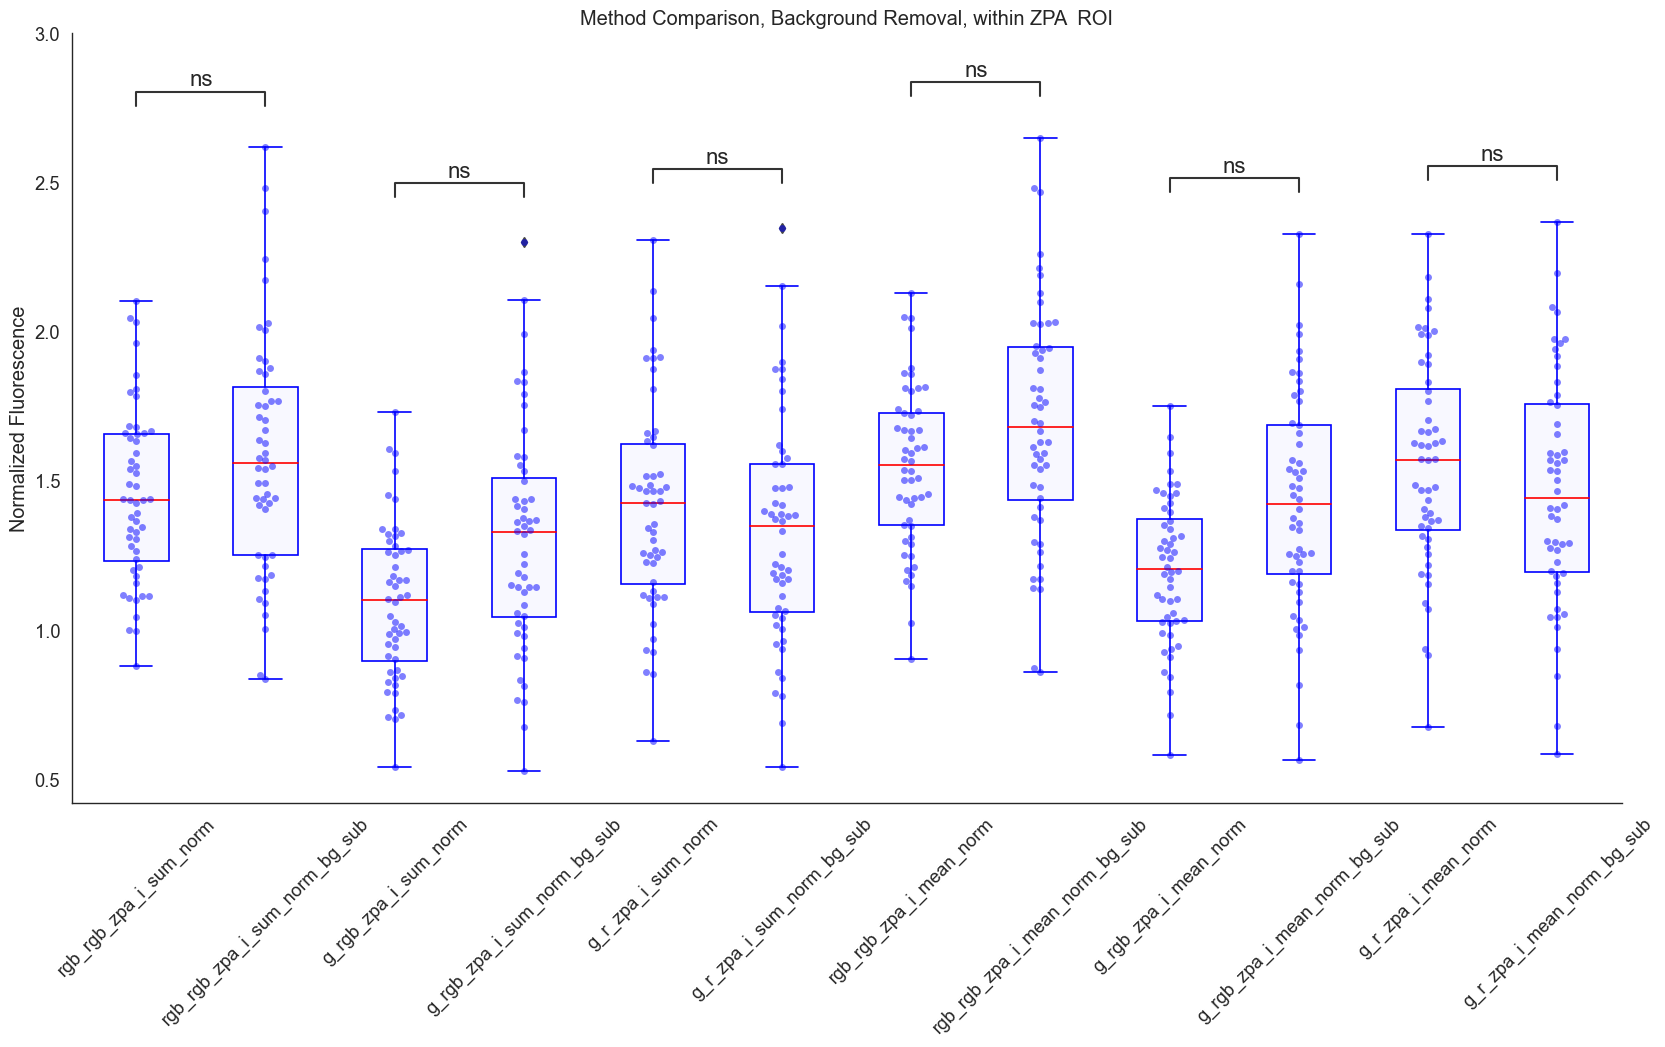

In [35]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='blue'):
        plt.figure(figsize=(20, 10))
        plt.rcParams.update({'font.size': 16})
        
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': 'red'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        pairs = [(i[1]['group1'], i[1]['group2']) for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
        p_values = [i[1]['p-adj'] for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]

        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        annotator.configure(text_format="star", loc="inside")
        annotator.set_pvalues_and_annotate(p_values)
        # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.

        # mut_dict = {}
        # label_list = [mut_dict[i] for i in order]
        plt.title(ptitle)
        ax.set_xticklabels(order, rotation=45)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence')
        plt.show()
        #plt.savefig('Fig_Name.png')

limb = ['rgb_rgb_limb_i_sum_norm', 'rgb_rgb_limb_i_sum_norm_bg_sub',
        'g_rgb_limb_i_sum_norm', 'g_rgb_limb_i_sum_norm_bg_sub',
        'g_r_limb_i_sum_norm', 'g_r_limb_i_sum_norm_bg_sub',
        'rgb_rgb_limb_i_mean_norm', 'rgb_rgb_limb_i_mean_norm_bg_sub',
        'g_rgb_limb_i_mean_norm', 'g_rgb_limb_i_mean_norm_bg_sub',
        'g_r_limb_i_mean_norm', 'g_r_limb_i_mean_norm_bg_sub'
        ]


desired_pairs = [('rgb_rgb_limb_i_sum_norm', 'rgb_rgb_limb_i_sum_norm_bg_sub'),
        ('g_rgb_limb_i_sum_norm', 'g_rgb_limb_i_sum_norm_bg_sub'),
        ('g_r_limb_i_sum_norm', 'g_r_limb_i_sum_norm_bg_sub'),
        ('rgb_rgb_limb_i_mean_norm', 'rgb_rgb_limb_i_mean_norm_bg_sub'),
        ('g_rgb_limb_i_mean_norm', 'g_rgb_limb_i_mean_norm_bg_sub'),
        ('g_r_limb_i_mean_norm', 'g_r_limb_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, limb, 'Method', 'Normalized Intensity', 'Method Comparison, Background Removal, within Limb ROI')

post = ['rgb_rgb_post_i_sum_norm', 'rgb_rgb_post_i_sum_norm_bg_sub',
        'g_rgb_post_i_sum_norm', 'g_rgb_post_i_sum_norm_bg_sub',
        'g_r_post_i_sum_norm', 'g_r_post_i_sum_norm_bg_sub', 
        'rgb_rgb_post_i_mean_norm', 'rgb_rgb_post_i_mean_norm_bg_sub',
        'g_rgb_post_i_mean_norm', 'g_rgb_post_i_mean_norm_bg_sub',
        'g_r_post_i_mean_norm', 'g_r_post_i_mean_norm_bg_sub'
        ]

desired_pairs = [('rgb_rgb_post_i_sum_norm', 'rgb_rgb_post_i_sum_norm_bg_sub'),
        ('g_rgb_post_i_sum_norm', 'g_rgb_post_i_sum_norm_bg_sub'),
        ('g_r_post_i_sum_norm', 'g_r_post_i_sum_norm_bg_sub'), 
        ('rgb_rgb_post_i_mean_norm', 'rgb_rgb_post_i_mean_norm_bg_sub'),
        ('g_rgb_post_i_mean_norm', 'g_rgb_post_i_mean_norm_bg_sub'),
        ('g_r_post_i_mean_norm', 'g_r_post_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, post,'Method', 'Normalized Intensity', 'Method Comparison, Background Removal, within Posterior ROI')

zpa = ['rgb_rgb_zpa_i_sum_norm', 'rgb_rgb_zpa_i_sum_norm_bg_sub',
        'g_rgb_zpa_i_sum_norm', 'g_rgb_zpa_i_sum_norm_bg_sub',
        'g_r_zpa_i_sum_norm', 'g_r_zpa_i_sum_norm_bg_sub', 
        'rgb_rgb_zpa_i_mean_norm', 'rgb_rgb_zpa_i_mean_norm_bg_sub',
        'g_rgb_zpa_i_mean_norm', 'g_rgb_zpa_i_mean_norm_bg_sub',
        'g_r_zpa_i_mean_norm', 'g_r_zpa_i_mean_norm_bg_sub'
        ]
desired_pairs = [('rgb_rgb_zpa_i_sum_norm', 'rgb_rgb_zpa_i_sum_norm_bg_sub'),
        ('g_rgb_zpa_i_sum_norm', 'g_rgb_zpa_i_sum_norm_bg_sub'),
        ('g_r_zpa_i_sum_norm', 'g_r_zpa_i_sum_norm_bg_sub'), 
        ('rgb_rgb_zpa_i_mean_norm', 'rgb_rgb_zpa_i_mean_norm_bg_sub'),
        ('g_rgb_zpa_i_mean_norm', 'g_rgb_zpa_i_mean_norm_bg_sub'),
        ('g_r_zpa_i_mean_norm', 'g_r_zpa_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, zpa, 'Method', 'Normalized Intensity', 'Method Comparison, Background Removal, within ZPA  ROI')

Example plot for paper:

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_limb_i_sum_norm vs. g_r_limb_i_sum_norm_bg_sub: Custom statistical test, P_val:1.000e+00


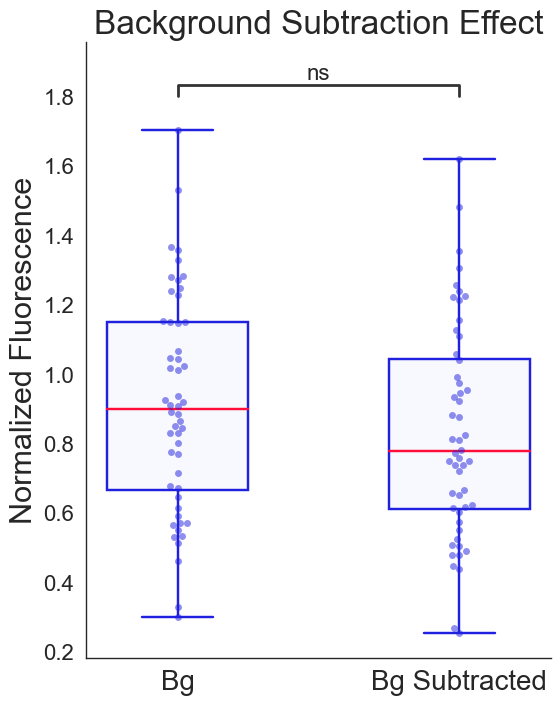

In [ ]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='#2020dfff'):
        
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(6, 8), facecolor='white') 
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': '#fe0e39ff'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, linewidth=1.75, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        pairs = [(i[1]['group1'], i[1]['group2']) for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
        p_values = [i[1]['p-adj'] for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]

        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        annotator.configure(text_format="star", loc="inside", line_width=2)
        annotator.set_pvalues_and_annotate(p_values)
        # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.

        mut_dict = {'g_r_limb_i_sum_norm': 'Bg', 'g_r_limb_i_sum_norm_bg_sub': 'Bg Subtracted'}
        label_list = [mut_dict[i] for i in order]
        plt.title(ptitle, fontsize=24) #, fontweight='bold'
        ax.set_xticklabels(label_list)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence', fontsize=22)
        ax.tick_params(axis='y', labelsize=16)
        ax.tick_params(axis='x', labelsize=20)
        plt.show()
        #plt.savefig('rgb_boxplot.svg', dpi=500)





order = [
        'g_r_limb_i_sum_norm',  
        'g_r_limb_i_sum_norm_bg_sub', 
        ]
desired_pairs = list(combinations(order, 2))
box_swarm_plot(method_df_cleaned_iqr_melt, order, 'Method', 'Normalized Intensity', 'Background Subtraction Effect')


#### Background Subtraction Conclusion

Background subtraction did not result in a statistically significant difference on normalized fluorescence regardless of the other methods with which it was combined (Tukey's HSD, $p\leq0.05$). This may be due to a high level of mechanical consistency, and may be microscope- and camera-specific. Although background subtraction did not make a difference in our set-up, we recommend testing this assumption on other set-ups.

### 3.2.6 Method Comparison: Sum vs. Mean 
The common method in fluorescence image analysis is the use the mean fluorescent intensity (MFI):
* Sum = $\sum\frac{I_{GFP}}{I_{RFP}}$

* Mean = $\mu\frac{I_{GFP}}{I_{RFP}}$

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_limb_i_sum_norm vs. g_r_limb_i_mean_norm: Custom statistical test, P_val:0.000e+00
g_r_limb_i_sum_norm_bg_sub vs. g_r_limb_i_mean_norm_bg_sub: Custom statistical test, P_val:0.000e+00
g_rgb_limb_i_sum_norm vs. g_rgb_limb_i_mean_norm: Custom statistical test, P_val:0.000e+00
g_rgb_limb_i_sum_norm_bg_sub vs. g_rgb_limb_i_mean_norm_bg_sub: Custom statistical test, P_val:0.000e+00
rgb_rgb_limb_i_sum_norm vs. rgb_rgb_limb_i_mean_norm: Custom statistical test, P_val:0.000e+00
rgb_rgb_limb_i_sum_norm_bg_sub vs. rgb_rgb_limb_i_mean_norm_bg_sub: Custom statistical test, P_val:0.000e+00


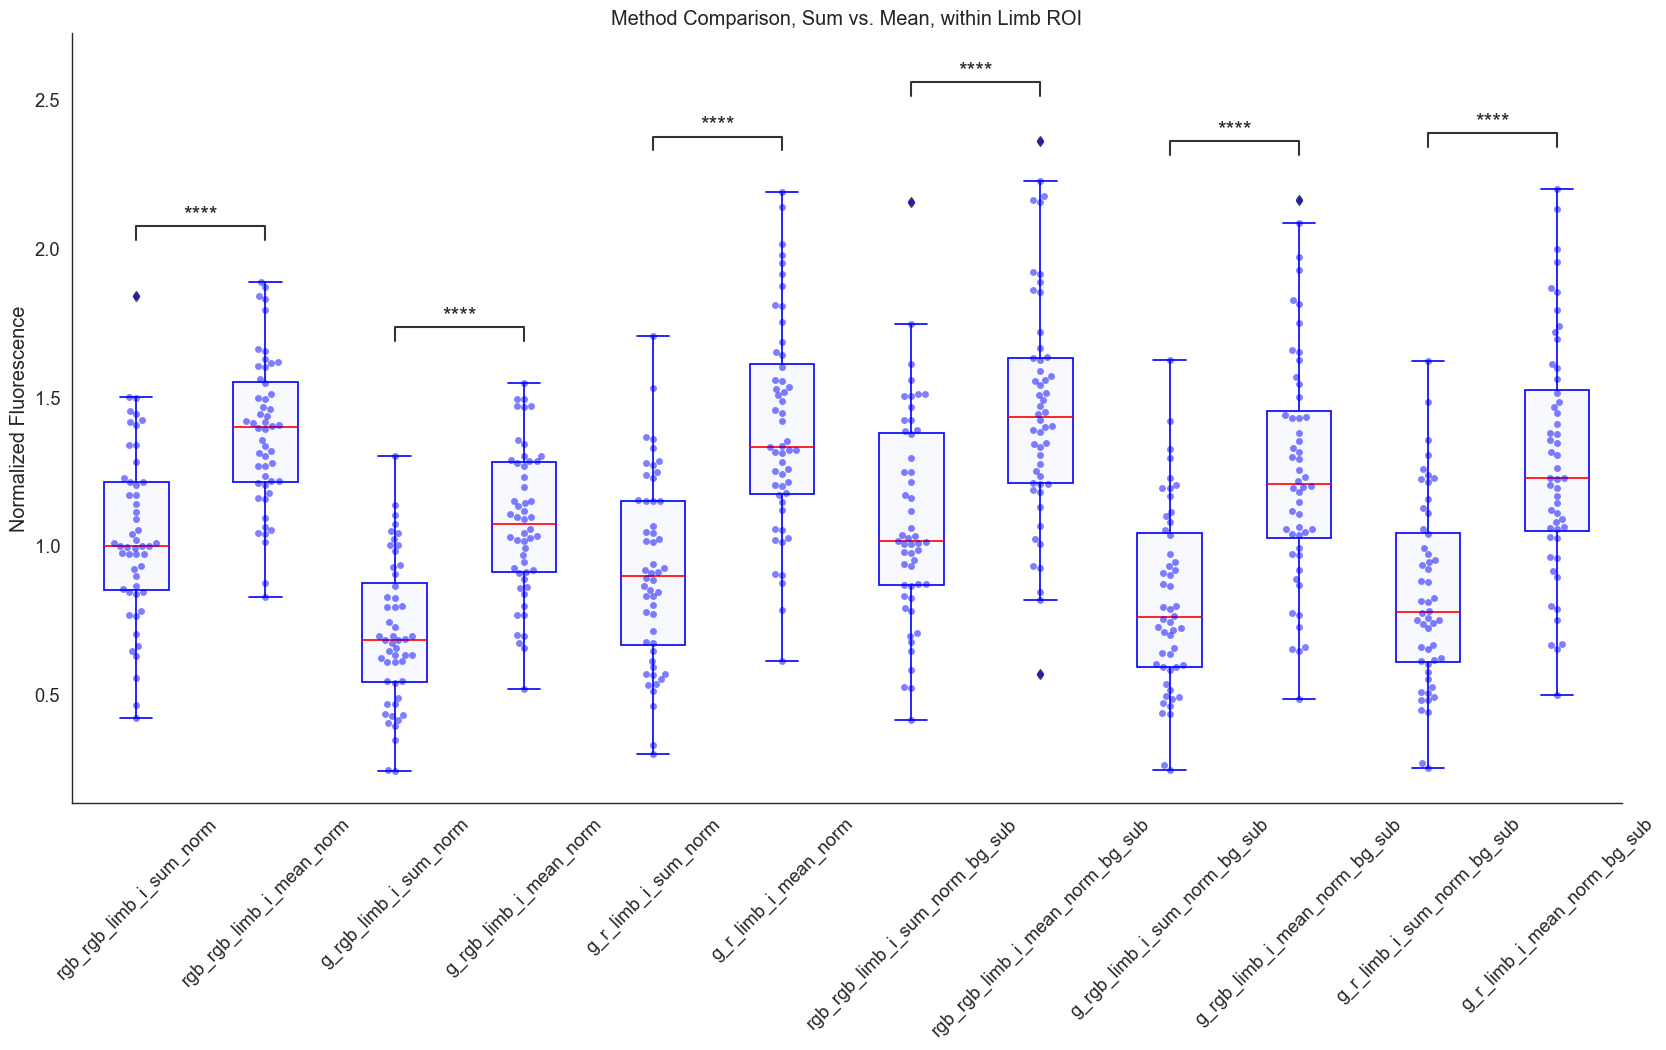

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_post_i_sum_norm vs. g_r_post_i_mean_norm: Custom statistical test, P_val:1.000e-04
g_r_post_i_sum_norm_bg_sub vs. g_r_post_i_mean_norm_bg_sub: Custom statistical test, P_val:7.000e-04
g_rgb_post_i_sum_norm vs. g_rgb_post_i_mean_norm: Custom statistical test, P_val:3.290e-02
g_rgb_post_i_sum_norm_bg_sub vs. g_rgb_post_i_mean_norm_bg_sub: Custom statistical test, P_val:1.400e-03
rgb_rgb_post_i_sum_norm vs. rgb_rgb_post_i_mean_norm: Custom statistical test, P_val:2.063e-01
rgb_rgb_post_i_sum_norm_bg_sub vs. rgb_rgb_post_i_mean_norm_bg_sub: Custom statistical test, P_val:9.370e-02


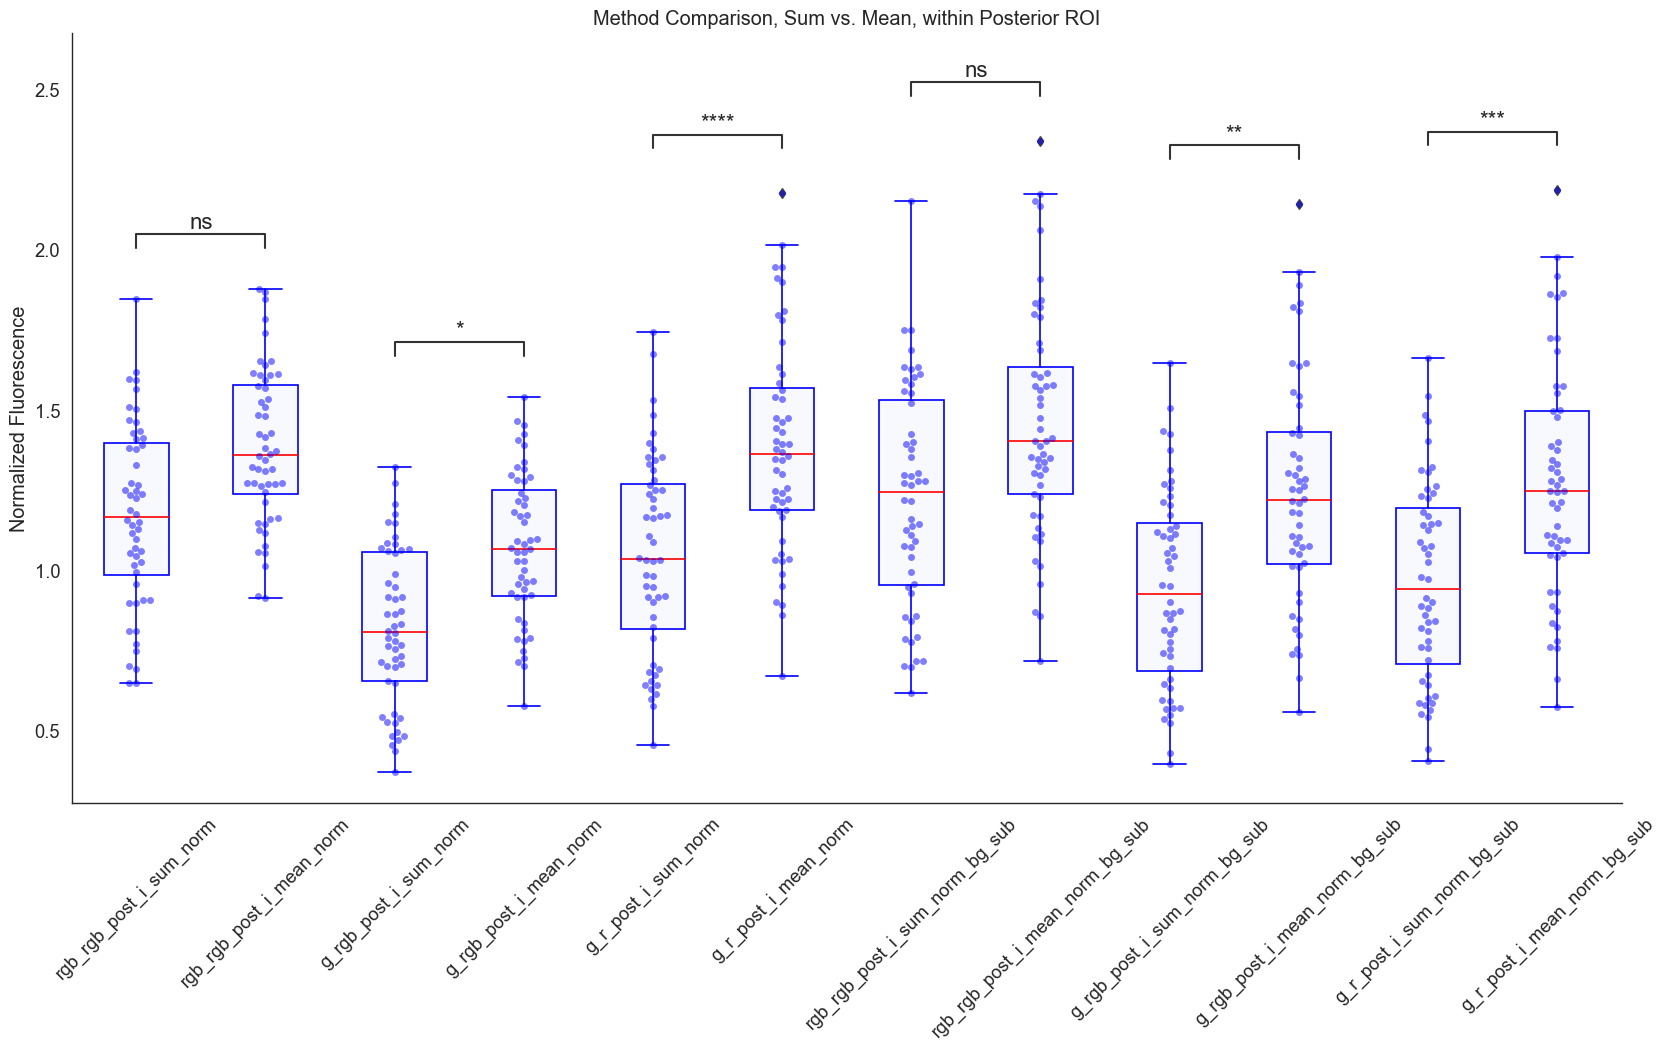

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_zpa_i_sum_norm vs. g_r_zpa_i_mean_norm: Custom statistical test, P_val:9.471e-01
g_r_zpa_i_sum_norm_bg_sub vs. g_r_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:9.738e-01
g_rgb_zpa_i_sum_norm vs. g_rgb_zpa_i_mean_norm: Custom statistical test, P_val:9.998e-01
g_rgb_zpa_i_sum_norm_bg_sub vs. g_rgb_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:9.920e-01
rgb_rgb_zpa_i_sum_norm vs. rgb_rgb_zpa_i_mean_norm: Custom statistical test, P_val:1.000e+00
rgb_rgb_zpa_i_sum_norm_bg_sub vs. rgb_rgb_zpa_i_mean_norm_bg_sub: Custom statistical test, P_val:9.996e-01


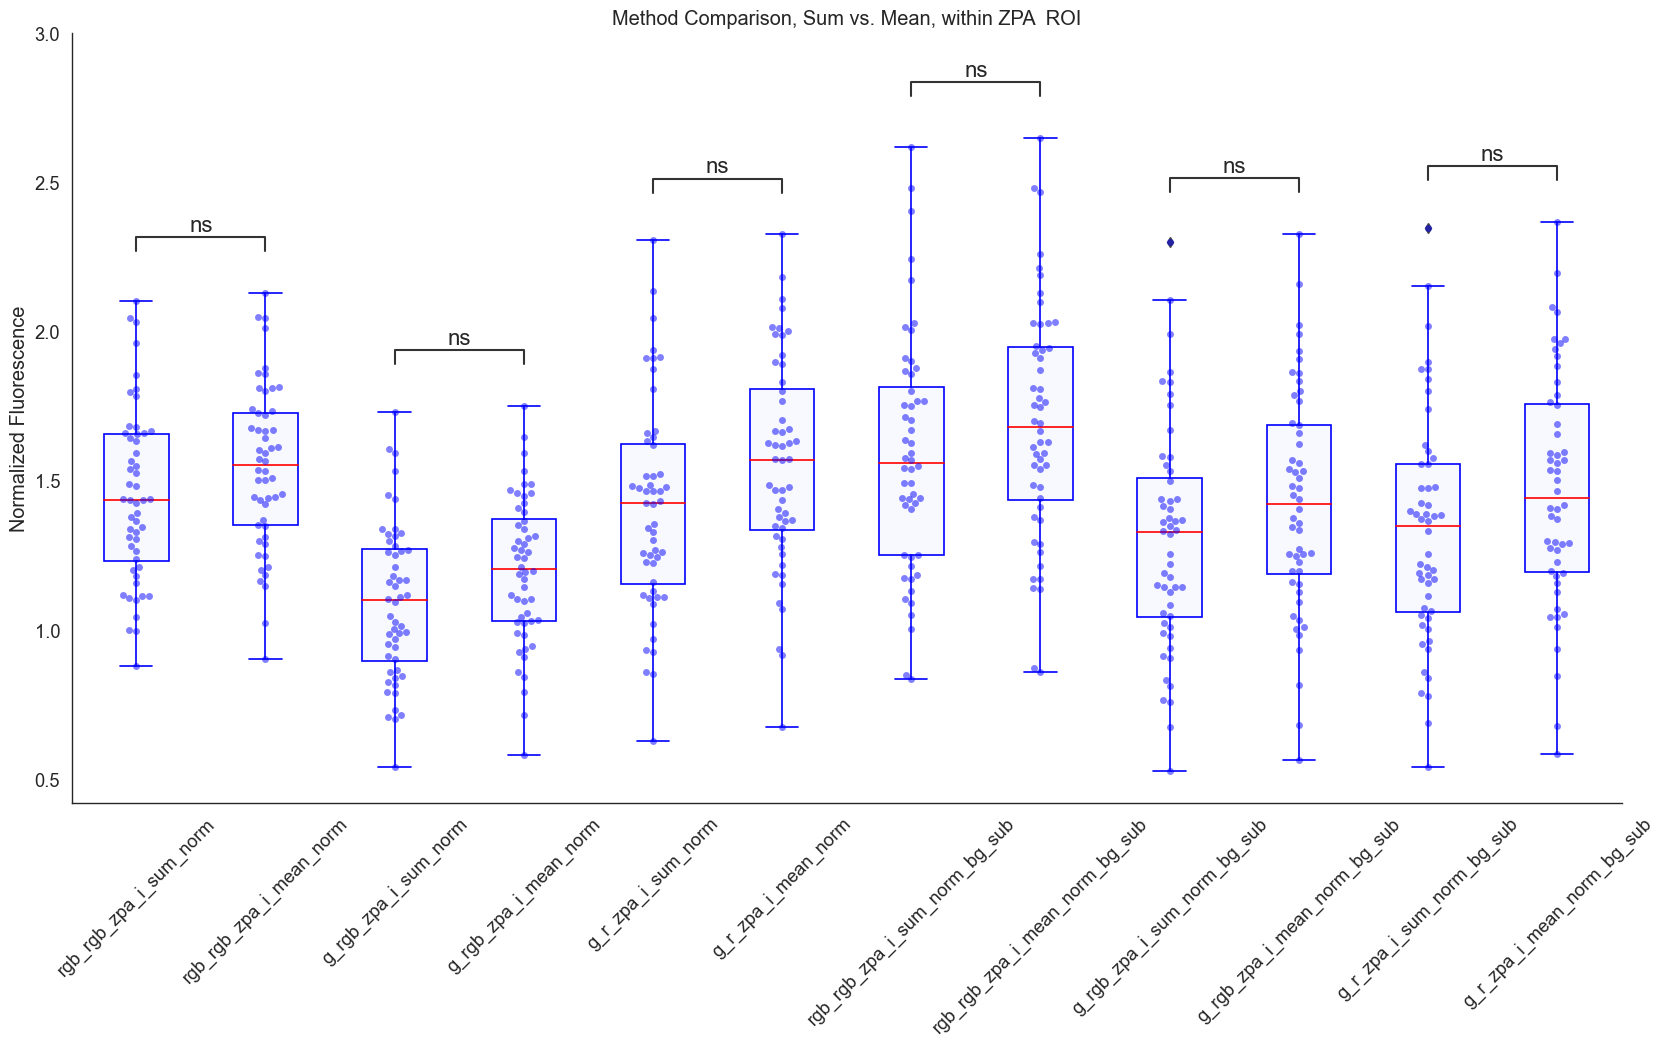

In [37]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='blue'):
        plt.figure(figsize=(20, 10))
        plt.rcParams.update({'font.size': 16})
        
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': 'red'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        pairs = [(i[1]['group1'], i[1]['group2']) for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
        p_values = [i[1]['p-adj'] for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]

        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        annotator.configure(text_format="star", loc="inside")
        annotator.set_pvalues_and_annotate(p_values)
        # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.

        # mut_dict = {}
        # label_list = [mut_dict[i] for i in order]
        plt.title(ptitle)
        ax.set_xticklabels(order, rotation=45)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence')
        plt.show()
        #plt.savefig('Fig_Name.png')



limb = ['rgb_rgb_limb_i_sum_norm','rgb_rgb_limb_i_mean_norm',
        'g_rgb_limb_i_sum_norm', 'g_rgb_limb_i_mean_norm', 
        'g_r_limb_i_sum_norm', 'g_r_limb_i_mean_norm',
        'rgb_rgb_limb_i_sum_norm_bg_sub', 'rgb_rgb_limb_i_mean_norm_bg_sub',
        'g_rgb_limb_i_sum_norm_bg_sub', 'g_rgb_limb_i_mean_norm_bg_sub',
        'g_r_limb_i_sum_norm_bg_sub', 'g_r_limb_i_mean_norm_bg_sub'
        ]

desired_pairs = [('rgb_rgb_limb_i_sum_norm','rgb_rgb_limb_i_mean_norm'),
        ('g_rgb_limb_i_sum_norm', 'g_rgb_limb_i_mean_norm'), 
        ('g_r_limb_i_sum_norm', 'g_r_limb_i_mean_norm'),
        ('rgb_rgb_limb_i_sum_norm_bg_sub', 'rgb_rgb_limb_i_mean_norm_bg_sub'),
        ('g_rgb_limb_i_sum_norm_bg_sub', 'g_rgb_limb_i_mean_norm_bg_sub'),
        ('g_r_limb_i_sum_norm_bg_sub', 'g_r_limb_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, limb, 'Method', 'Normalized Intensity', 'Method Comparison, Sum vs. Mean, within Limb ROI')

post = ['rgb_rgb_post_i_sum_norm','rgb_rgb_post_i_mean_norm',
        'g_rgb_post_i_sum_norm', 'g_rgb_post_i_mean_norm',
        'g_r_post_i_sum_norm', 'g_r_post_i_mean_norm',
        'rgb_rgb_post_i_sum_norm_bg_sub', 'rgb_rgb_post_i_mean_norm_bg_sub',
        'g_rgb_post_i_sum_norm_bg_sub', 'g_rgb_post_i_mean_norm_bg_sub',
        'g_r_post_i_sum_norm_bg_sub', 'g_r_post_i_mean_norm_bg_sub'
        ]

desired_pairs = [('rgb_rgb_post_i_sum_norm','rgb_rgb_post_i_mean_norm'),
        ('g_rgb_post_i_sum_norm', 'g_rgb_post_i_mean_norm'),
        ('g_r_post_i_sum_norm', 'g_r_post_i_mean_norm'),
        ('rgb_rgb_post_i_sum_norm_bg_sub', 'rgb_rgb_post_i_mean_norm_bg_sub'),
        ('g_rgb_post_i_sum_norm_bg_sub', 'g_rgb_post_i_mean_norm_bg_sub'),
        ('g_r_post_i_sum_norm_bg_sub', 'g_r_post_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, post,'Method', 'Normalized Intensity', 'Method Comparison, Sum vs. Mean, within Posterior ROI')

zpa = ['rgb_rgb_zpa_i_sum_norm', 'rgb_rgb_zpa_i_mean_norm',
        'g_rgb_zpa_i_sum_norm', 'g_rgb_zpa_i_mean_norm', 
        'g_r_zpa_i_sum_norm', 'g_r_zpa_i_mean_norm',
        'rgb_rgb_zpa_i_sum_norm_bg_sub', 'rgb_rgb_zpa_i_mean_norm_bg_sub',
        'g_rgb_zpa_i_sum_norm_bg_sub', 'g_rgb_zpa_i_mean_norm_bg_sub',
        'g_r_zpa_i_sum_norm_bg_sub', 'g_r_zpa_i_mean_norm_bg_sub'
        ]

desired_pairs = [('rgb_rgb_zpa_i_sum_norm', 'rgb_rgb_zpa_i_mean_norm'),
        ('g_rgb_zpa_i_sum_norm', 'g_rgb_zpa_i_mean_norm'), 
        ('g_r_zpa_i_sum_norm', 'g_r_zpa_i_mean_norm'),
        ('rgb_rgb_zpa_i_sum_norm_bg_sub', 'rgb_rgb_zpa_i_mean_norm_bg_sub'),
        ('g_rgb_zpa_i_sum_norm_bg_sub', 'g_rgb_zpa_i_mean_norm_bg_sub'),
        ('g_r_zpa_i_sum_norm_bg_sub', 'g_r_zpa_i_mean_norm_bg_sub')
        ]
box_swarm_plot(method_df_cleaned_iqr_melt, zpa, 'Method', 'Normalized Intensity', 'Method Comparison, Sum vs. Mean, within ZPA  ROI')

Example plot for paper:

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_r_limb_i_sum_norm vs. g_r_limb_i_mean_norm: Custom statistical test, P_val:0.000e+00


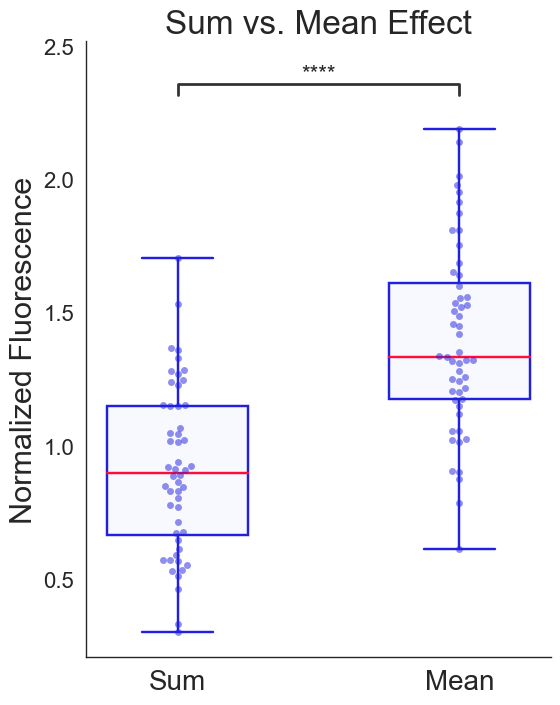

In [ ]:
def box_swarm_plot(df, order, x, y, ptitle, box_color='#2020dfff'):
        
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(6, 8), facecolor='white') 
        PROPS = {
        'boxprops': {'facecolor': 'ghostwhite', 'edgecolor': box_color},
        'medianprops': {'color': '#fe0e39ff'},
        'whiskerprops': {'color': box_color},
        'capprops': {'color': box_color}}

        ax = sns.boxplot(data=df, x=x, y=y, order=order, width=0.5, linewidth=1.75, **PROPS)
        ax = sns.swarmplot(data=df, x=x, y=y, order=order, color=box_color, alpha=0.5)
        sns.despine(ax=ax,top=True,right=True)
        
        pairs = [(i[1]['group1'], i[1]['group2']) for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]
        p_values = [i[1]['p-adj'] for i in tukey_result_df.iterrows() if
                (i[1]['group1'], i[1]['group2']) in desired_pairs or (i[1]['group2'], i[1]['group1']) in desired_pairs]

        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        annotator.configure(text_format="star", loc="inside", line_width=2)
        annotator.set_pvalues_and_annotate(p_values)
        # t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.

        mut_dict = {'g_r_limb_i_sum_norm': 'Sum', 'g_r_limb_i_mean_norm':'Mean'}
        label_list = [mut_dict[i] for i in order]
        plt.title(ptitle, fontsize=24) #, fontweight='bold'
        ax.set_xticklabels(label_list)
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Fluorescence', fontsize=22)
        ax.tick_params(axis='y', labelsize=16)
        ax.tick_params(axis='x', labelsize=20)
        plt.show()
        #plt.savefig('sum-mean_boxplot.svg', dpi=500)



order = [
        'g_r_limb_i_sum_norm', 
        'g_r_limb_i_mean_norm',
        ]
desired_pairs = list(combinations(order, 2))
box_swarm_plot(method_df_cleaned_iqr_melt, order, 'Method', 'Normalized Intensity', 'Sum vs. Mean Effect')


#### Sum vs. Mean Conclusion

In many cases, taking the mean intensity resulted in significantly higher normalized values than using the sum of intensity (Tukey's HSD, $p\leq0.05$). Interestingly, within the ZPA ROI there was no significant difference between using the sum or mean intensity (Tukey's HSD, $p\leq0.05$). We will likely use the sum of intensity moving forward, as it may reflect greater nuance of spatial information than the mean.